In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile
import librosa
import os
import csv
import tqdm.notebook as tqdm
from collections import defaultdict
from scipy import signal
import librosa.display
import cv2

files = os.listdir("outputs/combined")
input_files = os.listdir("inputs/ESC-50-master/audio")

In [2]:
import torch.nn as nn
import torch

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [4]:
class Block(nn.Module):
    def __init__(self, in_chan=64, out_chan=64, upsample=False, residual=True):
        super().__init__()
        self.residual = residual
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None
        self.conv1 = nn.Conv2d(in_chan, out_chan, 3, padding=1)
        self.conv2 = nn.Conv2d(out_chan, out_chan, 3, padding=1)
        self.residual = nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=1)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.upsample is not None:
            x = self.upsample(x)
        res = self.conv1(x)
        res = self.activation(res)
        res = self.conv2(res)
        if self.residual:
            res += self.residual(x)
        res = self.activation(res)
        return res

class ResConvNet1(nn.Module):
    def __init__(self, input_dim=7, hidden_list=[64, 128, 256, 2]):
        super().__init__()
        self.include_initial = input_dim == hidden_list[0]
        self.initial_conv = nn.Conv2d(input_dim, hidden_list[0], 3, padding=1)
        self.blocks = nn.ModuleList([])
        in_out_pairs = zip(hidden_list[:-1], hidden_list[1:])
        for ind, (in_chan, out_chan) in enumerate(in_out_pairs):
            block = Block(
                in_chan,
                out_chan,
            )
            self.blocks.append(block)
            print("Adding block")

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResConvNet2(nn.Module):
    def __init__(self, input_dim=1, hidden_list=[64, 128, 64, 16]):
        super().__init__()
        self.include_initial = input_dim == hidden_list[0]
        self.initial_conv = nn.Conv2d(input_dim, hidden_list[0], 3, padding=1)
        self.blocks = nn.ModuleList([])
        self.fully_connected1 = nn.Linear(65536, 1024)
        self.fully_connected2 = nn.Linear(1024, 10)
        self.flatten = nn.Flatten()
        in_out_pairs = zip(hidden_list[:-1], hidden_list[1:])
        for ind, (in_chan, out_chan) in enumerate(in_out_pairs):
            block = Block(
                in_chan,
                out_chan,
            )
            self.blocks.append(block)
            print("Adding block")

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x
    
class ResConvNet3(nn.Module):
    def __init__(self, input_dim=7, hidden_list=[64, 128, 64, 16]):
        super().__init__()
        self.include_initial = input_dim == hidden_list[0]
        self.initial_conv = nn.Conv2d(input_dim, hidden_list[0], 3, padding=1)
        self.blocks = nn.ModuleList([])
        self.fully_connected1 = nn.Linear(65536, 1024)
        self.fully_connected2 = nn.Linear(1024, 55)
        
        self.flatten = nn.Flatten()
        in_out_pairs = zip(hidden_list[:-1], hidden_list[1:])
        for ind, (in_chan, out_chan) in enumerate(in_out_pairs):
            block = Block(
                in_chan,
                out_chan,
            )
            self.blocks.append(block)
            print("Adding block")

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x


In [ ]:
model = ResConvNet2()
model = model.to("cuda")
print(model.blocks)

In [7]:
test_input = np.zeros([5, 1, 64, 64])
test_input = torch.from_numpy(test_input).float()
test_input = test_input.to("cuda")
print(model.forward(test_input).shape)

torch.Size([5, 10])


In [6]:
reader = csv.reader(open('inputs/esc50.csv', 'r'))
fn2cat = {}
cat2fn = defaultdict(list)
header = True
for row in reader:
    if header == True:
        header = False
        continue
    if row[4] == "True": ## only esc10
        filename = row[0]
        category = row[3]
        fn2cat[filename] = category
        cat2fn[category].append(filename)

In [7]:
catmix2id = {}
id2catmix = {}

count = 0
cats = list(cat2fn.keys())
for i in range(len(cats)-1):
    for j in range(i+1, len(cats)):
        catmix2id[(cats[i], cats[j])] = count
        id2catmix[count] = (cats[i], cats[j])
        count += 1

In [8]:
cat2id = {}
id2cat = {}
count = 0
cats = list(cat2fn.keys())
for i in range(len(cats)):
    cat2id[cats[i]] = count
    id2cat[count] = cats[i]
    count += 1


In [19]:
# print(fn2cat)

In [26]:
# JUST PREDICT ESC10 (NEXT 4 CELLS)

train_data = []
train_output = []

batch_specs = []
out_specs = []

for i in tqdm.tqdm(fn2cat.keys()):
    
    f = wavfile.read("inputs/ESC-50-master/audio/" + i)
    spec = []
    
    wavf = (f[1][:2**17]/32768.0)
    X = librosa.stft(wavf)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    spec.append(res)
    spec = (np.array(spec))
    batch_specs.append(spec)
    
    out_spec = np.zeros(10)
    out_spec[cat2id[fn2cat[i]]] = 1
    out_specs.append(out_spec)



  0%|          | 0/400 [00:00<?, ?it/s]

In [30]:
batch_specs = np.array(batch_specs)
batch_specs = batch_specs / np.max(batch_specs)
print(batch_specs.shape)
out_specs = np.array(out_specs)

print(out_specs.shape)

(400, 1, 64, 64)
(400, 10)


In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.00)

In [28]:
torch.cuda.empty_cache()

In [54]:
loss_fn = torch.nn.MSELoss(reduction='mean')
# learning_rate = 1e-6

losses = []

def grad_descent():
    for t in tqdm.tqdm(range(20000)):
        batch_idx = np.random.choice(list(range(300)), 300, replace = False)
        optimizer.zero_grad()
        # batch code goes here
        batch_in = np.take(batch_specs, batch_idx, 0)
        batch_out = np.take(out_specs, batch_idx, 0)
        batch_in = torch.from_numpy(batch_in).float()
        batch_in = batch_in.to("cuda")
        
        batch_out = torch.from_numpy(batch_out).float()
        batch_out = batch_out.to("cuda")
        

        y_pred = model.forward(batch_in)

        loss = loss_fn(y_pred, batch_out)
        losses.append(loss)
        print("Iter " + str(t) + ": " + str(loss.item()))
        if t % 100 == 99:
            torch.save(model, "outputs/model3")

        loss.backward()
        optimizer.step()
        

grad_descent()

  0%|          | 0/20000 [00:00<?, ?it/s]

Iter 0: 0.02583134174346924
Iter 1: 0.025748420506715775
Iter 2: 0.025663606822490692
Iter 3: 0.02558923326432705
Iter 4: 0.025510720908641815
Iter 5: 0.025440918281674385
Iter 6: 0.025367533788084984
Iter 7: 0.025306228548288345
Iter 8: 0.025238214060664177
Iter 9: 0.025180859491229057
Iter 10: 0.025117577984929085
Iter 11: 0.02506386861205101
Iter 12: 0.025008946657180786
Iter 13: 0.0249596256762743
Iter 14: 0.024908768013119698
Iter 15: 0.024863336235284805
Iter 16: 0.024816840887069702
Iter 17: 0.024777140468358994
Iter 18: 0.02473650872707367
Iter 19: 0.024703096598386765
Iter 20: 0.024666529148817062
Iter 21: 0.024636907503008842
Iter 22: 0.02460380084812641
Iter 23: 0.02457660622894764
Iter 24: 0.024546589702367783
Iter 25: 0.024521972984075546
Iter 26: 0.024496955797076225
Iter 27: 0.02447418123483658
Iter 28: 0.024453895166516304
Iter 29: 0.024436354637145996
Iter 30: 0.024414662271738052
Iter 31: 0.024399487301707268
Iter 32: 0.024382730945944786
Iter 33: 0.024368848651647568

Iter 272: 0.02519891783595085
Iter 273: 0.02515692636370659
Iter 274: 0.025126006454229355
Iter 275: 0.02508433535695076
Iter 276: 0.02505575306713581
Iter 277: 0.02501632645726204
Iter 278: 0.02498895302414894
Iter 279: 0.024949783459305763
Iter 280: 0.024920668452978134
Iter 281: 0.0248822420835495
Iter 282: 0.02485295571386814
Iter 283: 0.02481723017990589
Iter 284: 0.02479001320898533
Iter 285: 0.02475750260055065
Iter 286: 0.024732258170843124
Iter 287: 0.024703074246644974
Iter 288: 0.024680940434336662
Iter 289: 0.024654570966959
Iter 290: 0.024632111191749573
Iter 291: 0.02460547350347042
Iter 292: 0.024586420506238937
Iter 293: 0.024561498314142227
Iter 294: 0.024543818086385727
Iter 295: 0.02452041581273079
Iter 296: 0.02450582943856716
Iter 297: 0.024485504254698753
Iter 298: 0.024473030120134354
Iter 299: 0.02445487678050995
Iter 300: 0.024443496018648148
Iter 301: 0.024425920099020004
Iter 302: 0.02441801130771637
Iter 303: 0.024402368813753128
Iter 304: 0.0243978165090084

Iter 541: 0.024869801476597786
Iter 542: 0.02483450062572956
Iter 543: 0.024782471358776093
Iter 544: 0.024746334180235863
Iter 545: 0.024694981053471565
Iter 546: 0.024659890681505203
Iter 547: 0.02461019903421402
Iter 548: 0.02457548677921295
Iter 549: 0.02453048713505268
Iter 550: 0.02449650503695011
Iter 551: 0.024452893063426018
Iter 552: 0.024419348686933517
Iter 553: 0.024376243352890015
Iter 554: 0.024343840777873993
Iter 555: 0.024303080514073372
Iter 556: 0.024273447692394257
Iter 557: 0.024232909083366394
Iter 558: 0.024207577109336853
Iter 559: 0.024169910699129105
Iter 560: 0.02414574660360813
Iter 561: 0.024113042280077934
Iter 562: 0.02409145049750805
Iter 563: 0.024061942473053932
Iter 564: 0.024042312055826187
Iter 565: 0.024014610797166824
Iter 566: 0.02399618737399578
Iter 567: 0.02397354692220688
Iter 568: 0.02396007813513279
Iter 569: 0.023939887061715126
Iter 570: 0.02392868511378765
Iter 571: 0.02391112968325615
Iter 572: 0.02390112541615963
Iter 573: 0.023884745

Iter 809: 0.023838521912693977
Iter 810: 0.023815561085939407
Iter 811: 0.02379237301647663
Iter 812: 0.02377074584364891
Iter 813: 0.02374887652695179
Iter 814: 0.023728009313344955
Iter 815: 0.023707514628767967
Iter 816: 0.02368815802037716
Iter 817: 0.02367083728313446
Iter 818: 0.02365177311003208
Iter 819: 0.023633742704987526
Iter 820: 0.023615190759301186
Iter 821: 0.02359895221889019
Iter 822: 0.023581665009260178
Iter 823: 0.023564940318465233
Iter 824: 0.023548584431409836
Iter 825: 0.023533711209893227
Iter 826: 0.02351774089038372
Iter 827: 0.023503359407186508
Iter 828: 0.02348983660340309
Iter 829: 0.02347690798342228
Iter 830: 0.023467089980840683
Iter 831: 0.023453734815120697
Iter 832: 0.023444684222340584
Iter 833: 0.023433852940797806
Iter 834: 0.023425549268722534
Iter 835: 0.023416003212332726
Iter 836: 0.023410074412822723
Iter 837: 0.02340058796107769
Iter 838: 0.02339634671807289
Iter 839: 0.023390313610434532
Iter 840: 0.023384714499115944
Iter 841: 0.02338063

Iter 1075: 0.023247912526130676
Iter 1076: 0.023228850215673447
Iter 1077: 0.02321935072541237
Iter 1078: 0.023203503340482712
Iter 1079: 0.02319509908556938
Iter 1080: 0.02318008430302143
Iter 1081: 0.023175127804279327
Iter 1082: 0.023160912096500397
Iter 1083: 0.023157410323619843
Iter 1084: 0.02314802259206772
Iter 1085: 0.023147575557231903
Iter 1086: 0.023139474913477898
Iter 1087: 0.023139124736189842
Iter 1088: 0.02313230372965336
Iter 1089: 0.023133035749197006
Iter 1090: 0.023127542808651924
Iter 1091: 0.023128598928451538
Iter 1092: 0.023124031722545624
Iter 1093: 0.02312680333852768
Iter 1094: 0.023124512284994125
Iter 1095: 0.023128461092710495
Iter 1096: 0.023126967251300812
Iter 1097: 0.0231307540088892
Iter 1098: 0.02313055843114853
Iter 1099: 0.02313605695962906
Iter 1100: 0.02313949353992939
Iter 1101: 0.02314778044819832
Iter 1102: 0.023151105269789696
Iter 1103: 0.023158220574259758
Iter 1104: 0.023162322118878365
Iter 1105: 0.02317185513675213
Iter 1106: 0.02317768

Iter 1335: 0.02268204651772976
Iter 1336: 0.02266780100762844
Iter 1337: 0.022671204060316086
Iter 1338: 0.022660724818706512
Iter 1339: 0.022663403302431107
Iter 1340: 0.022655079141259193
Iter 1341: 0.022659189999103546
Iter 1342: 0.02265249565243721
Iter 1343: 0.022657006978988647
Iter 1344: 0.022653143852949142
Iter 1345: 0.022661995142698288
Iter 1346: 0.02266031876206398
Iter 1347: 0.02267206460237503
Iter 1348: 0.022671448066830635
Iter 1349: 0.02268405817449093
Iter 1350: 0.022685712203383446
Iter 1351: 0.022698700428009033
Iter 1352: 0.022699302062392235
Iter 1353: 0.022711940109729767
Iter 1354: 0.022712407633662224
Iter 1355: 0.02272620052099228
Iter 1356: 0.022728482261300087
Iter 1357: 0.02274363674223423
Iter 1358: 0.022746820002794266
Iter 1359: 0.022762179374694824
Iter 1360: 0.022765515372157097
Iter 1361: 0.02278173714876175
Iter 1362: 0.0227856133133173
Iter 1363: 0.022802487015724182
Iter 1364: 0.02280491776764393
Iter 1365: 0.022821584716439247
Iter 1366: 0.0228252

Iter 1595: 0.022457778453826904
Iter 1596: 0.022445576265454292
Iter 1597: 0.022441871464252472
Iter 1598: 0.022430425509810448
Iter 1599: 0.022427231073379517
Iter 1600: 0.022417167201638222
Iter 1601: 0.022415684536099434
Iter 1602: 0.022406358271837234
Iter 1603: 0.022403649985790253
Iter 1604: 0.0223933607339859
Iter 1605: 0.02239040844142437
Iter 1606: 0.022379223257303238
Iter 1607: 0.022377336397767067
Iter 1608: 0.02236696518957615
Iter 1609: 0.022364217787981033
Iter 1610: 0.022354379296302795
Iter 1611: 0.02235034666955471
Iter 1612: 0.02233947440981865
Iter 1613: 0.022337164729833603
Iter 1614: 0.02232750505208969
Iter 1615: 0.02232642099261284
Iter 1616: 0.02231735549867153
Iter 1617: 0.022316263988614082
Iter 1618: 0.02230868488550186
Iter 1619: 0.022308440878987312
Iter 1620: 0.02230125479400158
Iter 1621: 0.02230181358754635
Iter 1622: 0.022294051945209503
Iter 1623: 0.022294815629720688
Iter 1624: 0.022286929190158844
Iter 1625: 0.022287139669060707
Iter 1626: 0.0222791

Iter 1855: 0.021912476047873497
Iter 1856: 0.02191063202917576
Iter 1857: 0.021912524476647377
Iter 1858: 0.021910835057497025
Iter 1859: 0.021911470219492912
Iter 1860: 0.021908201277256012
Iter 1861: 0.021910063922405243
Iter 1862: 0.021908648312091827
Iter 1863: 0.021912483498454094
Iter 1864: 0.02191104181110859
Iter 1865: 0.0219135582447052
Iter 1866: 0.021911930292844772
Iter 1867: 0.02191520668566227
Iter 1868: 0.021914571523666382
Iter 1869: 0.0219175573438406
Iter 1870: 0.021916816011071205
Iter 1871: 0.021918030455708504
Iter 1872: 0.021916355937719345
Iter 1873: 0.02191508375108242
Iter 1874: 0.02191159315407276
Iter 1875: 0.02191139943897724
Iter 1876: 0.02190914936363697
Iter 1877: 0.021910689771175385
Iter 1878: 0.021908700466156006
Iter 1879: 0.021909810602664948
Iter 1880: 0.021906275302171707
Iter 1881: 0.02190539613366127
Iter 1882: 0.02190157026052475
Iter 1883: 0.021901031956076622
Iter 1884: 0.02189670316874981
Iter 1885: 0.02189614810049534
Iter 1886: 0.0218942165

Iter 2115: 0.021638434380292892
Iter 2116: 0.021641844883561134
Iter 2117: 0.02164127305150032
Iter 2118: 0.021642126142978668
Iter 2119: 0.021640434861183167
Iter 2120: 0.02164107747375965
Iter 2121: 0.021636629477143288
Iter 2122: 0.02163846231997013
Iter 2123: 0.021634599193930626
Iter 2124: 0.02163633704185486
Iter 2125: 0.021632280200719833
Iter 2126: 0.021633727476000786
Iter 2127: 0.021628880873322487
Iter 2128: 0.021631505340337753
Iter 2129: 0.02162606455385685
Iter 2130: 0.02162833698093891
Iter 2131: 0.02162090316414833
Iter 2132: 0.02162248268723488
Iter 2133: 0.021614521741867065
Iter 2134: 0.021616220474243164
Iter 2135: 0.021609127521514893
Iter 2136: 0.02161097154021263
Iter 2137: 0.0216053519397974
Iter 2138: 0.021605415269732475
Iter 2139: 0.02159826084971428
Iter 2140: 0.02159828133881092
Iter 2141: 0.02159031666815281
Iter 2142: 0.021590227261185646
Iter 2143: 0.02158169075846672
Iter 2144: 0.021581094712018967
Iter 2145: 0.02157244272530079
Iter 2146: 0.02157129906

Iter 2374: 0.02102079801261425
Iter 2375: 0.021034013479948044
Iter 2376: 0.021048691123723984
Iter 2377: 0.02106138877570629
Iter 2378: 0.02107636258006096
Iter 2379: 0.02108984813094139
Iter 2380: 0.021106915548443794
Iter 2381: 0.021120697259902954
Iter 2382: 0.02113788016140461
Iter 2383: 0.02115062065422535
Iter 2384: 0.02116619609296322
Iter 2385: 0.02118068002164364
Iter 2386: 0.02119538187980652
Iter 2387: 0.021207932382822037
Iter 2388: 0.021221190690994263
Iter 2389: 0.021234361454844475
Iter 2390: 0.02124652825295925
Iter 2391: 0.021260077133774757
Iter 2392: 0.021271906793117523
Iter 2393: 0.02128486894071102
Iter 2394: 0.021297723054885864
Iter 2395: 0.021311640739440918
Iter 2396: 0.02132437191903591
Iter 2397: 0.021335702389478683
Iter 2398: 0.02134876511991024
Iter 2399: 0.021359160542488098
Iter 2400: 0.021372055634856224
Iter 2401: 0.021383903920650482
Iter 2402: 0.021396184340119362
Iter 2403: 0.02140718139708042
Iter 2404: 0.021419622004032135
Iter 2405: 0.021429540

Iter 2633: 0.02100498601794243
Iter 2634: 0.02100183628499508
Iter 2635: 0.02101929672062397
Iter 2636: 0.02101382240653038
Iter 2637: 0.021027352660894394
Iter 2638: 0.021019022911787033
Iter 2639: 0.02103252150118351
Iter 2640: 0.02102399244904518
Iter 2641: 0.021032987162470818
Iter 2642: 0.021024273708462715
Iter 2643: 0.02103256992995739
Iter 2644: 0.021023722365498543
Iter 2645: 0.021031532436609268
Iter 2646: 0.021021168678998947
Iter 2647: 0.02102738246321678
Iter 2648: 0.021015921607613564
Iter 2649: 0.021021822467446327
Iter 2650: 0.021007725968956947
Iter 2651: 0.02101357840001583
Iter 2652: 0.020996203646063805
Iter 2653: 0.020999865606427193
Iter 2654: 0.020980343222618103
Iter 2655: 0.020981062203645706
Iter 2656: 0.02096073143184185
Iter 2657: 0.020959502086043358
Iter 2658: 0.02093886025249958
Iter 2659: 0.020939575508236885
Iter 2660: 0.020917106419801712
Iter 2661: 0.02091723307967186
Iter 2662: 0.020891394466161728
Iter 2663: 0.020888224244117737
Iter 2664: 0.0208627

Iter 2893: 0.02010571025311947
Iter 2894: 0.020109934732317924
Iter 2895: 0.02012765221297741
Iter 2896: 0.020132167264819145
Iter 2897: 0.02014995738863945
Iter 2898: 0.020153386518359184
Iter 2899: 0.02017146348953247
Iter 2900: 0.02017524279654026
Iter 2901: 0.020191464573144913
Iter 2902: 0.020196545869112015
Iter 2903: 0.02021547220647335
Iter 2904: 0.020220639184117317
Iter 2905: 0.02023947611451149
Iter 2906: 0.02024395577609539
Iter 2907: 0.020261943340301514
Iter 2908: 0.020265774801373482
Iter 2909: 0.020283399149775505
Iter 2910: 0.020285068079829216
Iter 2911: 0.020299188792705536
Iter 2912: 0.020296847447752953
Iter 2913: 0.02030825987458229
Iter 2914: 0.02030372805893421
Iter 2915: 0.020315568894147873
Iter 2916: 0.02031068317592144
Iter 2917: 0.02032361552119255
Iter 2918: 0.020317018032073975
Iter 2919: 0.02033017762005329
Iter 2920: 0.020324118435382843
Iter 2921: 0.020335815846920013
Iter 2922: 0.020328499376773834
Iter 2923: 0.020338688045740128
Iter 2924: 0.02033047

Iter 3153: 0.019772857427597046
Iter 3154: 0.019778156653046608
Iter 3155: 0.019785620272159576
Iter 3156: 0.019792785868048668
Iter 3157: 0.019801869988441467
Iter 3158: 0.019809236750006676
Iter 3159: 0.01982009783387184
Iter 3160: 0.019829431548714638
Iter 3161: 0.019840631633996964
Iter 3162: 0.01984970085322857
Iter 3163: 0.019860366359353065
Iter 3164: 0.01986992172896862
Iter 3165: 0.019881486892700195
Iter 3166: 0.019891802221536636
Iter 3167: 0.01990337297320366
Iter 3168: 0.0199135672301054
Iter 3169: 0.01992637850344181
Iter 3170: 0.019939038902521133
Iter 3171: 0.019952747970819473
Iter 3172: 0.019967401400208473
Iter 3173: 0.019980091601610184
Iter 3174: 0.019995586946606636
Iter 3175: 0.02000749483704567
Iter 3176: 0.020023928955197334
Iter 3177: 0.020035771653056145
Iter 3178: 0.020052367821335793
Iter 3179: 0.02006564475595951
Iter 3180: 0.020083308219909668
Iter 3181: 0.020094797015190125
Iter 3182: 0.020109551027417183
Iter 3183: 0.020121019333600998
Iter 3184: 0.0201

Iter 3412: 0.019286224618554115
Iter 3413: 0.019289102405309677
Iter 3414: 0.01929273083806038
Iter 3415: 0.019297026097774506
Iter 3416: 0.01930396817624569
Iter 3417: 0.01931147836148739
Iter 3418: 0.019320495426654816
Iter 3419: 0.01932995207607746
Iter 3420: 0.019340621307492256
Iter 3421: 0.019351087510585785
Iter 3422: 0.019360333681106567
Iter 3423: 0.0193706713616848
Iter 3424: 0.01937961019575596
Iter 3425: 0.01939082145690918
Iter 3426: 0.01940126344561577
Iter 3427: 0.019413793459534645
Iter 3428: 0.019424347206950188
Iter 3429: 0.019435986876487732
Iter 3430: 0.01944475993514061
Iter 3431: 0.01945601962506771
Iter 3432: 0.019465599209070206
Iter 3433: 0.019476842135190964
Iter 3434: 0.019484393298625946
Iter 3435: 0.019495178014039993
Iter 3436: 0.01950264535844326
Iter 3437: 0.019514093175530434
Iter 3438: 0.01952478475868702
Iter 3439: 0.019536789506673813
Iter 3440: 0.019549395889043808
Iter 3441: 0.019562501460313797
Iter 3442: 0.019575729966163635
Iter 3443: 0.01958789

Iter 3672: 0.01905820518732071
Iter 3673: 0.019059114158153534
Iter 3674: 0.019053753465414047
Iter 3675: 0.01905607245862484
Iter 3676: 0.019050559028983116
Iter 3677: 0.019052281975746155
Iter 3678: 0.019047001376748085
Iter 3679: 0.01904970034956932
Iter 3680: 0.0190446600317955
Iter 3681: 0.01904749497771263
Iter 3682: 0.019045565277338028
Iter 3683: 0.019048551097512245
Iter 3684: 0.01904555968940258
Iter 3685: 0.019049987196922302
Iter 3686: 0.019047193229198456
Iter 3687: 0.019051922485232353
Iter 3688: 0.019051287323236465
Iter 3689: 0.019056731835007668
Iter 3690: 0.01905611716210842
Iter 3691: 0.019060920923948288
Iter 3692: 0.019060254096984863
Iter 3693: 0.01906522363424301
Iter 3694: 0.019064735621213913
Iter 3695: 0.01906944438815117
Iter 3696: 0.019067855551838875
Iter 3697: 0.01907254196703434
Iter 3698: 0.019071461632847786
Iter 3699: 0.019074441865086555
Iter 3700: 0.01907195709645748
Iter 3701: 0.019073599949479103
Iter 3702: 0.019071202725172043
Iter 3703: 0.0190734

Iter 3932: 0.018756812438368797
Iter 3933: 0.01875213161110878
Iter 3934: 0.01874728500843048
Iter 3935: 0.01874353364109993
Iter 3936: 0.018739722669124603
Iter 3937: 0.018737249076366425
Iter 3938: 0.018733903765678406
Iter 3939: 0.01873152144253254
Iter 3940: 0.01872832328081131
Iter 3941: 0.01872641034424305
Iter 3942: 0.018723586574196815
Iter 3943: 0.018722541630268097
Iter 3944: 0.01872093975543976
Iter 3945: 0.018719857558608055
Iter 3946: 0.01871739886701107
Iter 3947: 0.018716581165790558
Iter 3948: 0.018713779747486115
Iter 3949: 0.01871221698820591
Iter 3950: 0.01870967075228691
Iter 3951: 0.018708201125264168
Iter 3952: 0.01870429888367653
Iter 3953: 0.018701694905757904
Iter 3954: 0.018698208034038544
Iter 3955: 0.01869538612663746
Iter 3956: 0.01869354397058487
Iter 3957: 0.01869012415409088
Iter 3958: 0.018687797710299492
Iter 3959: 0.01868467405438423
Iter 3960: 0.018682332709431648
Iter 3961: 0.0186796635389328
Iter 3962: 0.018677424639463425
Iter 3963: 0.018674807623

Iter 4192: 0.018945999443531036
Iter 4193: 0.01892620325088501
Iter 4194: 0.018926316872239113
Iter 4195: 0.01890631951391697
Iter 4196: 0.01890595257282257
Iter 4197: 0.018880678340792656
Iter 4198: 0.018878065049648285
Iter 4199: 0.01885516755282879
Iter 4200: 0.018854739144444466
Iter 4201: 0.018833117559552193
Iter 4202: 0.018833767622709274
Iter 4203: 0.01881088688969612
Iter 4204: 0.018811311572790146
Iter 4205: 0.01878845877945423
Iter 4206: 0.018789242953062057
Iter 4207: 0.018766459077596664
Iter 4208: 0.018766464665532112
Iter 4209: 0.018744587898254395
Iter 4210: 0.018744904547929764
Iter 4211: 0.018721411004662514
Iter 4212: 0.018725356087088585
Iter 4213: 0.018704764544963837
Iter 4214: 0.018710121512413025
Iter 4215: 0.018690193071961403
Iter 4216: 0.018694715574383736
Iter 4217: 0.01867673732340336
Iter 4218: 0.018679792061448097
Iter 4219: 0.01866164430975914
Iter 4220: 0.018664585426449776
Iter 4221: 0.018646087497472763
Iter 4222: 0.018649490550160408
Iter 4223: 0.018

Iter 4451: 0.018209094181656837
Iter 4452: 0.018214568495750427
Iter 4453: 0.018210167065262794
Iter 4454: 0.018214911222457886
Iter 4455: 0.01821056567132473
Iter 4456: 0.018215689808130264
Iter 4457: 0.01820901595056057
Iter 4458: 0.018212180584669113
Iter 4459: 0.01820490136742592
Iter 4460: 0.0182072464376688
Iter 4461: 0.018199654296040535
Iter 4462: 0.0181998610496521
Iter 4463: 0.018191423267126083
Iter 4464: 0.018192196264863014
Iter 4465: 0.018182162195444107
Iter 4466: 0.01818068139255047
Iter 4467: 0.018170494586229324
Iter 4468: 0.018168741837143898
Iter 4469: 0.018156951293349266
Iter 4470: 0.01815573126077652
Iter 4471: 0.018144361674785614
Iter 4472: 0.018142743036150932
Iter 4473: 0.018132202327251434
Iter 4474: 0.01813027262687683
Iter 4475: 0.01811889559030533
Iter 4476: 0.018115630373358727
Iter 4477: 0.0181022509932518
Iter 4478: 0.018098589032888412
Iter 4479: 0.018086496740579605
Iter 4480: 0.018083173781633377
Iter 4481: 0.01807103119790554
Iter 4482: 0.018065681

Iter 4711: 0.017893880605697632
Iter 4712: 0.01789063587784767
Iter 4713: 0.017890146002173424
Iter 4714: 0.01788492500782013
Iter 4715: 0.01788415014743805
Iter 4716: 0.017877310514450073
Iter 4717: 0.017874186858534813
Iter 4718: 0.01786542311310768
Iter 4719: 0.01785898394882679
Iter 4720: 0.01784946769475937
Iter 4721: 0.017841504886746407
Iter 4722: 0.01782958023250103
Iter 4723: 0.017821071669459343
Iter 4724: 0.017807001248002052
Iter 4725: 0.017800219357013702
Iter 4726: 0.017785578966140747
Iter 4727: 0.0177773404866457
Iter 4728: 0.01776251010596752
Iter 4729: 0.017754051834344864
Iter 4730: 0.017737366259098053
Iter 4731: 0.017727287486195564
Iter 4732: 0.017711615189909935
Iter 4733: 0.017703650519251823
Iter 4734: 0.01768823154270649
Iter 4735: 0.01767880655825138
Iter 4736: 0.017663853242993355
Iter 4737: 0.017655666917562485
Iter 4738: 0.01764138601720333
Iter 4739: 0.017632709816098213
Iter 4740: 0.01761951856315136
Iter 4741: 0.017611300572752953
Iter 4742: 0.017598049

Iter 4971: 0.0177119392901659
Iter 4972: 0.0177020151168108
Iter 4973: 0.017708102241158485
Iter 4974: 0.017695076763629913
Iter 4975: 0.01769867166876793
Iter 4976: 0.017683420330286026
Iter 4977: 0.017685292288661003
Iter 4978: 0.017668573185801506
Iter 4979: 0.017669696360826492
Iter 4980: 0.01765281707048416
Iter 4981: 0.01765386015176773
Iter 4982: 0.017638515681028366
Iter 4983: 0.017638571560382843
Iter 4984: 0.01762215606868267
Iter 4985: 0.017621446400880814
Iter 4986: 0.01760280318558216
Iter 4987: 0.01759898103773594
Iter 4988: 0.01758180931210518
Iter 4989: 0.017578376457095146
Iter 4990: 0.017561037093400955
Iter 4991: 0.01755875162780285
Iter 4992: 0.01754225604236126
Iter 4993: 0.01754116825759411
Iter 4994: 0.01752178743481636
Iter 4995: 0.01751936599612236
Iter 4996: 0.017500299960374832
Iter 4997: 0.017497841268777847
Iter 4998: 0.017478644847869873
Iter 4999: 0.017476411536335945
Iter 5000: 0.017457950860261917
Iter 5001: 0.017454899847507477
Iter 5002: 0.01743593439

Iter 5231: 0.017241107299923897
Iter 5232: 0.01723625138401985
Iter 5233: 0.017227282747626305
Iter 5234: 0.017221864312887192
Iter 5235: 0.01721285469830036
Iter 5236: 0.017209582030773163
Iter 5237: 0.017201373353600502
Iter 5238: 0.01719694584608078
Iter 5239: 0.017188867554068565
Iter 5240: 0.017183562740683556
Iter 5241: 0.017176112160086632
Iter 5242: 0.01717221736907959
Iter 5243: 0.017164967954158783
Iter 5244: 0.01716136746108532
Iter 5245: 0.017155926674604416
Iter 5246: 0.01715436950325966
Iter 5247: 0.017149804159998894
Iter 5248: 0.01714872010052204
Iter 5249: 0.017145410180091858
Iter 5250: 0.017143836244940758
Iter 5251: 0.017139609903097153
Iter 5252: 0.01713736727833748
Iter 5253: 0.01713286153972149
Iter 5254: 0.017130043357610703
Iter 5255: 0.017125612124800682
Iter 5256: 0.017124859616160393
Iter 5257: 0.017120826989412308
Iter 5258: 0.017117822542786598
Iter 5259: 0.01711346209049225
Iter 5260: 0.017112871631979942
Iter 5261: 0.017109761014580727
Iter 5262: 0.01710

Iter 5491: 0.01671675220131874
Iter 5492: 0.01672249846160412
Iter 5493: 0.016715342178940773
Iter 5494: 0.016720151528716087
Iter 5495: 0.01671268232166767
Iter 5496: 0.016716642305254936
Iter 5497: 0.016708485782146454
Iter 5498: 0.016713157296180725
Iter 5499: 0.016705702990293503
Iter 5500: 0.016711408272385597
Iter 5501: 0.016704147681593895
Iter 5502: 0.016709446907043457
Iter 5503: 0.01670175790786743
Iter 5504: 0.01670653000473976
Iter 5505: 0.01669849455356598
Iter 5506: 0.016701558604836464
Iter 5507: 0.016692321747541428
Iter 5508: 0.01669600047171116
Iter 5509: 0.01668604463338852
Iter 5510: 0.016689544543623924
Iter 5511: 0.016679393127560616
Iter 5512: 0.016682375222444534
Iter 5513: 0.01667250506579876
Iter 5514: 0.016675453633069992
Iter 5515: 0.01666606403887272
Iter 5516: 0.01666885055601597
Iter 5517: 0.016660230234265327
Iter 5518: 0.016662484034895897
Iter 5519: 0.016653619706630707
Iter 5520: 0.016657458618283272
Iter 5521: 0.01664714328944683
Iter 5522: 0.0166500

Iter 5751: 0.0163424015045166
Iter 5752: 0.016347480937838554
Iter 5753: 0.016341669484972954
Iter 5754: 0.016345607116818428
Iter 5755: 0.016339896246790886
Iter 5756: 0.016343964263796806
Iter 5757: 0.016337793320417404
Iter 5758: 0.016343027353286743
Iter 5759: 0.016338329762220383
Iter 5760: 0.016345346346497536
Iter 5761: 0.016341062262654305
Iter 5762: 0.016349179670214653
Iter 5763: 0.016346504911780357
Iter 5764: 0.016354944556951523
Iter 5765: 0.016353247687220573
Iter 5766: 0.016363253816962242
Iter 5767: 0.016363149508833885
Iter 5768: 0.016374720260500908
Iter 5769: 0.0163764376193285
Iter 5770: 0.016388289630413055
Iter 5771: 0.016389725729823112
Iter 5772: 0.016401590779423714
Iter 5773: 0.016403645277023315
Iter 5774: 0.016413120552897453
Iter 5775: 0.016413507983088493
Iter 5776: 0.01642538234591484
Iter 5777: 0.01642644964158535
Iter 5778: 0.01643732376396656
Iter 5779: 0.01643666811287403
Iter 5780: 0.01644568331539631
Iter 5781: 0.016444796696305275
Iter 5782: 0.0164

Iter 6010: 0.015855759382247925
Iter 6011: 0.01584947109222412
Iter 6012: 0.01584036462008953
Iter 6013: 0.015834202989935875
Iter 6014: 0.01582481898367405
Iter 6015: 0.015819627791643143
Iter 6016: 0.015812275931239128
Iter 6017: 0.015808405354619026
Iter 6018: 0.015802176669239998
Iter 6019: 0.015798797830939293
Iter 6020: 0.015793172642588615
Iter 6021: 0.01579124853014946
Iter 6022: 0.015786053612828255
Iter 6023: 0.0157838836312294
Iter 6024: 0.01577884890139103
Iter 6025: 0.015777813270688057
Iter 6026: 0.01577582024037838
Iter 6027: 0.015774035826325417
Iter 6028: 0.015773121267557144
Iter 6029: 0.015772778540849686
Iter 6030: 0.01577257737517357
Iter 6031: 0.015772707760334015
Iter 6032: 0.01577206887304783
Iter 6033: 0.01577228307723999
Iter 6034: 0.015771672129631042
Iter 6035: 0.01577192358672619
Iter 6036: 0.01577257178723812
Iter 6037: 0.015774020925164223
Iter 6038: 0.01577519066631794
Iter 6039: 0.015777036547660828
Iter 6040: 0.01577928476035595
Iter 6041: 0.0157812014

Iter 6270: 0.015849243849515915
Iter 6271: 0.015846453607082367
Iter 6272: 0.015834245830774307
Iter 6273: 0.01583111844956875
Iter 6274: 0.015817951411008835
Iter 6275: 0.015815135091543198
Iter 6276: 0.015804177150130272
Iter 6277: 0.015802383422851562
Iter 6278: 0.015792546793818474
Iter 6279: 0.015791509300470352
Iter 6280: 0.0157832819968462
Iter 6281: 0.015782028436660767
Iter 6282: 0.015772849321365356
Iter 6283: 0.015772877261042595
Iter 6284: 0.015764573588967323
Iter 6285: 0.01576407440006733
Iter 6286: 0.015756553038954735
Iter 6287: 0.015757057815790176
Iter 6288: 0.015750139951705933
Iter 6289: 0.015750430524349213
Iter 6290: 0.015744350850582123
Iter 6291: 0.01574343629181385
Iter 6292: 0.01573588140308857
Iter 6293: 0.015735764056444168
Iter 6294: 0.015728263184428215
Iter 6295: 0.015728820115327835
Iter 6296: 0.01572292111814022
Iter 6297: 0.015724899247288704
Iter 6298: 0.015718810260295868
Iter 6299: 0.01572258397936821
Iter 6300: 0.015717031434178352
Iter 6301: 0.015

Iter 6529: 0.01530730165541172
Iter 6530: 0.015300971455872059
Iter 6531: 0.015296597965061665
Iter 6532: 0.015291096642613411
Iter 6533: 0.015288221649825573
Iter 6534: 0.015285688452422619
Iter 6535: 0.015284593217074871
Iter 6536: 0.01528270822018385
Iter 6537: 0.015282610431313515
Iter 6538: 0.01528143510222435
Iter 6539: 0.015281297266483307
Iter 6540: 0.015277468599379063
Iter 6541: 0.015274901874363422
Iter 6542: 0.015271385200321674
Iter 6543: 0.015268291346728802
Iter 6544: 0.015265114605426788
Iter 6545: 0.015262113884091377
Iter 6546: 0.01525875087827444
Iter 6547: 0.015254533849656582
Iter 6548: 0.015251347795128822
Iter 6549: 0.01524804625660181
Iter 6550: 0.015244724228978157
Iter 6551: 0.01524040475487709
Iter 6552: 0.015234643593430519
Iter 6553: 0.01523001492023468
Iter 6554: 0.015224609524011612
Iter 6555: 0.01522043626755476
Iter 6556: 0.015214290469884872
Iter 6557: 0.015209131874144077
Iter 6558: 0.015201571397483349
Iter 6559: 0.015196218155324459
Iter 6560: 0.015

Iter 6787: 0.01495047751814127
Iter 6788: 0.014945960603654385
Iter 6789: 0.014931721612811089
Iter 6790: 0.01492992602288723
Iter 6791: 0.014916681684553623
Iter 6792: 0.014917450025677681
Iter 6793: 0.01490742340683937
Iter 6794: 0.014911454170942307
Iter 6795: 0.014902690425515175
Iter 6796: 0.014908241108059883
Iter 6797: 0.014901136979460716
Iter 6798: 0.014906957745552063
Iter 6799: 0.014900597743690014
Iter 6800: 0.014908195473253727
Iter 6801: 0.01490151695907116
Iter 6802: 0.014909619465470314
Iter 6803: 0.014903289265930653
Iter 6804: 0.014913351275026798
Iter 6805: 0.014908092096447945
Iter 6806: 0.014917707070708275
Iter 6807: 0.014912818558514118
Iter 6808: 0.014923413284122944
Iter 6809: 0.014921028167009354
Iter 6810: 0.014931906014680862
Iter 6811: 0.014929615892469883
Iter 6812: 0.01493951678276062
Iter 6813: 0.014937217347323895
Iter 6814: 0.014948292635381222
Iter 6815: 0.014946707524359226
Iter 6816: 0.014958493411540985
Iter 6817: 0.014957726933062077
Iter 6818: 0.

Iter 7045: 0.015142983756959438
Iter 7046: 0.015155360102653503
Iter 7047: 0.015145985409617424
Iter 7048: 0.015157385729253292
Iter 7049: 0.015148606151342392
Iter 7050: 0.015157442539930344
Iter 7051: 0.0151486461982131
Iter 7052: 0.015157843939960003
Iter 7053: 0.015147925354540348
Iter 7054: 0.01515703834593296
Iter 7055: 0.015146864578127861
Iter 7056: 0.01515617873519659
Iter 7057: 0.015146140940487385
Iter 7058: 0.015154525637626648
Iter 7059: 0.015144621022045612
Iter 7060: 0.015151496976613998
Iter 7061: 0.01514136977493763
Iter 7062: 0.015148251317441463
Iter 7063: 0.015135527588427067
Iter 7064: 0.01514286920428276
Iter 7065: 0.015129642561078072
Iter 7066: 0.015138588845729828
Iter 7067: 0.015128202736377716
Iter 7068: 0.015135806053876877
Iter 7069: 0.015125145204365253
Iter 7070: 0.015132278203964233
Iter 7071: 0.015121327713131905
Iter 7072: 0.015128118917346
Iter 7073: 0.015115206129848957
Iter 7074: 0.015121638774871826
Iter 7075: 0.015108603984117508
Iter 7076: 0.0151

Iter 7303: 0.014319420792162418
Iter 7304: 0.014317050576210022
Iter 7305: 0.014310376718640327
Iter 7306: 0.01430940255522728
Iter 7307: 0.014303576201200485
Iter 7308: 0.014303462579846382
Iter 7309: 0.01429698709398508
Iter 7310: 0.01429576613008976
Iter 7311: 0.01428966037929058
Iter 7312: 0.01428849808871746
Iter 7313: 0.014281805604696274
Iter 7314: 0.014281634241342545
Iter 7315: 0.014275342226028442
Iter 7316: 0.014276592992246151
Iter 7317: 0.014270556159317493
Iter 7318: 0.014271242544054985
Iter 7319: 0.014266647398471832
Iter 7320: 0.014267773367464542
Iter 7321: 0.014262240380048752
Iter 7322: 0.01426246203482151
Iter 7323: 0.014256726019084454
Iter 7324: 0.014255666173994541
Iter 7325: 0.014250528998672962
Iter 7326: 0.014249252155423164
Iter 7327: 0.014244834892451763
Iter 7328: 0.014245149679481983
Iter 7329: 0.01424008421599865
Iter 7330: 0.014242906123399734
Iter 7331: 0.014238479547202587
Iter 7332: 0.014241167344152927
Iter 7333: 0.014236370101571083
Iter 7334: 0.01

Iter 7561: 0.01420675404369831
Iter 7562: 0.014210649766027927
Iter 7563: 0.014214053750038147
Iter 7564: 0.014216850511729717
Iter 7565: 0.014218084514141083
Iter 7566: 0.014220324344933033
Iter 7567: 0.014221271499991417
Iter 7568: 0.01422361470758915
Iter 7569: 0.014223668724298477
Iter 7570: 0.014225531369447708
Iter 7571: 0.01422411110252142
Iter 7572: 0.01422579400241375
Iter 7573: 0.014224942773580551
Iter 7574: 0.014225073158740997
Iter 7575: 0.014223168604075909
Iter 7576: 0.014221780002117157
Iter 7577: 0.014220120385289192
Iter 7578: 0.014219451695680618
Iter 7579: 0.014217614196240902
Iter 7580: 0.014217658899724483
Iter 7581: 0.014214802533388138
Iter 7582: 0.01421559602022171
Iter 7583: 0.014212884940207005
Iter 7584: 0.014213399030268192
Iter 7585: 0.014209453016519547
Iter 7586: 0.01420950423926115
Iter 7587: 0.014206552878022194
Iter 7588: 0.014206483028829098
Iter 7589: 0.014203430153429508
Iter 7590: 0.014202783815562725
Iter 7591: 0.014199831523001194
Iter 7592: 0.0

Iter 7819: 0.014089281670749187
Iter 7820: 0.014085792005062103
Iter 7821: 0.014086136594414711
Iter 7822: 0.014081045985221863
Iter 7823: 0.014079775661230087
Iter 7824: 0.014072593301534653
Iter 7825: 0.01407037302851677
Iter 7826: 0.014063438400626183
Iter 7827: 0.01406070962548256
Iter 7828: 0.014053387567400932
Iter 7829: 0.014050940051674843
Iter 7830: 0.014042561873793602
Iter 7831: 0.014040669426321983
Iter 7832: 0.014032249338924885
Iter 7833: 0.014028364792466164
Iter 7834: 0.014016799628734589
Iter 7835: 0.014012357220053673
Iter 7836: 0.014002217911183834
Iter 7837: 0.01399671658873558
Iter 7838: 0.013986462727189064
Iter 7839: 0.013981254771351814
Iter 7840: 0.013969732448458672
Iter 7841: 0.013963251374661922
Iter 7842: 0.013951710425317287
Iter 7843: 0.013946421444416046
Iter 7844: 0.013935434632003307
Iter 7845: 0.01392946857959032
Iter 7846: 0.013918288983404636
Iter 7847: 0.013913140632212162
Iter 7848: 0.013901147991418839
Iter 7849: 0.013894742354750633
Iter 7850: 0

Iter 8077: 0.013620104640722275
Iter 8078: 0.013625995256006718
Iter 8079: 0.013634584844112396
Iter 8080: 0.013639991171658039
Iter 8081: 0.013647407293319702
Iter 8082: 0.013652450405061245
Iter 8083: 0.013660445809364319
Iter 8084: 0.013665865175426006
Iter 8085: 0.013673464767634869
Iter 8086: 0.01367930881679058
Iter 8087: 0.013686266727745533
Iter 8088: 0.013690879568457603
Iter 8089: 0.013697907328605652
Iter 8090: 0.013702094554901123
Iter 8091: 0.013707595877349377
Iter 8092: 0.013711873441934586
Iter 8093: 0.013717600144445896
Iter 8094: 0.013719488866627216
Iter 8095: 0.013725211843848228
Iter 8096: 0.0137258842587471
Iter 8097: 0.013729248195886612
Iter 8098: 0.01373080164194107
Iter 8099: 0.013733021914958954
Iter 8100: 0.01373270247131586
Iter 8101: 0.013735368847846985
Iter 8102: 0.013735146261751652
Iter 8103: 0.013736345805227757
Iter 8104: 0.013735503889620304
Iter 8105: 0.013735837303102016
Iter 8106: 0.013732517138123512
Iter 8107: 0.013731221668422222
Iter 8108: 0.

Iter 8335: 0.013649830594658852
Iter 8336: 0.013665739446878433
Iter 8337: 0.013666178099811077
Iter 8338: 0.013681177981197834
Iter 8339: 0.013682784512639046
Iter 8340: 0.013698470778763294
Iter 8341: 0.01369964424520731
Iter 8342: 0.013715035282075405
Iter 8343: 0.013713867403566837
Iter 8344: 0.013731926679611206
Iter 8345: 0.01373240165412426
Iter 8346: 0.01374997291713953
Iter 8347: 0.013748997822403908
Iter 8348: 0.013764556497335434
Iter 8349: 0.01376324612647295
Iter 8350: 0.013779482804238796
Iter 8351: 0.013777170330286026
Iter 8352: 0.013790776021778584
Iter 8353: 0.013786470517516136
Iter 8354: 0.013798818923532963
Iter 8355: 0.01379314437508583
Iter 8356: 0.013805107213556767
Iter 8357: 0.013797489926218987
Iter 8358: 0.013808347284793854
Iter 8359: 0.013798585161566734
Iter 8360: 0.013807559385895729
Iter 8361: 0.013796849176287651
Iter 8362: 0.013804908841848373
Iter 8363: 0.013793464750051498
Iter 8364: 0.01380092091858387
Iter 8365: 0.013788257725536823
Iter 8366: 0.0

Iter 8593: 0.012722739018499851
Iter 8594: 0.012735506519675255
Iter 8595: 0.012734511867165565
Iter 8596: 0.012747339904308319
Iter 8597: 0.012744775973260403
Iter 8598: 0.012757903896272182
Iter 8599: 0.01275699120014906
Iter 8600: 0.012771771289408207
Iter 8601: 0.012772132642567158
Iter 8602: 0.012787745334208012
Iter 8603: 0.012789642438292503
Iter 8604: 0.012805675156414509
Iter 8605: 0.012806073762476444
Iter 8606: 0.0128207141533494
Iter 8607: 0.012820899486541748
Iter 8608: 0.01283548679202795
Iter 8609: 0.012836501002311707
Iter 8610: 0.012852978892624378
Iter 8611: 0.012854658998548985
Iter 8612: 0.012871325947344303
Iter 8613: 0.012874686159193516
Iter 8614: 0.01289005670696497
Iter 8615: 0.012891978025436401
Iter 8616: 0.012907592579722404
Iter 8617: 0.012909194454550743
Iter 8618: 0.01292399037629366
Iter 8619: 0.012924551963806152
Iter 8620: 0.012938209809362888
Iter 8621: 0.01293839979916811
Iter 8622: 0.012952391989529133
Iter 8623: 0.012952527031302452
Iter 8624: 0.01

Iter 8851: 0.012882035225629807
Iter 8852: 0.01289114635437727
Iter 8853: 0.012889590114355087
Iter 8854: 0.01289968192577362
Iter 8855: 0.01289891917258501
Iter 8856: 0.012907616794109344
Iter 8857: 0.012906061485409737
Iter 8858: 0.012915180996060371
Iter 8859: 0.012913125567138195
Iter 8860: 0.012920171022415161
Iter 8861: 0.012916218489408493
Iter 8862: 0.012922221794724464
Iter 8863: 0.012918719090521336
Iter 8864: 0.012923640199005604
Iter 8865: 0.012919805012643337
Iter 8866: 0.012925245799124241
Iter 8867: 0.012922790832817554
Iter 8868: 0.012929480522871017
Iter 8869: 0.012925216928124428
Iter 8870: 0.01293193083256483
Iter 8871: 0.012928662821650505
Iter 8872: 0.012935447506606579
Iter 8873: 0.01293355505913496
Iter 8874: 0.012939155101776123
Iter 8875: 0.012936154380440712
Iter 8876: 0.012942502275109291
Iter 8877: 0.012939642183482647
Iter 8878: 0.012946618720889091
Iter 8879: 0.012943532317876816
Iter 8880: 0.012949122115969658
Iter 8881: 0.012944920919835567
Iter 8882: 0.

Iter 9109: 0.012507953681051731
Iter 9110: 0.012502064928412437
Iter 9111: 0.012500335462391376
Iter 9112: 0.012494804337620735
Iter 9113: 0.01249514240771532
Iter 9114: 0.012491251341998577
Iter 9115: 0.012491154484450817
Iter 9116: 0.01248619332909584
Iter 9117: 0.012486795894801617
Iter 9118: 0.012482469901442528
Iter 9119: 0.012482419610023499
Iter 9120: 0.012479039840400219
Iter 9121: 0.012479111552238464
Iter 9122: 0.012474620714783669
Iter 9123: 0.01247305516153574
Iter 9124: 0.012467194348573685
Iter 9125: 0.012465008534491062
Iter 9126: 0.012460173107683659
Iter 9127: 0.012457749806344509
Iter 9128: 0.01245223730802536
Iter 9129: 0.012449529021978378
Iter 9130: 0.012443505227565765
Iter 9131: 0.012440389953553677
Iter 9132: 0.012433504685759544
Iter 9133: 0.012429331429302692
Iter 9134: 0.012423453852534294
Iter 9135: 0.012418976053595543
Iter 9136: 0.01241311151534319
Iter 9137: 0.012410003691911697
Iter 9138: 0.012404302135109901
Iter 9139: 0.012401985935866833
Iter 9140: 0.

Iter 9367: 0.012329693883657455
Iter 9368: 0.012331909500062466
Iter 9369: 0.012328638695180416
Iter 9370: 0.012331616133451462
Iter 9371: 0.012328562326729298
Iter 9372: 0.01233127061277628
Iter 9373: 0.012327888049185276
Iter 9374: 0.012329707853496075
Iter 9375: 0.012325266376137733
Iter 9376: 0.01232693437486887
Iter 9377: 0.012322458438575268
Iter 9378: 0.012325238436460495
Iter 9379: 0.012320691719651222
Iter 9380: 0.012323880568146706
Iter 9381: 0.012319738045334816
Iter 9382: 0.012322588823735714
Iter 9383: 0.012318646535277367
Iter 9384: 0.012320617213845253
Iter 9385: 0.012316254898905754
Iter 9386: 0.01231838297098875
Iter 9387: 0.012314358726143837
Iter 9388: 0.012315967120230198
Iter 9389: 0.012310664169490337
Iter 9390: 0.012311400845646858
Iter 9391: 0.012306226417422295
Iter 9392: 0.012305508367717266
Iter 9393: 0.012299534864723682
Iter 9394: 0.01229897327721119
Iter 9395: 0.012293213047087193
Iter 9396: 0.012293338775634766
Iter 9397: 0.012286916375160217
Iter 9398: 0

Iter 9625: 0.011899231001734734
Iter 9626: 0.0118984654545784
Iter 9627: 0.011891349218785763
Iter 9628: 0.011890786699950695
Iter 9629: 0.011883263476192951
Iter 9630: 0.011883022263646126
Iter 9631: 0.011875543743371964
Iter 9632: 0.011875608935952187
Iter 9633: 0.011868248693645
Iter 9634: 0.01186926756054163
Iter 9635: 0.01186275202780962
Iter 9636: 0.01186311338096857
Iter 9637: 0.011857119388878345
Iter 9638: 0.011858160607516766
Iter 9639: 0.01185242086648941
Iter 9640: 0.011854901909828186
Iter 9641: 0.01185030397027731
Iter 9642: 0.011855264194309711
Iter 9643: 0.011851329356431961
Iter 9644: 0.011857070960104465
Iter 9645: 0.01185365580022335
Iter 9646: 0.011859670281410217
Iter 9647: 0.011858184821903706
Iter 9648: 0.011864401400089264
Iter 9649: 0.011862597428262234
Iter 9650: 0.011868523433804512
Iter 9651: 0.011866401880979538
Iter 9652: 0.011871887370944023
Iter 9653: 0.011870582588016987
Iter 9654: 0.011877167969942093
Iter 9655: 0.011874554678797722
Iter 9656: 0.011881

Iter 9883: 0.011700406670570374
Iter 9884: 0.011697406880557537
Iter 9885: 0.011686309240758419
Iter 9886: 0.01168238278478384
Iter 9887: 0.01167183555662632
Iter 9888: 0.011668835766613483
Iter 9889: 0.011659931391477585
Iter 9890: 0.011658495292067528
Iter 9891: 0.011651621200144291
Iter 9892: 0.01165085844695568
Iter 9893: 0.011643621139228344
Iter 9894: 0.011643009260296822
Iter 9895: 0.011637852527201176
Iter 9896: 0.011637695133686066
Iter 9897: 0.011632700450718403
Iter 9898: 0.011631575413048267
Iter 9899: 0.011626312509179115
Iter 9900: 0.011625750921666622
Iter 9901: 0.011622429825365543
Iter 9902: 0.011622777208685875
Iter 9903: 0.011619731783866882
Iter 9904: 0.011620030738413334
Iter 9905: 0.011616967618465424
Iter 9906: 0.01161798182874918
Iter 9907: 0.011615987867116928
Iter 9908: 0.01161997765302658
Iter 9909: 0.011619140394032001
Iter 9910: 0.011623995378613472
Iter 9911: 0.011624124832451344
Iter 9912: 0.011629167944192886
Iter 9913: 0.011629285290837288
Iter 9914: 0.

Iter 10137: 0.011390178464353085
Iter 10138: 0.011388503015041351
Iter 10139: 0.011379013769328594
Iter 10140: 0.01137891598045826
Iter 10141: 0.011371654458343983
Iter 10142: 0.011372006498277187
Iter 10143: 0.011366836726665497
Iter 10144: 0.01136793103069067
Iter 10145: 0.011363072320818901
Iter 10146: 0.011363363824784756
Iter 10147: 0.01135850790888071
Iter 10148: 0.011360138654708862
Iter 10149: 0.011356337927281857
Iter 10150: 0.01135778333991766
Iter 10151: 0.011354115791618824
Iter 10152: 0.011355356313288212
Iter 10153: 0.011351153254508972
Iter 10154: 0.011353399604558945
Iter 10155: 0.011349928565323353
Iter 10156: 0.011351857334375381
Iter 10157: 0.011349515058100224
Iter 10158: 0.0113522969186306
Iter 10159: 0.011350182816386223
Iter 10160: 0.011351882480084896
Iter 10161: 0.01134929433465004
Iter 10162: 0.011351478286087513
Iter 10163: 0.011349472217261791
Iter 10164: 0.01135232299566269
Iter 10165: 0.011350979097187519
Iter 10166: 0.011354523710906506
Iter 10167: 0.0113

Iter 10387: 0.011320771649479866
Iter 10388: 0.01132773794233799
Iter 10389: 0.011322158388793468
Iter 10390: 0.011327750980854034
Iter 10391: 0.011322776786983013
Iter 10392: 0.01132720336318016
Iter 10393: 0.011320964433252811
Iter 10394: 0.01132443081587553
Iter 10395: 0.011318244971334934
Iter 10396: 0.011320236138999462
Iter 10397: 0.011313460767269135
Iter 10398: 0.011315482668578625
Iter 10399: 0.011307991109788418
Iter 10400: 0.011309388093650341
Iter 10401: 0.011301734484732151
Iter 10402: 0.011303459294140339
Iter 10403: 0.011294804513454437
Iter 10404: 0.011295467615127563
Iter 10405: 0.011285848915576935
Iter 10406: 0.011285621672868729
Iter 10407: 0.011276505887508392
Iter 10408: 0.011277732439339161
Iter 10409: 0.011269848793745041
Iter 10410: 0.01127160619944334
Iter 10411: 0.011262858286499977
Iter 10412: 0.011264083907008171
Iter 10413: 0.011254861019551754
Iter 10414: 0.011255912482738495
Iter 10415: 0.011245147325098515
Iter 10416: 0.011245124973356724
Iter 10417: 0.

Iter 10638: 0.010971841402351856
Iter 10639: 0.010975374840199947
Iter 10640: 0.010989248752593994
Iter 10641: 0.010991762392222881
Iter 10642: 0.01100705936551094
Iter 10643: 0.01101017463952303
Iter 10644: 0.011027107015252113
Iter 10645: 0.011031308211386204
Iter 10646: 0.011048507876694202
Iter 10647: 0.01105248648673296
Iter 10648: 0.011069820262491703
Iter 10649: 0.011074473150074482
Iter 10650: 0.011090985499322414
Iter 10651: 0.011094924993813038
Iter 10652: 0.011110334657132626
Iter 10653: 0.011114298366010189
Iter 10654: 0.011129251681268215
Iter 10655: 0.011131273582577705
Iter 10656: 0.011145390570163727
Iter 10657: 0.011146019212901592
Iter 10658: 0.011158017441630363
Iter 10659: 0.011160273104906082
Iter 10660: 0.01117213536053896
Iter 10661: 0.011172864586114883
Iter 10662: 0.011185500770807266
Iter 10663: 0.011186162009835243
Iter 10664: 0.01119938399642706
Iter 10665: 0.011198880150914192
Iter 10666: 0.01121184229850769
Iter 10667: 0.011210454627871513
Iter 10668: 0.01

Iter 10889: 0.010771804489195347
Iter 10890: 0.010772455483675003
Iter 10891: 0.010766963474452496
Iter 10892: 0.010767585597932339
Iter 10893: 0.01076208520680666
Iter 10894: 0.010762123391032219
Iter 10895: 0.010757533833384514
Iter 10896: 0.01075800321996212
Iter 10897: 0.010753213427960873
Iter 10898: 0.010752723552286625
Iter 10899: 0.010748403146862984
Iter 10900: 0.01074796263128519
Iter 10901: 0.010744098573923111
Iter 10902: 0.010744763538241386
Iter 10903: 0.010742152109742165
Iter 10904: 0.010743187740445137
Iter 10905: 0.010739825665950775
Iter 10906: 0.010740521363914013
Iter 10907: 0.010737044736742973
Iter 10908: 0.010737818665802479
Iter 10909: 0.010734599083662033
Iter 10910: 0.010734952054917812
Iter 10911: 0.0107309240847826
Iter 10912: 0.010731025598943233
Iter 10913: 0.010727234184741974
Iter 10914: 0.01072679553180933
Iter 10915: 0.010722351260483265
Iter 10916: 0.01072106696665287
Iter 10917: 0.0107166962698102
Iter 10918: 0.010715153068304062
Iter 10919: 0.01071

Iter 11140: 0.010447829961776733
Iter 11141: 0.010449247434735298
Iter 11142: 0.010452781803905964
Iter 11143: 0.01045352965593338
Iter 11144: 0.010456799529492855
Iter 11145: 0.010458552278578281
Iter 11146: 0.010461688041687012
Iter 11147: 0.010463074781000614
Iter 11148: 0.010466141626238823
Iter 11149: 0.010467316024005413
Iter 11150: 0.010470842942595482
Iter 11151: 0.010472126305103302
Iter 11152: 0.010475766845047474
Iter 11153: 0.01047605462372303
Iter 11154: 0.010478121228516102
Iter 11155: 0.010479164309799671
Iter 11156: 0.010482003912329674
Iter 11157: 0.01048398669809103
Iter 11158: 0.010487484745681286
Iter 11159: 0.010489793494343758
Iter 11160: 0.010493837296962738
Iter 11161: 0.010496295988559723
Iter 11162: 0.010499912314116955
Iter 11163: 0.010502143763005733
Iter 11164: 0.010504219681024551
Iter 11165: 0.010506927035748959
Iter 11166: 0.010508988983929157
Iter 11167: 0.010511173866689205
Iter 11168: 0.010514970868825912
Iter 11169: 0.010519087314605713
Iter 11170: 0

Iter 11390: 0.010257654823362827
Iter 11391: 0.010250873863697052
Iter 11392: 0.010244151577353477
Iter 11393: 0.010238518938422203
Iter 11394: 0.010232463479042053
Iter 11395: 0.010227560997009277
Iter 11396: 0.010222536511719227
Iter 11397: 0.01021838840097189
Iter 11398: 0.010214034467935562
Iter 11399: 0.010211480781435966
Iter 11400: 0.010208948515355587
Iter 11401: 0.010206957347691059
Iter 11402: 0.01020507887005806
Iter 11403: 0.010204079560935497
Iter 11404: 0.010202113538980484
Iter 11405: 0.010200786404311657
Iter 11406: 0.010198669508099556
Iter 11407: 0.010197626426815987
Iter 11408: 0.010195305570960045
Iter 11409: 0.010194390080869198
Iter 11410: 0.01019330695271492
Iter 11411: 0.010192188434302807
Iter 11412: 0.010190539062023163
Iter 11413: 0.010190267115831375
Iter 11414: 0.010189388878643513
Iter 11415: 0.010188785381615162
Iter 11416: 0.010188289918005466
Iter 11417: 0.01018837746232748
Iter 11418: 0.010188231244683266
Iter 11419: 0.010188647545874119
Iter 11420: 0.

Iter 11640: 0.01020815223455429
Iter 11641: 0.0102011663839221
Iter 11642: 0.010205666534602642
Iter 11643: 0.0101979561150074
Iter 11644: 0.01020143460482359
Iter 11645: 0.010194214060902596
Iter 11646: 0.010198375210165977
Iter 11647: 0.010191114619374275
Iter 11648: 0.010195784270763397
Iter 11649: 0.010188274085521698
Iter 11650: 0.010191925801336765
Iter 11651: 0.010183241218328476
Iter 11652: 0.010187115520238876
Iter 11653: 0.010178688913583755
Iter 11654: 0.010182970203459263
Iter 11655: 0.010175073519349098
Iter 11656: 0.010179881006479263
Iter 11657: 0.010172517970204353
Iter 11658: 0.0101779131218791
Iter 11659: 0.010170326568186283
Iter 11660: 0.010177625343203545
Iter 11661: 0.010171576403081417
Iter 11662: 0.010179177857935429
Iter 11663: 0.010173884220421314
Iter 11664: 0.010182701051235199
Iter 11665: 0.01017787680029869
Iter 11666: 0.010184556245803833
Iter 11667: 0.010179365985095501
Iter 11668: 0.010185200721025467
Iter 11669: 0.010181388817727566
Iter 11670: 0.01018

Iter 11890: 0.009969857521355152
Iter 11891: 0.009958792477846146
Iter 11892: 0.009958510287106037
Iter 11893: 0.009947274811565876
Iter 11894: 0.009946080856025219
Iter 11895: 0.00993157085031271
Iter 11896: 0.009929127991199493
Iter 11897: 0.00991411879658699
Iter 11898: 0.009910340420901775
Iter 11899: 0.009894895367324352
Iter 11900: 0.009888921864330769
Iter 11901: 0.009871695190668106
Iter 11902: 0.009866738691926003
Iter 11903: 0.009851587004959583
Iter 11904: 0.009846772998571396
Iter 11905: 0.009831024333834648
Iter 11906: 0.009826264344155788
Iter 11907: 0.009811384603381157
Iter 11908: 0.009807007387280464
Iter 11909: 0.009792556054890156
Iter 11910: 0.009788209572434425
Iter 11911: 0.009773006662726402
Iter 11912: 0.009769126772880554
Iter 11913: 0.009754372760653496
Iter 11914: 0.009750022552907467
Iter 11915: 0.009735598228871822
Iter 11916: 0.00973185058683157
Iter 11917: 0.009717514738440514
Iter 11918: 0.009713638573884964
Iter 11919: 0.009699961170554161
Iter 11920: 0

Iter 12140: 0.009813908487558365
Iter 12141: 0.009815134108066559
Iter 12142: 0.00982571393251419
Iter 12143: 0.00982723105698824
Iter 12144: 0.009839593432843685
Iter 12145: 0.009841395542025566
Iter 12146: 0.009853452444076538
Iter 12147: 0.009854983538389206
Iter 12148: 0.009867548942565918
Iter 12149: 0.009869391098618507
Iter 12150: 0.00988093763589859
Iter 12151: 0.009883365593850613
Iter 12152: 0.00989540759474039
Iter 12153: 0.00989705789834261
Iter 12154: 0.009907394647598267
Iter 12155: 0.00990805309265852
Iter 12156: 0.00991763360798359
Iter 12157: 0.009918508119881153
Iter 12158: 0.009929929859936237
Iter 12159: 0.009932169690728188
Iter 12160: 0.00994198489934206
Iter 12161: 0.009942775592207909
Iter 12162: 0.009952850639820099
Iter 12163: 0.009953489527106285
Iter 12164: 0.00996315572410822
Iter 12165: 0.0099635636433959
Iter 12166: 0.00997139886021614
Iter 12167: 0.009971823543310165
Iter 12168: 0.00997983943670988
Iter 12169: 0.009978964924812317
Iter 12170: 0.009985926

Iter 12390: 0.009401151910424232
Iter 12391: 0.009399344213306904
Iter 12392: 0.00939539447426796
Iter 12393: 0.00939392764121294
Iter 12394: 0.009390766732394695
Iter 12395: 0.00938912108540535
Iter 12396: 0.009385230019688606
Iter 12397: 0.009383374825119972
Iter 12398: 0.0093791289255023
Iter 12399: 0.00937811378389597
Iter 12400: 0.009375941939651966
Iter 12401: 0.0093759810552001
Iter 12402: 0.009373313747346401
Iter 12403: 0.00937276054173708
Iter 12404: 0.009369748644530773
Iter 12405: 0.009369179606437683
Iter 12406: 0.00936649739742279
Iter 12407: 0.009365737438201904
Iter 12408: 0.009362067095935345
Iter 12409: 0.009361355565488338
Iter 12410: 0.009358424693346024
Iter 12411: 0.009358069859445095
Iter 12412: 0.009355553425848484
Iter 12413: 0.009354992769658566
Iter 12414: 0.009352012537419796
Iter 12415: 0.009352321736514568
Iter 12416: 0.009349627420306206
Iter 12417: 0.009351124055683613
Iter 12418: 0.009349234402179718
Iter 12419: 0.009351647458970547
Iter 12420: 0.009349

Iter 12640: 0.009231310337781906
Iter 12641: 0.0092365937307477
Iter 12642: 0.00923487450927496
Iter 12643: 0.00923987664282322
Iter 12644: 0.009238181635737419
Iter 12645: 0.00924186035990715
Iter 12646: 0.009238621219992638
Iter 12647: 0.009241794236004353
Iter 12648: 0.009238327853381634
Iter 12649: 0.009241781197488308
Iter 12650: 0.0092393159866333
Iter 12651: 0.009242765605449677
Iter 12652: 0.009239966981112957
Iter 12653: 0.00924362801015377
Iter 12654: 0.009241615422070026
Iter 12655: 0.00924598053097725
Iter 12656: 0.009243372827768326
Iter 12657: 0.009248407557606697
Iter 12658: 0.0092461621388793
Iter 12659: 0.009250881150364876
Iter 12660: 0.009249397553503513
Iter 12661: 0.009254366159439087
Iter 12662: 0.00925225019454956
Iter 12663: 0.009257681667804718
Iter 12664: 0.009255063720047474
Iter 12665: 0.009259523823857307
Iter 12666: 0.009256883524358273
Iter 12667: 0.00926161464303732
Iter 12668: 0.009258887730538845
Iter 12669: 0.009263933636248112
Iter 12670: 0.009261054

Iter 12891: 0.009241030551493168
Iter 12892: 0.009233466349542141
Iter 12893: 0.009237514808773994
Iter 12894: 0.00922996737062931
Iter 12895: 0.009233341552317142
Iter 12896: 0.009226316586136818
Iter 12897: 0.009230528026819229
Iter 12898: 0.00922304019331932
Iter 12899: 0.009225727990269661
Iter 12900: 0.009217425249516964
Iter 12901: 0.009219874627888203
Iter 12902: 0.00921192578971386
Iter 12903: 0.009214398451149464
Iter 12904: 0.009207049384713173
Iter 12905: 0.009211026132106781
Iter 12906: 0.00920162908732891
Iter 12907: 0.009203216060996056
Iter 12908: 0.009194300509989262
Iter 12909: 0.009195064194500446
Iter 12910: 0.009185237810015678
Iter 12911: 0.009186380542814732
Iter 12912: 0.009176844730973244
Iter 12913: 0.00917802844196558
Iter 12914: 0.009168822318315506
Iter 12915: 0.00916887167841196
Iter 12916: 0.009158353321254253
Iter 12917: 0.00915624387562275
Iter 12918: 0.009145697578787804
Iter 12919: 0.009143431670963764
Iter 12920: 0.009132656268775463
Iter 12921: 0.009

Iter 13141: 0.008720437996089458
Iter 13142: 0.008722422644495964
Iter 13143: 0.008723251521587372
Iter 13144: 0.008725598454475403
Iter 13145: 0.008727082051336765
Iter 13146: 0.008730153553187847
Iter 13147: 0.008732197806239128
Iter 13148: 0.008736846968531609
Iter 13149: 0.008739500306546688
Iter 13150: 0.008743729442358017
Iter 13151: 0.008745615370571613
Iter 13152: 0.00874927919358015
Iter 13153: 0.008751275017857552
Iter 13154: 0.008755326271057129
Iter 13155: 0.00875746738165617
Iter 13156: 0.008761301636695862
Iter 13157: 0.008762598969042301
Iter 13158: 0.008765412494540215
Iter 13159: 0.008766653947532177
Iter 13160: 0.00876860972493887
Iter 13161: 0.008769126608967781
Iter 13162: 0.008770865388214588
Iter 13163: 0.008771548047661781
Iter 13164: 0.0087729562073946
Iter 13165: 0.008773516863584518
Iter 13166: 0.008775158785283566
Iter 13167: 0.008775613270699978
Iter 13168: 0.008777875453233719
Iter 13169: 0.008777753449976444
Iter 13170: 0.00877950806170702
Iter 13171: 0.00

Iter 13391: 0.008904658257961273
Iter 13392: 0.008910459466278553
Iter 13393: 0.008905960246920586
Iter 13394: 0.008910740725696087
Iter 13395: 0.008905421942472458
Iter 13396: 0.008908797055482864
Iter 13397: 0.008901292458176613
Iter 13398: 0.00890396349132061
Iter 13399: 0.008895933628082275
Iter 13400: 0.008897175081074238
Iter 13401: 0.008888558484613895
Iter 13402: 0.008890929631888866
Iter 13403: 0.008883045054972172
Iter 13404: 0.00888453796505928
Iter 13405: 0.008875238709151745
Iter 13406: 0.00887573603540659
Iter 13407: 0.008866052143275738
Iter 13408: 0.008864374831318855
Iter 13409: 0.008853474631905556
Iter 13410: 0.008850270882248878
Iter 13411: 0.008839953690767288
Iter 13412: 0.008837520144879818
Iter 13413: 0.008827276527881622
Iter 13414: 0.008825873956084251
Iter 13415: 0.00881583709269762
Iter 13416: 0.00881396234035492
Iter 13417: 0.00880469661206007
Iter 13418: 0.008801962248980999
Iter 13419: 0.008792338892817497
Iter 13420: 0.00879158265888691
Iter 13421: 0.008

Iter 13641: 0.008593586273491383
Iter 13642: 0.008604194037616253
Iter 13643: 0.008614392951130867
Iter 13644: 0.008624018169939518
Iter 13645: 0.008633499965071678
Iter 13646: 0.008642920292913914
Iter 13647: 0.00865272805094719
Iter 13648: 0.008661925792694092
Iter 13649: 0.008671482093632221
Iter 13650: 0.008679529651999474
Iter 13651: 0.008689824491739273
Iter 13652: 0.008696959353983402
Iter 13653: 0.008707129396498203
Iter 13654: 0.00871308147907257
Iter 13655: 0.008723409846425056
Iter 13656: 0.008730114437639713
Iter 13657: 0.008739416487514973
Iter 13658: 0.008746202103793621
Iter 13659: 0.008755691349506378
Iter 13660: 0.008761698380112648
Iter 13661: 0.008770139887928963
Iter 13662: 0.008775685913860798
Iter 13663: 0.008782578632235527
Iter 13664: 0.008787172846496105
Iter 13665: 0.008794418536126614
Iter 13666: 0.008799217641353607
Iter 13667: 0.008806883357465267
Iter 13668: 0.008811156265437603
Iter 13669: 0.00881882943212986
Iter 13670: 0.008821338415145874
Iter 13671: 0

Iter 13891: 0.008195021189749241
Iter 13892: 0.008196085691452026
Iter 13893: 0.008206598460674286
Iter 13894: 0.008206615224480629
Iter 13895: 0.008217109367251396
Iter 13896: 0.008217636495828629
Iter 13897: 0.008229433558881283
Iter 13898: 0.008230112493038177
Iter 13899: 0.008243527263402939
Iter 13900: 0.008245345205068588
Iter 13901: 0.00825738999992609
Iter 13902: 0.008258646354079247
Iter 13903: 0.008271154947578907
Iter 13904: 0.008272993378341198
Iter 13905: 0.008285573683679104
Iter 13906: 0.008287843316793442
Iter 13907: 0.008301105350255966
Iter 13908: 0.008303883485496044
Iter 13909: 0.008317581377923489
Iter 13910: 0.00831927265971899
Iter 13911: 0.008331487886607647
Iter 13912: 0.00833341758698225
Iter 13913: 0.00834653340280056
Iter 13914: 0.008347729220986366
Iter 13915: 0.008360860869288445
Iter 13916: 0.008361580781638622
Iter 13917: 0.008373891934752464
Iter 13918: 0.008373385295271873
Iter 13919: 0.008384248241782188
Iter 13920: 0.008383426815271378
Iter 13921: 0.

Iter 14141: 0.008056036196649075
Iter 14142: 0.008044353686273098
Iter 14143: 0.008042115718126297
Iter 14144: 0.008030707947909832
Iter 14145: 0.008029324933886528
Iter 14146: 0.00801775511354208
Iter 14147: 0.008015635423362255
Iter 14148: 0.008004377596080303
Iter 14149: 0.008002538233995438
Iter 14150: 0.00799063965678215
Iter 14151: 0.007989475503563881
Iter 14152: 0.007977431640028954
Iter 14153: 0.007976205088198185
Iter 14154: 0.007964841090142727
Iter 14155: 0.007962909527122974
Iter 14156: 0.007950717583298683
Iter 14157: 0.007949170656502247
Iter 14158: 0.007938181981444359
Iter 14159: 0.007937292568385601
Iter 14160: 0.007927591912448406
Iter 14161: 0.007928894832730293
Iter 14162: 0.007919255644083023
Iter 14163: 0.007920488715171814
Iter 14164: 0.007911177352070808
Iter 14165: 0.007913104258477688
Iter 14166: 0.007905982434749603
Iter 14167: 0.00790722481906414
Iter 14168: 0.007899762131273746
Iter 14169: 0.007901901379227638
Iter 14170: 0.007895355112850666
Iter 14171: 0

Iter 14391: 0.008125809021294117
Iter 14392: 0.008129113353788853
Iter 14393: 0.008140213787555695
Iter 14394: 0.00814330019056797
Iter 14395: 0.008154807612299919
Iter 14396: 0.008158701471984386
Iter 14397: 0.008170679211616516
Iter 14398: 0.008175123482942581
Iter 14399: 0.008186757564544678
Iter 14400: 0.008189555257558823
Iter 14401: 0.008197691291570663
Iter 14402: 0.008199085481464863
Iter 14403: 0.008207488805055618
Iter 14404: 0.008208676241338253
Iter 14405: 0.008216461166739464
Iter 14406: 0.008216035552322865
Iter 14407: 0.00822487659752369
Iter 14408: 0.00822566170245409
Iter 14409: 0.008234689943492413
Iter 14410: 0.008235527202486992
Iter 14411: 0.008243619464337826
Iter 14412: 0.008245503529906273
Iter 14413: 0.008253817446529865
Iter 14414: 0.008256632834672928
Iter 14415: 0.0082652997225523
Iter 14416: 0.00826785247772932
Iter 14417: 0.008276589214801788
Iter 14418: 0.008278599940240383
Iter 14419: 0.00828679371625185
Iter 14420: 0.008289990946650505
Iter 14421: 0.008

Iter 14641: 0.007591443136334419
Iter 14642: 0.007592198438942432
Iter 14643: 0.007588889915496111
Iter 14644: 0.007589911110699177
Iter 14645: 0.0075884792022407055
Iter 14646: 0.007590990047901869
Iter 14647: 0.007589791435748339
Iter 14648: 0.0075919367372989655
Iter 14649: 0.007591181434690952
Iter 14650: 0.0075928145088255405
Iter 14651: 0.007593912072479725
Iter 14652: 0.0075969332829117775
Iter 14653: 0.007598747033625841
Iter 14654: 0.007602151017636061
Iter 14655: 0.007604368031024933
Iter 14656: 0.007608599495142698
Iter 14657: 0.007611202076077461
Iter 14658: 0.0076157827861607075
Iter 14659: 0.007619455922394991
Iter 14660: 0.007624233141541481
Iter 14661: 0.0076277428306639194
Iter 14662: 0.00763285206630826
Iter 14663: 0.00763716222718358
Iter 14664: 0.007642506621778011
Iter 14665: 0.0076455180533230305
Iter 14666: 0.007651012856513262
Iter 14667: 0.0076543246395885944
Iter 14668: 0.007660163100808859
Iter 14669: 0.007663218304514885
Iter 14670: 0.007668411359190941
Iter

Iter 14890: 0.007551887538284063
Iter 14891: 0.00754996994510293
Iter 14892: 0.0075513748452067375
Iter 14893: 0.007548956666141748
Iter 14894: 0.007550885900855064
Iter 14895: 0.007549044210463762
Iter 14896: 0.007551799528300762
Iter 14897: 0.007550056558102369
Iter 14898: 0.007553220260888338
Iter 14899: 0.007551802322268486
Iter 14900: 0.007554842624813318
Iter 14901: 0.007552626077085733
Iter 14902: 0.007555271033197641
Iter 14903: 0.007553664036095142
Iter 14904: 0.007556566968560219
Iter 14905: 0.007555112242698669
Iter 14906: 0.007557379547506571
Iter 14907: 0.007556186523288488
Iter 14908: 0.007558837998658419
Iter 14909: 0.007556575816124678
Iter 14910: 0.007558820769190788
Iter 14911: 0.007556247524917126
Iter 14912: 0.007557978853583336
Iter 14913: 0.007554736919701099
Iter 14914: 0.007556913886219263
Iter 14915: 0.0075546554289758205
Iter 14916: 0.007556220982223749
Iter 14917: 0.007553664036095142
Iter 14918: 0.007555203512310982
Iter 14919: 0.007552065420895815
Iter 1492

Iter 15138: 0.007392192725092173
Iter 15139: 0.0073899743147194386
Iter 15140: 0.0073903570882976055
Iter 15141: 0.007387849036604166
Iter 15142: 0.007387792691588402
Iter 15143: 0.007384957745671272
Iter 15144: 0.007384877651929855
Iter 15145: 0.007382845506072044
Iter 15146: 0.007382148876786232
Iter 15147: 0.007380597293376923
Iter 15148: 0.007380822207778692
Iter 15149: 0.007379877846688032
Iter 15150: 0.007380828261375427
Iter 15151: 0.0073803807608783245
Iter 15152: 0.007382365874946117
Iter 15153: 0.0073820967227220535
Iter 15154: 0.007383851334452629
Iter 15155: 0.007383385673165321
Iter 15156: 0.007384940516203642
Iter 15157: 0.007383708376437426
Iter 15158: 0.007385238539427519
Iter 15159: 0.007383642718195915
Iter 15160: 0.007383879739791155
Iter 15161: 0.007382532116025686
Iter 15162: 0.007383790798485279
Iter 15163: 0.007382508367300034
Iter 15164: 0.0073838005773723125
Iter 15165: 0.007381738629192114
Iter 15166: 0.007382918149232864
Iter 15167: 0.007380764465779066
Iter 

Iter 15386: 0.007232991512864828
Iter 15387: 0.0072410148568451405
Iter 15388: 0.007242343854159117
Iter 15389: 0.007249952759593725
Iter 15390: 0.007250664755702019
Iter 15391: 0.007257967721670866
Iter 15392: 0.007259078789502382
Iter 15393: 0.00726656150072813
Iter 15394: 0.007267367094755173
Iter 15395: 0.007274742238223553
Iter 15396: 0.007275985553860664
Iter 15397: 0.007283448241651058
Iter 15398: 0.0072842189110815525
Iter 15399: 0.00729107391089201
Iter 15400: 0.007291346322745085
Iter 15401: 0.007298652548342943
Iter 15402: 0.007299423683434725
Iter 15403: 0.007305664010345936
Iter 15404: 0.007305978797376156
Iter 15405: 0.007312040776014328
Iter 15406: 0.0073123835027217865
Iter 15407: 0.007319087162613869
Iter 15408: 0.007320491597056389
Iter 15409: 0.00732671283185482
Iter 15410: 0.007328193634748459
Iter 15411: 0.007334602065384388
Iter 15412: 0.007336418144404888
Iter 15413: 0.007342096418142319
Iter 15414: 0.007343408651649952
Iter 15415: 0.007349405437707901
Iter 15416

Iter 15634: 0.007047856692224741
Iter 15635: 0.007048857398331165
Iter 15636: 0.007044273428618908
Iter 15637: 0.007045252248644829
Iter 15638: 0.007041111588478088
Iter 15639: 0.007042307406663895
Iter 15640: 0.007038457319140434
Iter 15641: 0.0070402673445641994
Iter 15642: 0.007036997936666012
Iter 15643: 0.007039698306471109
Iter 15644: 0.007037128321826458
Iter 15645: 0.007040840107947588
Iter 15646: 0.007039227522909641
Iter 15647: 0.00704392371699214
Iter 15648: 0.007042780518531799
Iter 15649: 0.007048469502478838
Iter 15650: 0.007047852035611868
Iter 15651: 0.0070525589399039745
Iter 15652: 0.007052638102322817
Iter 15653: 0.007057865150272846
Iter 15654: 0.007057861890643835
Iter 15655: 0.007063837721943855
Iter 15656: 0.007063557859510183
Iter 15657: 0.007069592829793692
Iter 15658: 0.0070704384706914425
Iter 15659: 0.0070765381678938866
Iter 15660: 0.007077195215970278
Iter 15661: 0.007084360811859369
Iter 15662: 0.007085384801030159
Iter 15663: 0.00709284795448184
Iter 156

Iter 15882: 0.00712619349360466
Iter 15883: 0.007120844908058643
Iter 15884: 0.007123262155801058
Iter 15885: 0.007117897737771273
Iter 15886: 0.00711930962279439
Iter 15887: 0.007113552652299404
Iter 15888: 0.007114878855645657
Iter 15889: 0.007108844816684723
Iter 15890: 0.00710976542904973
Iter 15891: 0.0071030897088348866
Iter 15892: 0.007102371659129858
Iter 15893: 0.0070955269038677216
Iter 15894: 0.007094564847648144
Iter 15895: 0.0070874253287911415
Iter 15896: 0.007085974793881178
Iter 15897: 0.007078910246491432
Iter 15898: 0.007077356800436974
Iter 15899: 0.007069547660648823
Iter 15900: 0.007065868936479092
Iter 15901: 0.007056826259940863
Iter 15902: 0.007052946835756302
Iter 15903: 0.007044271565973759
Iter 15904: 0.0070403460413217545
Iter 15905: 0.007030718959867954
Iter 15906: 0.0070253885351121426
Iter 15907: 0.007016093470156193
Iter 15908: 0.00701032392680645
Iter 15909: 0.007000213023275137
Iter 15910: 0.006995106115937233
Iter 15911: 0.0069854180328547955
Iter 159

Iter 16130: 0.006717563606798649
Iter 16131: 0.006715689320117235
Iter 16132: 0.006722779478877783
Iter 16133: 0.006721471901983023
Iter 16134: 0.0067289299331605434
Iter 16135: 0.006727281026542187
Iter 16136: 0.006734574679285288
Iter 16137: 0.006732732057571411
Iter 16138: 0.006739546544849873
Iter 16139: 0.0067380378022789955
Iter 16140: 0.006744565442204475
Iter 16141: 0.006741015240550041
Iter 16142: 0.0067463950254023075
Iter 16143: 0.006743316538631916
Iter 16144: 0.006749436724931002
Iter 16145: 0.006745932158082724
Iter 16146: 0.006752108223736286
Iter 16147: 0.0067490870133042336
Iter 16148: 0.006755967158824205
Iter 16149: 0.006752672605216503
Iter 16150: 0.00675942562520504
Iter 16151: 0.006756676826626062
Iter 16152: 0.006763637997210026
Iter 16153: 0.006760986987501383
Iter 16154: 0.0067680818028748035
Iter 16155: 0.0067639159969985485
Iter 16156: 0.006770986597985029
Iter 16157: 0.0067675551399588585
Iter 16158: 0.006773614790290594
Iter 16159: 0.006768973544239998
Iter

Iter 16378: 0.006628367584198713
Iter 16379: 0.006619371939450502
Iter 16380: 0.006618359591811895
Iter 16381: 0.006608432158827782
Iter 16382: 0.006607710383832455
Iter 16383: 0.006598049774765968
Iter 16384: 0.006597677245736122
Iter 16385: 0.006588178686797619
Iter 16386: 0.006588257849216461
Iter 16387: 0.006578590255230665
Iter 16388: 0.006578051019459963
Iter 16389: 0.006568829994648695
Iter 16390: 0.006568665150552988
Iter 16391: 0.006560662295669317
Iter 16392: 0.006560546811670065
Iter 16393: 0.006552240811288357
Iter 16394: 0.006551096681505442
Iter 16395: 0.006543617229908705
Iter 16396: 0.006543299183249474
Iter 16397: 0.006536198779940605
Iter 16398: 0.0065366365015506744
Iter 16399: 0.006530492100864649
Iter 16400: 0.00653073051944375
Iter 16401: 0.006524127908051014
Iter 16402: 0.0065240091644227505
Iter 16403: 0.00651798490434885
Iter 16404: 0.006519106682389975
Iter 16405: 0.00651313504204154
Iter 16406: 0.006514074746519327
Iter 16407: 0.006509402301162481
Iter 16408:

Iter 16626: 0.006399048957973719
Iter 16627: 0.006397427059710026
Iter 16628: 0.006399231497198343
Iter 16629: 0.006397687364369631
Iter 16630: 0.006399422883987427
Iter 16631: 0.0063980077393352985
Iter 16632: 0.006398914381861687
Iter 16633: 0.006397198885679245
Iter 16634: 0.006397550459951162
Iter 16635: 0.006395983509719372
Iter 16636: 0.006396751385182142
Iter 16637: 0.006395373027771711
Iter 16638: 0.006396500393748283
Iter 16639: 0.0063956500962376595
Iter 16640: 0.006397257559001446
Iter 16641: 0.006396600045263767
Iter 16642: 0.006398868281394243
Iter 16643: 0.006397716235369444
Iter 16644: 0.006400048732757568
Iter 16645: 0.006398738827556372
Iter 16646: 0.006401204504072666
Iter 16647: 0.0063996631652116776
Iter 16648: 0.006401748396456242
Iter 16649: 0.0064006405882537365
Iter 16650: 0.0064028664492070675
Iter 16651: 0.006401161663234234
Iter 16652: 0.006403825245797634
Iter 16653: 0.0064025698229670525
Iter 16654: 0.006405278574675322
Iter 16655: 0.006403679493814707
Iter

Iter 16875: 0.0065138014033436775
Iter 16876: 0.006513858679682016
Iter 16877: 0.006507290992885828
Iter 16878: 0.006506848149001598
Iter 16879: 0.006500719580799341
Iter 16880: 0.00650059012696147
Iter 16881: 0.006494940258562565
Iter 16882: 0.006494627334177494
Iter 16883: 0.00648882519453764
Iter 16884: 0.006487915758043528
Iter 16885: 0.006481068674474955
Iter 16886: 0.006479869596660137
Iter 16887: 0.00647345557808876
Iter 16888: 0.006472165230661631
Iter 16889: 0.006465475540608168
Iter 16890: 0.006464124657213688
Iter 16891: 0.0064570424146950245
Iter 16892: 0.006456105969846249
Iter 16893: 0.006449401844292879
Iter 16894: 0.006449376232922077
Iter 16895: 0.00644264230504632
Iter 16896: 0.006442156620323658
Iter 16897: 0.006435205228626728
Iter 16898: 0.0064343856647610664
Iter 16899: 0.006427071988582611
Iter 16900: 0.006425944156944752
Iter 16901: 0.0064185489900410175
Iter 16902: 0.006417560391128063
Iter 16903: 0.006410467904061079
Iter 16904: 0.006408903747797012
Iter 16905

Iter 17123: 0.006173187401145697
Iter 17124: 0.006176410708576441
Iter 17125: 0.0061750346794724464
Iter 17126: 0.0061787390150129795
Iter 17127: 0.006177224218845367
Iter 17128: 0.006180766504257917
Iter 17129: 0.006178905256092548
Iter 17130: 0.0061826095916330814
Iter 17131: 0.00618066405877471
Iter 17132: 0.00618437584489584
Iter 17133: 0.0061821117997169495
Iter 17134: 0.006185575854033232
Iter 17135: 0.006182669196277857
Iter 17136: 0.006185787729918957
Iter 17137: 0.006182371638715267
Iter 17138: 0.006183898076415062
Iter 17139: 0.006179892923682928
Iter 17140: 0.0061808195896446705
Iter 17141: 0.006177294533699751
Iter 17142: 0.006179270334541798
Iter 17143: 0.006175478454679251
Iter 17144: 0.006176691502332687
Iter 17145: 0.006172747351229191
Iter 17146: 0.006173979490995407
Iter 17147: 0.006170549895614386
Iter 17148: 0.0061711957678198814
Iter 17149: 0.006167933810502291
Iter 17150: 0.006168276537209749
Iter 17151: 0.0061645712703466415
Iter 17152: 0.006164719816297293
Iter 

Iter 17372: 0.005963840521872044
Iter 17373: 0.005965587683022022
Iter 17374: 0.005969633813947439
Iter 17375: 0.005971258040517569
Iter 17376: 0.005975536070764065
Iter 17377: 0.005977115128189325
Iter 17378: 0.00598135543987155
Iter 17379: 0.005982338450849056
Iter 17380: 0.005986805073916912
Iter 17381: 0.005987954325973988
Iter 17382: 0.0059927087277174
Iter 17383: 0.005994246806949377
Iter 17384: 0.0059992107562720776
Iter 17385: 0.006000952795147896
Iter 17386: 0.006006368435919285
Iter 17387: 0.0060078962706029415
Iter 17388: 0.006013061385601759
Iter 17389: 0.006014971528202295
Iter 17390: 0.006020667962729931
Iter 17391: 0.006022587884217501
Iter 17392: 0.006028772797435522
Iter 17393: 0.006030882243067026
Iter 17394: 0.006036647595465183
Iter 17395: 0.006037798710167408
Iter 17396: 0.006043610628694296
Iter 17397: 0.006044469308108091
Iter 17398: 0.006050670985132456
Iter 17399: 0.006051768083125353
Iter 17400: 0.006057986058294773
Iter 17401: 0.0060591609217226505
Iter 17402

Iter 17620: 0.0059982845559716225
Iter 17621: 0.005991561803966761
Iter 17622: 0.005988460965454578
Iter 17623: 0.0059808590449392796
Iter 17624: 0.005977747496217489
Iter 17625: 0.005970197729766369
Iter 17626: 0.005966503638774157
Iter 17627: 0.0059591177850961685
Iter 17628: 0.005955524276942015
Iter 17629: 0.0059485542587935925
Iter 17630: 0.005944946315139532
Iter 17631: 0.005936956964433193
Iter 17632: 0.005931374151259661
Iter 17633: 0.005922239273786545
Iter 17634: 0.005915593355894089
Iter 17635: 0.005906278733164072
Iter 17636: 0.005899209063500166
Iter 17637: 0.005890297703444958
Iter 17638: 0.005883865524083376
Iter 17639: 0.005875216331332922
Iter 17640: 0.005868207197636366
Iter 17641: 0.005859361030161381
Iter 17642: 0.005852024536579847
Iter 17643: 0.0058430698700249195
Iter 17644: 0.005836615338921547
Iter 17645: 0.005828433204442263
Iter 17646: 0.0058222743682563305
Iter 17647: 0.005814703647047281
Iter 17648: 0.0058098360896110535
Iter 17649: 0.00580248236656189
Iter

Iter 17869: 0.005748332943767309
Iter 17870: 0.005751500371843576
Iter 17871: 0.005753484554588795
Iter 17872: 0.005757181905210018
Iter 17873: 0.005759748164564371
Iter 17874: 0.005764561705291271
Iter 17875: 0.005767669063061476
Iter 17876: 0.005773329176008701
Iter 17877: 0.005776390433311462
Iter 17878: 0.005782070104032755
Iter 17879: 0.005784442648291588
Iter 17880: 0.005789850372821093
Iter 17881: 0.005792142357677221
Iter 17882: 0.005796754267066717
Iter 17883: 0.005798005498945713
Iter 17884: 0.005800553131848574
Iter 17885: 0.005800935905426741
Iter 17886: 0.005803343374282122
Iter 17887: 0.005803496111184359
Iter 17888: 0.005806623958051205
Iter 17889: 0.005806659813970327
Iter 17890: 0.005809152498841286
Iter 17891: 0.005808847490698099
Iter 17892: 0.005811313632875681
Iter 17893: 0.005811870563775301
Iter 17894: 0.005815193057060242
Iter 17895: 0.005815909709781408
Iter 17896: 0.005819265730679035
Iter 17897: 0.0058196126483380795
Iter 17898: 0.00582327414304018
Iter 17899

Iter 18118: 0.005750876851379871
Iter 18119: 0.005745517089962959
Iter 18120: 0.005747296381741762
Iter 18121: 0.005740870255976915
Iter 18122: 0.005743062123656273
Iter 18123: 0.005736880470067263
Iter 18124: 0.005739128217101097
Iter 18125: 0.0057326327078044415
Iter 18126: 0.005735201295465231
Iter 18127: 0.005728062707930803
Iter 18128: 0.005729690659791231
Iter 18129: 0.00572200259193778
Iter 18130: 0.005723670125007629
Iter 18131: 0.005716264713555574
Iter 18132: 0.00571717182174325
Iter 18133: 0.005709440913051367
Iter 18134: 0.005709748715162277
Iter 18135: 0.005700979847460985
Iter 18136: 0.005700957030057907
Iter 18137: 0.005693590734153986
Iter 18138: 0.0056942361406981945
Iter 18139: 0.005686827469617128
Iter 18140: 0.005687362514436245
Iter 18141: 0.00567913893610239
Iter 18142: 0.0056794993579387665
Iter 18143: 0.0056724511086940765
Iter 18144: 0.005673282779753208
Iter 18145: 0.00566698145121336
Iter 18146: 0.005668169818818569
Iter 18147: 0.005662291310727596
Iter 18148

Iter 18367: 0.005554626230150461
Iter 18368: 0.005558464210480452
Iter 18369: 0.005554744508117437
Iter 18370: 0.005556877236813307
Iter 18371: 0.005552949383854866
Iter 18372: 0.005554707255214453
Iter 18373: 0.00555056007578969
Iter 18374: 0.005552446469664574
Iter 18375: 0.0055482531897723675
Iter 18376: 0.005551065318286419
Iter 18377: 0.005547377280890942
Iter 18378: 0.005550139117985964
Iter 18379: 0.005546173546463251
Iter 18380: 0.005549429450184107
Iter 18381: 0.005545306950807571
Iter 18382: 0.005549489986151457
Iter 18383: 0.0055455430410802364
Iter 18384: 0.005549386143684387
Iter 18385: 0.005545326974242926
Iter 18386: 0.005549365188926458
Iter 18387: 0.00554534699767828
Iter 18388: 0.0055495756678283215
Iter 18389: 0.005546162836253643
Iter 18390: 0.005550597328692675
Iter 18391: 0.005547102075070143
Iter 18392: 0.005552229005843401
Iter 18393: 0.005549130495637655
Iter 18394: 0.005554878152906895
Iter 18395: 0.005551649257540703
Iter 18396: 0.0055578784085810184
Iter 183

Iter 18615: 0.0055275666527450085
Iter 18616: 0.005535226780921221
Iter 18617: 0.005535119213163853
Iter 18618: 0.005541864782571793
Iter 18619: 0.005541129969060421
Iter 18620: 0.0055472832173109055
Iter 18621: 0.005546375643461943
Iter 18622: 0.005551841109991074
Iter 18623: 0.005550094414502382
Iter 18624: 0.005554684437811375
Iter 18625: 0.005553629714995623
Iter 18626: 0.0055574532598257065
Iter 18627: 0.005555405747145414
Iter 18628: 0.005558918695896864
Iter 18629: 0.005556393880397081
Iter 18630: 0.005560501012951136
Iter 18631: 0.005557272117584944
Iter 18632: 0.005559647921472788
Iter 18633: 0.00555587001144886
Iter 18634: 0.00555787980556488
Iter 18635: 0.0055540744215250015
Iter 18636: 0.005556168965995312
Iter 18637: 0.005551907699555159
Iter 18638: 0.005552827846258879
Iter 18639: 0.00554776331409812
Iter 18640: 0.005548269022256136
Iter 18641: 0.005542900878936052
Iter 18642: 0.005543318577110767
Iter 18643: 0.005537441931664944
Iter 18644: 0.005537339486181736
Iter 1864

Iter 18863: 0.0052735693752765656
Iter 18864: 0.005268125329166651
Iter 18865: 0.005258460529148579
Iter 18866: 0.005253158044070005
Iter 18867: 0.005243320483714342
Iter 18868: 0.0052390331402421
Iter 18869: 0.005229414906352758
Iter 18870: 0.005225437693297863
Iter 18871: 0.005217154044657946
Iter 18872: 0.005212915595620871
Iter 18873: 0.005205225665122271
Iter 18874: 0.005201187916100025
Iter 18875: 0.005193741526454687
Iter 18876: 0.005189787596464157
Iter 18877: 0.005182331893593073
Iter 18878: 0.005178405903279781
Iter 18879: 0.005170689895749092
Iter 18880: 0.005167081952095032
Iter 18881: 0.00516007374972105
Iter 18882: 0.005155439488589764
Iter 18883: 0.005147761199623346
Iter 18884: 0.005143293179571629
Iter 18885: 0.005136286839842796
Iter 18886: 0.005131118930876255
Iter 18887: 0.005124252755194902
Iter 18888: 0.005119025707244873
Iter 18889: 0.0051121097058057785
Iter 18890: 0.005106603726744652
Iter 18891: 0.0051012421026825905
Iter 18892: 0.005097100976854563
Iter 18893

Iter 19112: 0.00507569732144475
Iter 19113: 0.005075748078525066
Iter 19114: 0.005075490567833185
Iter 19115: 0.005075559485703707
Iter 19116: 0.005075760651379824
Iter 19117: 0.005076742731034756
Iter 19118: 0.005077386274933815
Iter 19119: 0.005078707821667194
Iter 19120: 0.0050796144641935825
Iter 19121: 0.00508066127076745
Iter 19122: 0.005081554409116507
Iter 19123: 0.005083103198558092
Iter 19124: 0.005084379576146603
Iter 19125: 0.005086199846118689
Iter 19126: 0.005087271332740784
Iter 19127: 0.005089407321065664
Iter 19128: 0.005090455524623394
Iter 19129: 0.005092812702059746
Iter 19130: 0.005093321204185486
Iter 19131: 0.00509633868932724
Iter 19132: 0.005097456742078066
Iter 19133: 0.005100814159959555
Iter 19134: 0.005101981572806835
Iter 19135: 0.005105145275592804
Iter 19136: 0.005106043536216021
Iter 19137: 0.005109224934130907
Iter 19138: 0.005110559519380331
Iter 19139: 0.005113451741635799
Iter 19140: 0.005115041043609381
Iter 19141: 0.00511827040463686
Iter 19142: 0

Iter 19360: 0.004999600816518068
Iter 19361: 0.00500493636354804
Iter 19362: 0.005003310274332762
Iter 19363: 0.005008745938539505
Iter 19364: 0.005007508676499128
Iter 19365: 0.005012378562241793
Iter 19366: 0.005011543165892363
Iter 19367: 0.005016448441892862
Iter 19368: 0.00501500628888607
Iter 19369: 0.0050195627845823765
Iter 19370: 0.005017474293708801
Iter 19371: 0.005021725315600634
Iter 19372: 0.005019572097808123
Iter 19373: 0.005023949313908815
Iter 19374: 0.005020990502089262
Iter 19375: 0.005024618934839964
Iter 19376: 0.005021827761083841
Iter 19377: 0.005026153288781643
Iter 19378: 0.005023596808314323
Iter 19379: 0.005027543753385544
Iter 19380: 0.005024888087064028
Iter 19381: 0.005028139799833298
Iter 19382: 0.005025734659284353
Iter 19383: 0.0050297449342906475
Iter 19384: 0.005029179621487856
Iter 19385: 0.0050349305383861065
Iter 19386: 0.0050340257585048676
Iter 19387: 0.005039568524807692
Iter 19388: 0.005038591101765633
Iter 19389: 0.005043447483330965
Iter 193

Iter 19609: 0.0050291987136006355
Iter 19610: 0.005023131612688303
Iter 19611: 0.005025375634431839
Iter 19612: 0.00501871295273304
Iter 19613: 0.0050212484784424305
Iter 19614: 0.005015232600271702
Iter 19615: 0.005017835646867752
Iter 19616: 0.005010981112718582
Iter 19617: 0.0050132242031395435
Iter 19618: 0.005007266998291016
Iter 19619: 0.005009717773646116
Iter 19620: 0.005003813188523054
Iter 19621: 0.005005329847335815
Iter 19622: 0.0049987793900072575
Iter 19623: 0.005000131670385599
Iter 19624: 0.004993838723748922
Iter 19625: 0.004995561204850674
Iter 19626: 0.004989256151020527
Iter 19627: 0.004989912733435631
Iter 19628: 0.004983552731573582
Iter 19629: 0.004984824452549219
Iter 19630: 0.004978472366929054
Iter 19631: 0.004980349913239479
Iter 19632: 0.004974924493581057
Iter 19633: 0.004977005533874035
Iter 19634: 0.004970816429704428
Iter 19635: 0.0049732946790754795
Iter 19636: 0.004968008492141962
Iter 19637: 0.004970223177224398
Iter 19638: 0.004964373540133238
Iter 1

Iter 19857: 0.004729545675218105
Iter 19858: 0.0047280448488891125
Iter 19859: 0.0047311317175626755
Iter 19860: 0.004729218315333128
Iter 19861: 0.004731588531285524
Iter 19862: 0.004730500280857086
Iter 19863: 0.004733579698950052
Iter 19864: 0.004732518922537565
Iter 19865: 0.004734995309263468
Iter 19866: 0.004734225105494261
Iter 19867: 0.004737022332847118
Iter 19868: 0.004736687522381544
Iter 19869: 0.004739105701446533
Iter 19870: 0.004738453309983015
Iter 19871: 0.004741308744996786
Iter 19872: 0.004741179756820202
Iter 19873: 0.004744684789329767
Iter 19874: 0.004745481535792351
Iter 19875: 0.004749337676912546
Iter 19876: 0.0047505018301308155
Iter 19877: 0.004754461348056793
Iter 19878: 0.004755826201289892
Iter 19879: 0.004760033451020718
Iter 19880: 0.0047614676877856255
Iter 19881: 0.004766274243593216
Iter 19882: 0.0047680651769042015
Iter 19883: 0.004773473832756281
Iter 19884: 0.004775138571858406
Iter 19885: 0.004780210554599762
Iter 19886: 0.004782090894877911
Iter 

In [10]:
torch.save(model, "outputs/model3")

In [56]:
test_input = batch_specs[300:]
test_input = torch.from_numpy(test_input).float()
test_input = test_input.to("cuda")
test_input = test_input

In [57]:
print(test_input.shape)

torch.Size([100, 1, 64, 64])


In [58]:
test_output = model.forward(test_input)
test_output = test_output.detach().cpu().numpy()
test_output = test_output * np.max(out_specs)
print(test_output.shape)

(100, 10)


In [59]:
predicted_output = np.zeros_like(test_output)
predicted_output[np.arange(len(test_output)), test_output.argmax(1)] = 1
print(predicted_output.shape)

(100, 10)


In [60]:
print(out_specs[300:].shape)

(100, 10)


In [61]:
print(sum(np.equal(predicted_output, out_specs[300:])))


[ 97  94  98  98  97 100  99  96 100  91]


In [62]:
print(np.sum(np.equal(predicted_output, out_specs[300:])) / 1000)

0.97


In [11]:
# MATCH CATEGORIES (NEXT 4 CELLS)
model = ResConvNet3()
model = model.to("cuda")
print(model.blocks)

Adding block
Adding block
Adding block
ModuleList(
  (0): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
  (1): Block(
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
  (2): Block(
    (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
)


In [12]:


# train_data = []
# train_output = []
# batch_specs = []
# out_specs = []

# for i in tqdm.tqdm(files):
    
#     name_list = i.split(" ")
#     f1 = name_list[0]
#     f2 = name_list[1]
#     x1, y1 = name_list[2][1:-1], name_list[3][:-1]
#     z1 = name_list[4].split("]")[0]
#     x2 = name_list[4].split("[")[1][:-1]
#     y2 = name_list[5][:-1]
#     z2 = name_list[6][:-5]
    
#     f = wavfile.read("outputs/combined/" + i)
#     spec = []
#     for j in range(f[1].shape[1]):
#         wavf = (f[1].T[:, :2**18]/32768.0)[j]
#         X = librosa.stft(wavf)
#         Xdb = librosa.amplitude_to_db(abs(X))
#         res = cv2.resize(Xdb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#         spec.append(res)

#     spec = (np.array(spec))
#     batch_specs.append(spec)

#     cat1 = fn2cat[f1]
#     cat2 = fn2cat[f2]
#     out_spec = np.zeros(55)
#     if (cat1, cat2) in catmix2id:
#         out_spec[catmix2id[(cat1, cat2)]] = 1
#     else:
#         out_spec[catmix2id[(cat2, cat1)]] = 1
#     out_specs.append(out_spec)



In [13]:
# batch_specs = np.array(batch_specs)
# batch_specs = batch_specs / np.max(batch_specs)
# print(batch_specs.shape)
# out_specs = np.array(out_specs)

# print(out_specs.shape)

In [14]:
# import pickle
# pickle.dump( out_specs, open( "out_specs2", "wb" ) )
# pickle.dump( batch_specs, open( "batch_specs2", "wb" ) )

In [15]:
import pickle
out_specs = pickle.load( open( "out_specs2", "rb" ) )
batch_specs = pickle.load( open( "batch_specs2", "rb" ) )

In [16]:
print(out_specs.shape)
print(batch_specs.shape)

(45000, 55)
(45000, 7, 64, 64)


In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.00)
torch.cuda.empty_cache()

In [19]:
loss_fn = torch.nn.MSELoss(reduction='mean')
# learning_rate = 1e-6

losses = []

def grad_descent():
    for t in tqdm.tqdm(range(50000)):
        batch_idx = np.random.choice(list(range(30000)), 300, replace = False)
        optimizer.zero_grad()
        # batch code goes here
        batch_in = np.take(batch_specs, batch_idx, 0)
        batch_out = np.take(out_specs, batch_idx, 0)
        batch_in = torch.from_numpy(batch_in).float()
        batch_in = batch_in.to("cuda")
        
        batch_out = torch.from_numpy(batch_out).float()
        batch_out = batch_out.to("cuda")
        

        y_pred = model.forward(batch_in)

        loss = loss_fn(y_pred, batch_out)
        losses.append(loss)
        print("Iter " + str(t) + ": " + str(loss.item()))
        if t % 100 == 99:
            torch.save(model, "outputs/model_55")

        loss.backward()
        optimizer.step()
        

grad_descent()

  0%|          | 0/50000 [00:00<?, ?it/s]

Iter 0: 0.018534844741225243
Iter 1: 0.018456457182765007
Iter 2: 0.018409183248877525
Iter 3: 0.018580976873636246
Iter 4: 0.018488364294171333
Iter 5: 0.01846502162516117
Iter 6: 0.018594104796648026
Iter 7: 0.01845916546881199
Iter 8: 0.018494199961423874
Iter 9: 0.01846957765519619
Iter 10: 0.018512947484850883
Iter 11: 0.018378982320427895
Iter 12: 0.018468376249074936
Iter 13: 0.018462220206856728
Iter 14: 0.01851678639650345
Iter 15: 0.01842997968196869
Iter 16: 0.018328869715332985
Iter 17: 0.018479518592357635
Iter 18: 0.01843024417757988
Iter 19: 0.018468283116817474
Iter 20: 0.018468447029590607
Iter 21: 0.018507087603211403
Iter 22: 0.01838367059826851
Iter 23: 0.01835286058485508
Iter 24: 0.0183514766395092
Iter 25: 0.018412720412015915
Iter 26: 0.01839383691549301
Iter 27: 0.018436402082443237
Iter 28: 0.018406689167022705
Iter 29: 0.01839556358754635
Iter 30: 0.018528323620557785
Iter 31: 0.018391529098153114
Iter 32: 0.018396474421024323
Iter 33: 0.01840026117861271
Ite

Iter 272: 0.01787748746573925
Iter 273: 0.017888257279992104
Iter 274: 0.017870375886559486
Iter 275: 0.017916560173034668
Iter 276: 0.017872991040349007
Iter 277: 0.017891105264425278
Iter 278: 0.017914973199367523
Iter 279: 0.0178997665643692
Iter 280: 0.01788559928536415
Iter 281: 0.017910202965140343
Iter 282: 0.01792932115495205
Iter 283: 0.017907528206706047
Iter 284: 0.017902033403515816
Iter 285: 0.01787511631846428
Iter 286: 0.01790262758731842
Iter 287: 0.01793993078172207
Iter 288: 0.017921550199389458
Iter 289: 0.017928756773471832
Iter 290: 0.017880646511912346
Iter 291: 0.017904028296470642
Iter 292: 0.01790519803762436
Iter 293: 0.017896728590130806
Iter 294: 0.01787947304546833
Iter 295: 0.017934545874595642
Iter 296: 0.017887234687805176
Iter 297: 0.017926298081874847
Iter 298: 0.01789253018796444
Iter 299: 0.017918817698955536
Iter 300: 0.017881179228425026
Iter 301: 0.01788513921201229
Iter 302: 0.017888417467474937
Iter 303: 0.01788957417011261
Iter 304: 0.017882959

Iter 541: 0.01781136356294155
Iter 542: 0.017828723415732384
Iter 543: 0.017828471958637238
Iter 544: 0.017775701358914375
Iter 545: 0.017794284969568253
Iter 546: 0.017806511372327805
Iter 547: 0.01779436692595482
Iter 548: 0.017780819907784462
Iter 549: 0.01780952885746956
Iter 550: 0.017772797495126724
Iter 551: 0.01781005971133709
Iter 552: 0.017793871462345123
Iter 553: 0.017798976972699165
Iter 554: 0.017799468711018562
Iter 555: 0.017795316874980927
Iter 556: 0.017796320840716362
Iter 557: 0.01780928671360016
Iter 558: 0.017803067341446877
Iter 559: 0.017798174172639847
Iter 560: 0.017805173993110657
Iter 561: 0.01777966320514679
Iter 562: 0.017783842980861664
Iter 563: 0.017820745706558228
Iter 564: 0.0178157240152359
Iter 565: 0.017800364643335342
Iter 566: 0.017800452187657356
Iter 567: 0.017795788124203682
Iter 568: 0.017783544957637787
Iter 569: 0.017780806869268417
Iter 570: 0.017798610031604767
Iter 571: 0.01781288906931877
Iter 572: 0.017814192920923233
Iter 573: 0.01780

Iter 809: 0.017785705626010895
Iter 810: 0.01776956021785736
Iter 811: 0.017752185463905334
Iter 812: 0.017775701358914375
Iter 813: 0.01777944527566433
Iter 814: 0.017774108797311783
Iter 815: 0.01777663268148899
Iter 816: 0.017780279740691185
Iter 817: 0.017765887081623077
Iter 818: 0.017772942781448364
Iter 819: 0.017758546397089958
Iter 820: 0.017770471051335335
Iter 821: 0.01777384988963604
Iter 822: 0.01777675934135914
Iter 823: 0.017783967778086662
Iter 824: 0.01776869222521782
Iter 825: 0.017791414633393288
Iter 826: 0.017793331295251846
Iter 827: 0.017775483429431915
Iter 828: 0.017779210582375526
Iter 829: 0.017760202288627625
Iter 830: 0.017781414091587067
Iter 831: 0.017792994156479836
Iter 832: 0.01778125762939453
Iter 833: 0.017766013741493225
Iter 834: 0.017770685255527496
Iter 835: 0.017784981057047844
Iter 836: 0.01774829812347889
Iter 837: 0.017768235877156258
Iter 838: 0.017783598974347115
Iter 839: 0.01775929145514965
Iter 840: 0.017779940739274025
Iter 841: 0.01776

Iter 1075: 0.01774776168167591
Iter 1076: 0.017754698172211647
Iter 1077: 0.017761355265975
Iter 1078: 0.017756406217813492
Iter 1079: 0.017759522423148155
Iter 1080: 0.017772482708096504
Iter 1081: 0.01776738278567791
Iter 1082: 0.01774613745510578
Iter 1083: 0.017752770334482193
Iter 1084: 0.017763275653123856
Iter 1085: 0.01776827871799469
Iter 1086: 0.017764858901500702
Iter 1087: 0.01776646077632904
Iter 1088: 0.01777097024023533
Iter 1089: 0.017775747925043106
Iter 1090: 0.01775883138179779
Iter 1091: 0.0177772119641304
Iter 1092: 0.017744649201631546
Iter 1093: 0.0177479051053524
Iter 1094: 0.017760563641786575
Iter 1095: 0.017759665846824646
Iter 1096: 0.017770860344171524
Iter 1097: 0.017759839072823524
Iter 1098: 0.017745759338140488
Iter 1099: 0.01776142604649067
Iter 1100: 0.017752941697835922
Iter 1101: 0.017764359712600708
Iter 1102: 0.017775235697627068
Iter 1103: 0.017743052914738655
Iter 1104: 0.01775232143700123
Iter 1105: 0.01776142232120037
Iter 1106: 0.017769664525

Iter 1335: 0.017758507281541824
Iter 1336: 0.017762014642357826
Iter 1337: 0.017750954255461693
Iter 1338: 0.017760973423719406
Iter 1339: 0.017755823209881783
Iter 1340: 0.017760885879397392
Iter 1341: 0.01775158755481243
Iter 1342: 0.017740391194820404
Iter 1343: 0.01776176318526268
Iter 1344: 0.017766283825039864
Iter 1345: 0.017765600234270096
Iter 1346: 0.017771761864423752
Iter 1347: 0.017760243266820908
Iter 1348: 0.01776207610964775
Iter 1349: 0.017751723527908325
Iter 1350: 0.01777452789247036
Iter 1351: 0.01774691976606846
Iter 1352: 0.017749343067407608
Iter 1353: 0.01774216815829277
Iter 1354: 0.01775876246392727
Iter 1355: 0.017753973603248596
Iter 1356: 0.0177531186491251
Iter 1357: 0.017756765708327293
Iter 1358: 0.01775161549448967
Iter 1359: 0.017757060006260872
Iter 1360: 0.017756003886461258
Iter 1361: 0.017748838290572166
Iter 1362: 0.017744390293955803
Iter 1363: 0.01777132973074913
Iter 1364: 0.01774912327528
Iter 1365: 0.01774914376437664
Iter 1366: 0.01776188798

Iter 1594: 0.01775176450610161
Iter 1595: 0.017743676900863647
Iter 1596: 0.01774529181420803
Iter 1597: 0.017752323299646378
Iter 1598: 0.01774556376039982
Iter 1599: 0.017766540870070457
Iter 1600: 0.017740873619914055
Iter 1601: 0.01774250902235508
Iter 1602: 0.01775246486067772
Iter 1603: 0.01775270700454712
Iter 1604: 0.017746856436133385
Iter 1605: 0.017746152356266975
Iter 1606: 0.017746878787875175
Iter 1607: 0.017741357907652855
Iter 1608: 0.01773705706000328
Iter 1609: 0.01775587908923626
Iter 1610: 0.01774965599179268
Iter 1611: 0.017747364938259125
Iter 1612: 0.017733531072735786
Iter 1613: 0.017740905284881592
Iter 1614: 0.017762314528226852
Iter 1615: 0.017749814316630363
Iter 1616: 0.0177537240087986
Iter 1617: 0.017758740112185478
Iter 1618: 0.017737889662384987
Iter 1619: 0.017747236415743828
Iter 1620: 0.017737463116645813
Iter 1621: 0.0177569892257452
Iter 1622: 0.017760002985596657
Iter 1623: 0.017735905945301056
Iter 1624: 0.017748508602380753
Iter 1625: 0.01775280

Iter 1854: 0.017735159024596214
Iter 1855: 0.017724277451634407
Iter 1856: 0.017738070338964462
Iter 1857: 0.017751839011907578
Iter 1858: 0.017741668969392776
Iter 1859: 0.017730597406625748
Iter 1860: 0.017736632376909256
Iter 1861: 0.017742013558745384
Iter 1862: 0.01773364283144474
Iter 1863: 0.017741627991199493
Iter 1864: 0.017745131626725197
Iter 1865: 0.0177571140229702
Iter 1866: 0.01774093322455883
Iter 1867: 0.01774379424750805
Iter 1868: 0.01775517500936985
Iter 1869: 0.017740067094564438
Iter 1870: 0.017736131325364113
Iter 1871: 0.017734818160533905
Iter 1872: 0.01773419789969921
Iter 1873: 0.017726724967360497
Iter 1874: 0.017740972340106964
Iter 1875: 0.017729980871081352
Iter 1876: 0.017746254801750183
Iter 1877: 0.017735827714204788
Iter 1878: 0.017741132527589798
Iter 1879: 0.01774350181221962
Iter 1880: 0.017745867371559143
Iter 1881: 0.017751431092619896
Iter 1882: 0.01774020306766033
Iter 1883: 0.017745552584528923
Iter 1884: 0.017739741131663322
Iter 1885: 0.0177

Iter 2113: 0.017728593200445175
Iter 2114: 0.017734412103891373
Iter 2115: 0.01772870123386383
Iter 2116: 0.01773800700902939
Iter 2117: 0.01774212159216404
Iter 2118: 0.017726106569170952
Iter 2119: 0.01771559938788414
Iter 2120: 0.017734581604599953
Iter 2121: 0.017728645354509354
Iter 2122: 0.017726443707942963
Iter 2123: 0.017723780125379562
Iter 2124: 0.017734253779053688
Iter 2125: 0.01773419789969921
Iter 2126: 0.017731349915266037
Iter 2127: 0.017729898914694786
Iter 2128: 0.017738036811351776
Iter 2129: 0.017741266638040543
Iter 2130: 0.01774071715772152
Iter 2131: 0.017730290070176125
Iter 2132: 0.01773754507303238
Iter 2133: 0.017738549038767815
Iter 2134: 0.017740026116371155
Iter 2135: 0.017744826152920723
Iter 2136: 0.017731619998812675
Iter 2137: 0.0177330132573843
Iter 2138: 0.017722373828291893
Iter 2139: 0.01774677447974682
Iter 2140: 0.01773994229733944
Iter 2141: 0.01774011179804802
Iter 2142: 0.017733432352542877
Iter 2143: 0.01774153672158718
Iter 2144: 0.01772199

Iter 2373: 0.01772693358361721
Iter 2374: 0.01772739551961422
Iter 2375: 0.01772885210812092
Iter 2376: 0.017721356824040413
Iter 2377: 0.01771628111600876
Iter 2378: 0.01771940477192402
Iter 2379: 0.01772802136838436
Iter 2380: 0.017717337235808372
Iter 2381: 0.017743811011314392
Iter 2382: 0.017712321132421494
Iter 2383: 0.017727205529808998
Iter 2384: 0.017723381519317627
Iter 2385: 0.017730971798300743
Iter 2386: 0.017724566161632538
Iter 2387: 0.017726240679621696
Iter 2388: 0.017725257202982903
Iter 2389: 0.01773170754313469
Iter 2390: 0.017720842733979225
Iter 2391: 0.017719995230436325
Iter 2392: 0.017724575474858284
Iter 2393: 0.017728716135025024
Iter 2394: 0.017724474892020226
Iter 2395: 0.017736461013555527
Iter 2396: 0.01771317981183529
Iter 2397: 0.017726395279169083
Iter 2398: 0.0177284087985754
Iter 2399: 0.01771867834031582
Iter 2400: 0.017708661034703255
Iter 2401: 0.017722874879837036
Iter 2402: 0.01774616725742817
Iter 2403: 0.017729099839925766
Iter 2404: 0.0177213

Iter 2633: 0.017714008688926697
Iter 2634: 0.01773233339190483
Iter 2635: 0.01772964745759964
Iter 2636: 0.017729276791214943
Iter 2637: 0.017733324319124222
Iter 2638: 0.017736343666911125
Iter 2639: 0.01771991141140461
Iter 2640: 0.017716282978653908
Iter 2641: 0.017726991325616837
Iter 2642: 0.017706498503684998
Iter 2643: 0.01773659512400627
Iter 2644: 0.017722634598612785
Iter 2645: 0.017722856253385544
Iter 2646: 0.01773717813193798
Iter 2647: 0.0177203007042408
Iter 2648: 0.017726240679621696
Iter 2649: 0.017716828733682632
Iter 2650: 0.017726803198456764
Iter 2651: 0.017724182456731796
Iter 2652: 0.017734596505761147
Iter 2653: 0.017717687413096428
Iter 2654: 0.017723508179187775
Iter 2655: 0.01772158220410347
Iter 2656: 0.01771579124033451
Iter 2657: 0.017714280635118484
Iter 2658: 0.01771250180900097
Iter 2659: 0.017717352136969566
Iter 2660: 0.017723064869642258
Iter 2661: 0.01772022619843483
Iter 2662: 0.017739808186888695
Iter 2663: 0.01773245632648468
Iter 2664: 0.0177160

Iter 2893: 0.017703788354992867
Iter 2894: 0.017724186182022095
Iter 2895: 0.017726123332977295
Iter 2896: 0.017702292650938034
Iter 2897: 0.017711453139781952
Iter 2898: 0.017723124474287033
Iter 2899: 0.017721423879265785
Iter 2900: 0.017722241580486298
Iter 2901: 0.01772225648164749
Iter 2902: 0.01771022006869316
Iter 2903: 0.01771594025194645
Iter 2904: 0.017708923667669296
Iter 2905: 0.017727985978126526
Iter 2906: 0.017702437937259674
Iter 2907: 0.01771978847682476
Iter 2908: 0.017705082893371582
Iter 2909: 0.017718493938446045
Iter 2910: 0.0177246555685997
Iter 2911: 0.01772695779800415
Iter 2912: 0.017711669206619263
Iter 2913: 0.017706580460071564
Iter 2914: 0.01770547777414322
Iter 2915: 0.017718706279993057
Iter 2916: 0.017716478556394577
Iter 2917: 0.017723388969898224
Iter 2918: 0.017733709886670113
Iter 2919: 0.01770254224538803
Iter 2920: 0.01772715523838997
Iter 2921: 0.017706554383039474
Iter 2922: 0.017725801095366478
Iter 2923: 0.017720963805913925
Iter 2924: 0.01769

Iter 3152: 0.017710695043206215
Iter 3153: 0.017704598605632782
Iter 3154: 0.01769641414284706
Iter 3155: 0.017718695104122162
Iter 3156: 0.017717154696583748
Iter 3157: 0.017705418169498444
Iter 3158: 0.017706051468849182
Iter 3159: 0.017709890380501747
Iter 3160: 0.017693782225251198
Iter 3161: 0.01769900694489479
Iter 3162: 0.017717275768518448
Iter 3163: 0.017706723883748055
Iter 3164: 0.017698796465992928
Iter 3165: 0.01769961416721344
Iter 3166: 0.01769961789250374
Iter 3167: 0.017689913511276245
Iter 3168: 0.017707141116261482
Iter 3169: 0.017704829573631287
Iter 3170: 0.017726322636008263
Iter 3171: 0.017700931057333946
Iter 3172: 0.017711078748106956
Iter 3173: 0.017706044018268585
Iter 3174: 0.017710048705339432
Iter 3175: 0.01772584579885006
Iter 3176: 0.01771099865436554
Iter 3177: 0.017728907987475395
Iter 3178: 0.017701052129268646
Iter 3179: 0.017703302204608917
Iter 3180: 0.017702477052807808
Iter 3181: 0.01772536337375641
Iter 3182: 0.017714325338602066
Iter 3183: 0.01

Iter 3412: 0.017707327380776405
Iter 3413: 0.01769190840423107
Iter 3414: 0.01770785078406334
Iter 3415: 0.017708120867609978
Iter 3416: 0.017704185098409653
Iter 3417: 0.01770198531448841
Iter 3418: 0.017708469182252884
Iter 3419: 0.017698004841804504
Iter 3420: 0.017706025391817093
Iter 3421: 0.017701469361782074
Iter 3422: 0.017711080610752106
Iter 3423: 0.017713598906993866
Iter 3424: 0.017704633995890617
Iter 3425: 0.017700424417853355
Iter 3426: 0.01770518533885479
Iter 3427: 0.017694804817438126
Iter 3428: 0.01768593117594719
Iter 3429: 0.017710454761981964
Iter 3430: 0.017710460349917412
Iter 3431: 0.017707526683807373
Iter 3432: 0.01770716719329357
Iter 3433: 0.01769784837961197
Iter 3434: 0.017711808905005455
Iter 3435: 0.017702756449580193
Iter 3436: 0.017715036869049072
Iter 3437: 0.017707474529743195
Iter 3438: 0.017698202282190323
Iter 3439: 0.017714425921440125
Iter 3440: 0.01770196668803692
Iter 3441: 0.017706019803881645
Iter 3442: 0.017705781385302544
Iter 3443: 0.017

Iter 3671: 0.01768670603632927
Iter 3672: 0.017688360065221786
Iter 3673: 0.017698952928185463
Iter 3674: 0.017682140693068504
Iter 3675: 0.017675019800662994
Iter 3676: 0.017697205767035484
Iter 3677: 0.017716361209750175
Iter 3678: 0.01772172749042511
Iter 3679: 0.017684297636151314
Iter 3680: 0.017712272703647614
Iter 3681: 0.0176942590624094
Iter 3682: 0.017718901857733727
Iter 3683: 0.017677197232842445
Iter 3684: 0.01770530827343464
Iter 3685: 0.01770559325814247
Iter 3686: 0.017698198556900024
Iter 3687: 0.017693432047963142
Iter 3688: 0.017684640362858772
Iter 3689: 0.017703384160995483
Iter 3690: 0.01768798939883709
Iter 3691: 0.01769506372511387
Iter 3692: 0.017683120444417
Iter 3693: 0.017710871994495392
Iter 3694: 0.01771012879908085
Iter 3695: 0.017679117619991302
Iter 3696: 0.017681578174233437
Iter 3697: 0.01769082248210907
Iter 3698: 0.01769820600748062
Iter 3699: 0.017695298418402672
Iter 3700: 0.01770171709358692
Iter 3701: 0.017703870311379433
Iter 3702: 0.0176932737

Iter 3931: 0.01767803356051445
Iter 3932: 0.01770811341702938
Iter 3933: 0.017702221870422363
Iter 3934: 0.017682582139968872
Iter 3935: 0.01770576275885105
Iter 3936: 0.01769017055630684
Iter 3937: 0.017697962000966072
Iter 3938: 0.017689578235149384
Iter 3939: 0.01768416352570057
Iter 3940: 0.017696140334010124
Iter 3941: 0.017696458846330643
Iter 3942: 0.01768624782562256
Iter 3943: 0.017673181369900703
Iter 3944: 0.017703188583254814
Iter 3945: 0.017685899510979652
Iter 3946: 0.01768800988793373
Iter 3947: 0.01767873205244541
Iter 3948: 0.01768951676785946
Iter 3949: 0.017699917778372765
Iter 3950: 0.017691439017653465
Iter 3951: 0.017685310915112495
Iter 3952: 0.017685843631625175
Iter 3953: 0.017679255455732346
Iter 3954: 0.01768706925213337
Iter 3955: 0.017696518450975418
Iter 3956: 0.01767929084599018
Iter 3957: 0.017705699428915977
Iter 3958: 0.017699528485536575
Iter 3959: 0.017696907743811607
Iter 3960: 0.017701400443911552
Iter 3961: 0.017703695222735405
Iter 3962: 0.017696

Iter 4191: 0.01767810434103012
Iter 4192: 0.0176931731402874
Iter 4193: 0.017690204083919525
Iter 4194: 0.017688019201159477
Iter 4195: 0.017679784446954727
Iter 4196: 0.017662784084677696
Iter 4197: 0.01766218990087509
Iter 4198: 0.017691129818558693
Iter 4199: 0.01767881028354168
Iter 4200: 0.017669815570116043
Iter 4201: 0.017697637900710106
Iter 4202: 0.01768643595278263
Iter 4203: 0.017706457525491714
Iter 4204: 0.017691951245069504
Iter 4205: 0.017682747915387154
Iter 4206: 0.017668403685092926
Iter 4207: 0.017691297456622124
Iter 4208: 0.017673246562480927
Iter 4209: 0.017700787633657455
Iter 4210: 0.017699988558888435
Iter 4211: 0.017679020762443542
Iter 4212: 0.017681410536170006
Iter 4213: 0.0176580511033535
Iter 4214: 0.017686322331428528
Iter 4215: 0.017695048823952675
Iter 4216: 0.01768646016716957
Iter 4217: 0.01767854392528534
Iter 4218: 0.01769106648862362
Iter 4219: 0.017679572105407715
Iter 4220: 0.01769961044192314
Iter 4221: 0.01767447032034397
Iter 4222: 0.01767051

Iter 4450: 0.017671728506684303
Iter 4451: 0.01768244430422783
Iter 4452: 0.017677366733551025
Iter 4453: 0.01770121231675148
Iter 4454: 0.017695477232336998
Iter 4455: 0.017679015174508095
Iter 4456: 0.017670150846242905
Iter 4457: 0.01767975091934204
Iter 4458: 0.017688388004899025
Iter 4459: 0.017674926668405533
Iter 4460: 0.01768038608133793
Iter 4461: 0.017657024785876274
Iter 4462: 0.017679743468761444
Iter 4463: 0.01768648251891136
Iter 4464: 0.017666742205619812
Iter 4465: 0.01767369918525219
Iter 4466: 0.017692554742097855
Iter 4467: 0.01766270026564598
Iter 4468: 0.01767972856760025
Iter 4469: 0.017673779278993607
Iter 4470: 0.017676912248134613
Iter 4471: 0.017680514603853226
Iter 4472: 0.017668912187218666
Iter 4473: 0.017676569521427155
Iter 4474: 0.017676128074526787
Iter 4475: 0.017677949741482735
Iter 4476: 0.01766546443104744
Iter 4477: 0.017662059515714645
Iter 4478: 0.017675258219242096
Iter 4479: 0.017682651057839394
Iter 4480: 0.017670894041657448
Iter 4481: 0.0176

Iter 4709: 0.017650725319981575
Iter 4710: 0.01766720786690712
Iter 4711: 0.01767887733876705
Iter 4712: 0.01764613203704357
Iter 4713: 0.0176836047321558
Iter 4714: 0.017679879441857338
Iter 4715: 0.017677951604127884
Iter 4716: 0.017654171213507652
Iter 4717: 0.01768016442656517
Iter 4718: 0.017659498378634453
Iter 4719: 0.017666393890976906
Iter 4720: 0.01767267845571041
Iter 4721: 0.01767685078084469
Iter 4722: 0.017672987654805183
Iter 4723: 0.01767258159816265
Iter 4724: 0.017668364569544792
Iter 4725: 0.017665553838014603
Iter 4726: 0.01766863837838173
Iter 4727: 0.01769542507827282
Iter 4728: 0.017673181369900703
Iter 4729: 0.01768483966588974
Iter 4730: 0.017664102837443352
Iter 4731: 0.017662346363067627
Iter 4732: 0.01768621616065502
Iter 4733: 0.017664708197116852
Iter 4734: 0.017669955268502235
Iter 4735: 0.017652461305260658
Iter 4736: 0.017673956230282784
Iter 4737: 0.017660338431596756
Iter 4738: 0.017651429399847984
Iter 4739: 0.017687225714325905
Iter 4740: 0.01767010

Iter 4969: 0.017688481137156487
Iter 4970: 0.0176603514701128
Iter 4971: 0.01768428459763527
Iter 4972: 0.01767275482416153
Iter 4973: 0.017651652917265892
Iter 4974: 0.01764974370598793
Iter 4975: 0.017656076699495316
Iter 4976: 0.01767754554748535
Iter 4977: 0.017666757106781006
Iter 4978: 0.017651721835136414
Iter 4979: 0.017682835459709167
Iter 4980: 0.017671145498752594
Iter 4981: 0.017656536772847176
Iter 4982: 0.01767496019601822
Iter 4983: 0.017667250707745552
Iter 4984: 0.017644286155700684
Iter 4985: 0.01765870861709118
Iter 4986: 0.017670148983597755
Iter 4987: 0.017674190923571587
Iter 4988: 0.017653169110417366
Iter 4989: 0.01766296662390232
Iter 4990: 0.01766868308186531
Iter 4991: 0.017665371298789978
Iter 4992: 0.017665522173047066
Iter 4993: 0.01764235645532608
Iter 4994: 0.01767558790743351
Iter 4995: 0.017670713365077972
Iter 4996: 0.017633281648159027
Iter 4997: 0.017655616626143456
Iter 4998: 0.01765388809144497
Iter 4999: 0.017655979841947556
Iter 5000: 0.01765495

Iter 5229: 0.017649425193667412
Iter 5230: 0.017640912905335426
Iter 5231: 0.017646893858909607
Iter 5232: 0.017656859010457993
Iter 5233: 0.017646420747041702
Iter 5234: 0.017641965299844742
Iter 5235: 0.017647264525294304
Iter 5236: 0.01764223352074623
Iter 5237: 0.01767340488731861
Iter 5238: 0.017664624378085136
Iter 5239: 0.017677849158644676
Iter 5240: 0.017649609595537186
Iter 5241: 0.01766061782836914
Iter 5242: 0.01764943264424801
Iter 5243: 0.01763010211288929
Iter 5244: 0.0176558755338192
Iter 5245: 0.017660707235336304
Iter 5246: 0.01767263002693653
Iter 5247: 0.017668770626187325
Iter 5248: 0.017656993120908737
Iter 5249: 0.01766294240951538
Iter 5250: 0.017649317160248756
Iter 5251: 0.017659444361925125
Iter 5252: 0.017673874273896217
Iter 5253: 0.017644766718149185
Iter 5254: 0.017666194587945938
Iter 5255: 0.01763940043747425
Iter 5256: 0.017671076580882072
Iter 5257: 0.017652619630098343
Iter 5258: 0.01766262762248516
Iter 5259: 0.01768467389047146
Iter 5260: 0.0176605

Iter 5489: 0.017657844349741936
Iter 5490: 0.017657844349741936
Iter 5491: 0.017638256773352623
Iter 5492: 0.017642337828874588
Iter 5493: 0.017660057172179222
Iter 5494: 0.01765938475728035
Iter 5495: 0.017635196447372437
Iter 5496: 0.01766553521156311
Iter 5497: 0.017653878778219223
Iter 5498: 0.017632760107517242
Iter 5499: 0.01764257438480854
Iter 5500: 0.017656102776527405
Iter 5501: 0.017645835876464844
Iter 5502: 0.01767413504421711
Iter 5503: 0.017671892419457436
Iter 5504: 0.017667794600129128
Iter 5505: 0.017645088955760002
Iter 5506: 0.017635595053434372
Iter 5507: 0.01766606979072094
Iter 5508: 0.01765068992972374
Iter 5509: 0.01765284314751625
Iter 5510: 0.017643339931964874
Iter 5511: 0.01764891855418682
Iter 5512: 0.017653193324804306
Iter 5513: 0.017643650993704796
Iter 5514: 0.017653685063123703
Iter 5515: 0.01765054278075695
Iter 5516: 0.01764277182519436
Iter 5517: 0.017648009583353996
Iter 5518: 0.017656898126006126
Iter 5519: 0.017657293006777763
Iter 5520: 0.01766

Iter 5748: 0.017663322389125824
Iter 5749: 0.017649393528699875
Iter 5750: 0.017643429338932037
Iter 5751: 0.01763623021543026
Iter 5752: 0.017642907798290253
Iter 5753: 0.01767672784626484
Iter 5754: 0.017637979239225388
Iter 5755: 0.01764361560344696
Iter 5756: 0.01765991933643818
Iter 5757: 0.01765613816678524
Iter 5758: 0.017657864838838577
Iter 5759: 0.017650356516242027
Iter 5760: 0.017649788409471512
Iter 5761: 0.01763734221458435
Iter 5762: 0.017660727724432945
Iter 5763: 0.017668742686510086
Iter 5764: 0.017657896503806114
Iter 5765: 0.017633533105254173
Iter 5766: 0.017635751515626907
Iter 5767: 0.01765451952815056
Iter 5768: 0.017659761011600494
Iter 5769: 0.017643097788095474
Iter 5770: 0.017640674486756325
Iter 5771: 0.017636192962527275
Iter 5772: 0.017646197229623795
Iter 5773: 0.017671123147010803
Iter 5774: 0.017646195366978645
Iter 5775: 0.017659861594438553
Iter 5776: 0.017656564712524414
Iter 5777: 0.017648667097091675
Iter 5778: 0.017646729946136475
Iter 5779: 0.01

Iter 6007: 0.017638666555285454
Iter 6008: 0.017615411430597305
Iter 6009: 0.017620131373405457
Iter 6010: 0.017634883522987366
Iter 6011: 0.0176581721752882
Iter 6012: 0.017634587362408638
Iter 6013: 0.01764983870089054
Iter 6014: 0.017639555037021637
Iter 6015: 0.0176426712423563
Iter 6016: 0.017658794298768044
Iter 6017: 0.017651699483394623
Iter 6018: 0.01765447109937668
Iter 6019: 0.01765781082212925
Iter 6020: 0.017641989514231682
Iter 6021: 0.01764816790819168
Iter 6022: 0.01761450804769993
Iter 6023: 0.0176287442445755
Iter 6024: 0.01763739250600338
Iter 6025: 0.01762700080871582
Iter 6026: 0.017641693353652954
Iter 6027: 0.01765141263604164
Iter 6028: 0.01762981154024601
Iter 6029: 0.01763690635561943
Iter 6030: 0.017628232017159462
Iter 6031: 0.017620129510760307
Iter 6032: 0.017652947455644608
Iter 6033: 0.017616814002394676
Iter 6034: 0.01762555167078972
Iter 6035: 0.017618034034967422
Iter 6036: 0.01764664426445961
Iter 6037: 0.017632117494940758
Iter 6038: 0.0176453292369

Iter 6267: 0.017620787024497986
Iter 6268: 0.017640111967921257
Iter 6269: 0.01764306239783764
Iter 6270: 0.017636412754654884
Iter 6271: 0.017622901126742363
Iter 6272: 0.017631087452173233
Iter 6273: 0.017625311389565468
Iter 6274: 0.017616938799619675
Iter 6275: 0.01764846034348011
Iter 6276: 0.017630763351917267
Iter 6277: 0.017640501260757446
Iter 6278: 0.017623350024223328
Iter 6279: 0.017666464671492577
Iter 6280: 0.01763109676539898
Iter 6281: 0.017620358616113663
Iter 6282: 0.017634691670536995
Iter 6283: 0.017657410353422165
Iter 6284: 0.017637239769101143
Iter 6285: 0.017608819529414177
Iter 6286: 0.017645815387368202
Iter 6287: 0.017634665593504906
Iter 6288: 0.01762746274471283
Iter 6289: 0.017640020698308945
Iter 6290: 0.017633499577641487
Iter 6291: 0.01764490082859993
Iter 6292: 0.01761716976761818
Iter 6293: 0.01762242242693901
Iter 6294: 0.017633039504289627
Iter 6295: 0.01764398254454136
Iter 6296: 0.017633862793445587
Iter 6297: 0.017641525715589523
Iter 6298: 0.017

Iter 6527: 0.01762317307293415
Iter 6528: 0.0176426712423563
Iter 6529: 0.01763761043548584
Iter 6530: 0.01763492450118065
Iter 6531: 0.017636282369494438
Iter 6532: 0.017632601782679558
Iter 6533: 0.01761729083955288
Iter 6534: 0.017612090334296227
Iter 6535: 0.017642615363001823
Iter 6536: 0.017652196809649467
Iter 6537: 0.017635026946663857
Iter 6538: 0.017605353146791458
Iter 6539: 0.017640888690948486
Iter 6540: 0.017629509791731834
Iter 6541: 0.017628192901611328
Iter 6542: 0.0176007691770792
Iter 6543: 0.01762288808822632
Iter 6544: 0.017629709094762802
Iter 6545: 0.0176230538636446
Iter 6546: 0.017596621066331863
Iter 6547: 0.017633505165576935
Iter 6548: 0.01764688454568386
Iter 6549: 0.017637401819229126
Iter 6550: 0.01763271912932396
Iter 6551: 0.017636772245168686
Iter 6552: 0.017622122541069984
Iter 6553: 0.017637548968195915
Iter 6554: 0.017628852277994156
Iter 6555: 0.01764039881527424
Iter 6556: 0.017611218616366386
Iter 6557: 0.0176367349922657
Iter 6558: 0.01764432713

Iter 6786: 0.01763635315001011
Iter 6787: 0.017617417499423027
Iter 6788: 0.01762264221906662
Iter 6789: 0.017602013424038887
Iter 6790: 0.01763886772096157
Iter 6791: 0.017621072009205818
Iter 6792: 0.017615243792533875
Iter 6793: 0.017629416659474373
Iter 6794: 0.01762193627655506
Iter 6795: 0.01761103980243206
Iter 6796: 0.017660800367593765
Iter 6797: 0.017628297209739685
Iter 6798: 0.01764056645333767
Iter 6799: 0.017601413652300835
Iter 6800: 0.017644023522734642
Iter 6801: 0.017616961151361465
Iter 6802: 0.017631161957979202
Iter 6803: 0.017618797719478607
Iter 6804: 0.017622873187065125
Iter 6805: 0.017615316435694695
Iter 6806: 0.0176154226064682
Iter 6807: 0.017612971365451813
Iter 6808: 0.017629029229283333
Iter 6809: 0.01762750744819641
Iter 6810: 0.0176287442445755
Iter 6811: 0.017632441595196724
Iter 6812: 0.017614420503377914
Iter 6813: 0.01762319914996624
Iter 6814: 0.017635317519307137
Iter 6815: 0.017620820552110672
Iter 6816: 0.017619594931602478
Iter 6817: 0.0176246

Iter 7045: 0.01762670837342739
Iter 7046: 0.017612174153327942
Iter 7047: 0.0176337081938982
Iter 7048: 0.017616739496588707
Iter 7049: 0.01761612296104431
Iter 7050: 0.017611417919397354
Iter 7051: 0.0176014956086874
Iter 7052: 0.01760905236005783
Iter 7053: 0.017637532204389572
Iter 7054: 0.017636368051171303
Iter 7055: 0.017627842724323273
Iter 7056: 0.017599813640117645
Iter 7057: 0.017588308081030846
Iter 7058: 0.017598038539290428
Iter 7059: 0.017606716603040695
Iter 7060: 0.017608512192964554
Iter 7061: 0.017642447724938393
Iter 7062: 0.017603259533643723
Iter 7063: 0.01762402057647705
Iter 7064: 0.017627157270908356
Iter 7065: 0.017603537067770958
Iter 7066: 0.017640136182308197
Iter 7067: 0.01758742891252041
Iter 7068: 0.017621252685785294
Iter 7069: 0.017624396830797195
Iter 7070: 0.017635047435760498
Iter 7071: 0.017612399533391
Iter 7072: 0.017633963376283646
Iter 7073: 0.017612086609005928
Iter 7074: 0.017603175714612007
Iter 7075: 0.017611129209399223
Iter 7076: 0.0176178

Iter 7305: 0.01760690100491047
Iter 7306: 0.01762077957391739
Iter 7307: 0.017619529739022255
Iter 7308: 0.01760828122496605
Iter 7309: 0.017628388479351997
Iter 7310: 0.01758134365081787
Iter 7311: 0.01760869100689888
Iter 7312: 0.017610330134630203
Iter 7313: 0.01759590208530426
Iter 7314: 0.0176186915487051
Iter 7315: 0.01762400195002556
Iter 7316: 0.017622359097003937
Iter 7317: 0.017601385712623596
Iter 7318: 0.017622750252485275
Iter 7319: 0.017621563747525215
Iter 7320: 0.017618397250771523
Iter 7321: 0.017613962292671204
Iter 7322: 0.017614707350730896
Iter 7323: 0.017596149817109108
Iter 7324: 0.017609156668186188
Iter 7325: 0.01759837381541729
Iter 7326: 0.01763177290558815
Iter 7327: 0.017614662647247314
Iter 7328: 0.017616791650652885
Iter 7329: 0.01761564053595066
Iter 7330: 0.017622310668230057
Iter 7331: 0.01761757954955101
Iter 7332: 0.017592914402484894
Iter 7333: 0.017636064440011978
Iter 7334: 0.017614716663956642
Iter 7335: 0.017605971544981003
Iter 7336: 0.01758365

Iter 7564: 0.017598582431674004
Iter 7565: 0.017596185207366943
Iter 7566: 0.01764638163149357
Iter 7567: 0.017619891092181206
Iter 7568: 0.01762204058468342
Iter 7569: 0.017613327130675316
Iter 7570: 0.017602812498807907
Iter 7571: 0.017611036077141762
Iter 7572: 0.017602110281586647
Iter 7573: 0.017608296126127243
Iter 7574: 0.01761411316692829
Iter 7575: 0.017608515918254852
Iter 7576: 0.01759408973157406
Iter 7577: 0.01760236546397209
Iter 7578: 0.017600225284695625
Iter 7579: 0.01761428639292717
Iter 7580: 0.017590824514627457
Iter 7581: 0.017615538090467453
Iter 7582: 0.017594024538993835
Iter 7583: 0.01761554181575775
Iter 7584: 0.017588119953870773
Iter 7585: 0.017586724832654
Iter 7586: 0.017608722671866417
Iter 7587: 0.017614932730793953
Iter 7588: 0.017618345096707344
Iter 7589: 0.017626959830522537
Iter 7590: 0.01759978011250496
Iter 7591: 0.0175926610827446
Iter 7592: 0.017606886103749275
Iter 7593: 0.01758318580687046
Iter 7594: 0.017606576904654503
Iter 7595: 0.017596323

Iter 7823: 0.017571166157722473
Iter 7824: 0.017620638012886047
Iter 7825: 0.017591729760169983
Iter 7826: 0.017613617703318596
Iter 7827: 0.017606444656848907
Iter 7828: 0.01761743612587452
Iter 7829: 0.01762019656598568
Iter 7830: 0.017601994797587395
Iter 7831: 0.017606381326913834
Iter 7832: 0.01760197803378105
Iter 7833: 0.01761391945183277
Iter 7834: 0.01760275848209858
Iter 7835: 0.017598452046513557
Iter 7836: 0.01759199984371662
Iter 7837: 0.017597580328583717
Iter 7838: 0.017597515136003494
Iter 7839: 0.01760128140449524
Iter 7840: 0.017593039199709892
Iter 7841: 0.017596937716007233
Iter 7842: 0.017610758543014526
Iter 7843: 0.017610380426049232
Iter 7844: 0.017585614696145058
Iter 7845: 0.017601823434233665
Iter 7846: 0.01759355328977108
Iter 7847: 0.017589407041668892
Iter 7848: 0.01760111376643181
Iter 7849: 0.01756270043551922
Iter 7850: 0.017597345635294914
Iter 7851: 0.017591243609786034
Iter 7852: 0.017620082944631577
Iter 7853: 0.017615074291825294
Iter 7854: 0.01758

Iter 8082: 0.017628725618124008
Iter 8083: 0.017576763406395912
Iter 8084: 0.017605580389499664
Iter 8085: 0.017586588859558105
Iter 8086: 0.017591848969459534
Iter 8087: 0.017608728259801865
Iter 8088: 0.017588065937161446
Iter 8089: 0.017577577382326126
Iter 8090: 0.017595969140529633
Iter 8091: 0.017565030604600906
Iter 8092: 0.01760539412498474
Iter 8093: 0.0175884198397398
Iter 8094: 0.01759442500770092
Iter 8095: 0.017598334699869156
Iter 8096: 0.017592281103134155
Iter 8097: 0.017592530697584152
Iter 8098: 0.017578860744833946
Iter 8099: 0.017572542652487755
Iter 8100: 0.017611445859074593
Iter 8101: 0.017579438164830208
Iter 8102: 0.017590081319212914
Iter 8103: 0.017602670937776566
Iter 8104: 0.01758108101785183
Iter 8105: 0.01763346791267395
Iter 8106: 0.017593327909708023
Iter 8107: 0.017595980316400528
Iter 8108: 0.017611460760235786
Iter 8109: 0.017589380964636803
Iter 8110: 0.017613019794225693
Iter 8111: 0.01759154163300991
Iter 8112: 0.01759016141295433
Iter 8113: 0.017

Iter 8342: 0.01757342368364334
Iter 8343: 0.017578013241291046
Iter 8344: 0.017588457092642784
Iter 8345: 0.017596738412976265
Iter 8346: 0.017587292939424515
Iter 8347: 0.017595037817955017
Iter 8348: 0.01757129654288292
Iter 8349: 0.01760638691484928
Iter 8350: 0.017580870538949966
Iter 8351: 0.01756332442164421
Iter 8352: 0.017575468868017197
Iter 8353: 0.01759091578423977
Iter 8354: 0.017583254724740982
Iter 8355: 0.017585856840014458
Iter 8356: 0.017604686319828033
Iter 8357: 0.017600756138563156
Iter 8358: 0.017563853412866592
Iter 8359: 0.017589449882507324
Iter 8360: 0.017591392621397972
Iter 8361: 0.01759616658091545
Iter 8362: 0.017595356330275536
Iter 8363: 0.01754181645810604
Iter 8364: 0.017591996118426323
Iter 8365: 0.01757962256669998
Iter 8366: 0.017624130472540855
Iter 8367: 0.01757148839533329
Iter 8368: 0.01759495586156845
Iter 8369: 0.01758275181055069
Iter 8370: 0.017595218494534492
Iter 8371: 0.017591804265975952
Iter 8372: 0.017599454149603844
Iter 8373: 0.017586

Iter 8602: 0.01759035512804985
Iter 8603: 0.01759156584739685
Iter 8604: 0.01758282631635666
Iter 8605: 0.01761101558804512
Iter 8606: 0.017588460817933083
Iter 8607: 0.017599312588572502
Iter 8608: 0.017549386247992516
Iter 8609: 0.01760956272482872
Iter 8610: 0.017575044184923172
Iter 8611: 0.01760847307741642
Iter 8612: 0.01757085882127285
Iter 8613: 0.017585575580596924
Iter 8614: 0.017585672438144684
Iter 8615: 0.017626876011490822
Iter 8616: 0.01759454235434532
Iter 8617: 0.01761293038725853
Iter 8618: 0.01757919415831566
Iter 8619: 0.017551569268107414
Iter 8620: 0.017580999061465263
Iter 8621: 0.017591115087270737
Iter 8622: 0.01759118214249611
Iter 8623: 0.017583152279257774
Iter 8624: 0.017562340945005417
Iter 8625: 0.01758520118892193
Iter 8626: 0.01757635734975338
Iter 8627: 0.017571555450558662
Iter 8628: 0.017588388174772263
Iter 8629: 0.01758539490401745
Iter 8630: 0.017585694789886475
Iter 8631: 0.017598776146769524
Iter 8632: 0.017592186108231544
Iter 8633: 0.017540939

Iter 8861: 0.017623648047447205
Iter 8862: 0.0175790898501873
Iter 8863: 0.01754676178097725
Iter 8864: 0.01757005602121353
Iter 8865: 0.017597131431102753
Iter 8866: 0.017586668953299522
Iter 8867: 0.0175733994692564
Iter 8868: 0.017581947147846222
Iter 8869: 0.017579516395926476
Iter 8870: 0.017588892951607704
Iter 8871: 0.017594506964087486
Iter 8872: 0.01759922131896019
Iter 8873: 0.017553074285387993
Iter 8874: 0.017562424764037132
Iter 8875: 0.01755230873823166
Iter 8876: 0.017589576542377472
Iter 8877: 0.017580410465598106
Iter 8878: 0.01757741905748844
Iter 8879: 0.017579607665538788
Iter 8880: 0.017588330432772636
Iter 8881: 0.017560703679919243
Iter 8882: 0.017622727900743484
Iter 8883: 0.017577262595295906
Iter 8884: 0.01754889450967312
Iter 8885: 0.01755611225962639
Iter 8886: 0.017579415813088417
Iter 8887: 0.01757185533642769
Iter 8888: 0.017568504437804222
Iter 8889: 0.01757102832198143
Iter 8890: 0.01758440025150776
Iter 8891: 0.017597725614905357
Iter 8892: 0.017596686

Iter 9120: 0.01753576099872589
Iter 9121: 0.017561040818691254
Iter 9122: 0.01759088970720768
Iter 9123: 0.017543669790029526
Iter 9124: 0.017579279839992523
Iter 9125: 0.01760142110288143
Iter 9126: 0.017561351880431175
Iter 9127: 0.017542127519845963
Iter 9128: 0.017572198063135147
Iter 9129: 0.01753576286137104
Iter 9130: 0.017550840973854065
Iter 9131: 0.017585204914212227
Iter 9132: 0.017560945823788643
Iter 9133: 0.01757722906768322
Iter 9134: 0.01757768541574478
Iter 9135: 0.01758403331041336
Iter 9136: 0.017576167359948158
Iter 9137: 0.017592063173651695
Iter 9138: 0.01756185293197632
Iter 9139: 0.017564965412020683
Iter 9140: 0.017575383186340332
Iter 9141: 0.017541363835334778
Iter 9142: 0.01756654679775238
Iter 9143: 0.01755831390619278
Iter 9144: 0.017563238739967346
Iter 9145: 0.017563700675964355
Iter 9146: 0.017570873722434044
Iter 9147: 0.0175840575248003
Iter 9148: 0.017561879009008408
Iter 9149: 0.017592450603842735
Iter 9150: 0.017568469047546387
Iter 9151: 0.0175792

Iter 9379: 0.017574060708284378
Iter 9380: 0.017565304413437843
Iter 9381: 0.017573341727256775
Iter 9382: 0.01754412241280079
Iter 9383: 0.017553674057126045
Iter 9384: 0.017532089725136757
Iter 9385: 0.01760188676416874
Iter 9386: 0.0175161212682724
Iter 9387: 0.017603203654289246
Iter 9388: 0.01755983754992485
Iter 9389: 0.017557293176651
Iter 9390: 0.0175502747297287
Iter 9391: 0.01756862923502922
Iter 9392: 0.017548251897096634
Iter 9393: 0.017584579065442085
Iter 9394: 0.017595617100596428
Iter 9395: 0.017557842656970024
Iter 9396: 0.017579026520252228
Iter 9397: 0.017542606219649315
Iter 9398: 0.0175637137144804
Iter 9399: 0.017566857859492302
Iter 9400: 0.017564501613378525
Iter 9401: 0.017574548721313477
Iter 9402: 0.01757396012544632
Iter 9403: 0.017569880932569504
Iter 9404: 0.01759755238890648
Iter 9405: 0.01760140247642994
Iter 9406: 0.017560990527272224
Iter 9407: 0.017574597150087357
Iter 9408: 0.0175874475389719
Iter 9409: 0.0175578985363245
Iter 9410: 0.017548358067870

Iter 9639: 0.017569798976182938
Iter 9640: 0.017565885558724403
Iter 9641: 0.017587808892130852
Iter 9642: 0.01754288375377655
Iter 9643: 0.01753883995115757
Iter 9644: 0.017540689557790756
Iter 9645: 0.017557045444846153
Iter 9646: 0.01756809465587139
Iter 9647: 0.017542973160743713
Iter 9648: 0.017592942342162132
Iter 9649: 0.01759938895702362
Iter 9650: 0.017570286989212036
Iter 9651: 0.01755531132221222
Iter 9652: 0.01756725087761879
Iter 9653: 0.01757843978703022
Iter 9654: 0.0175552349537611
Iter 9655: 0.01757403463125229
Iter 9656: 0.017553770914673805
Iter 9657: 0.01755227893590927
Iter 9658: 0.017546387389302254
Iter 9659: 0.017568467184901237
Iter 9660: 0.017553994432091713
Iter 9661: 0.017572013661265373
Iter 9662: 0.017554886639118195
Iter 9663: 0.017581360414624214
Iter 9664: 0.01756412722170353
Iter 9665: 0.017557861283421516
Iter 9666: 0.017570797353982925
Iter 9667: 0.01757664978504181
Iter 9668: 0.017562419176101685
Iter 9669: 0.01753610372543335
Iter 9670: 0.017564630

Iter 9899: 0.01758151687681675
Iter 9900: 0.01756051741540432
Iter 9901: 0.01757523976266384
Iter 9902: 0.01754065603017807
Iter 9903: 0.017541339620947838
Iter 9904: 0.017569754272699356
Iter 9905: 0.01755652017891407
Iter 9906: 0.017537713050842285
Iter 9907: 0.017568198963999748
Iter 9908: 0.017534572631120682
Iter 9909: 0.017553385347127914
Iter 9910: 0.017565470188856125
Iter 9911: 0.01757447049021721
Iter 9912: 0.017574725672602654
Iter 9913: 0.017548346891999245
Iter 9914: 0.017569439485669136
Iter 9915: 0.017561398446559906
Iter 9916: 0.01756317727267742
Iter 9917: 0.017569802701473236
Iter 9918: 0.017551137134432793
Iter 9919: 0.017547547817230225
Iter 9920: 0.017540888860821724
Iter 9921: 0.01751134917140007
Iter 9922: 0.01757068932056427
Iter 9923: 0.017555946484208107
Iter 9924: 0.017569152638316154
Iter 9925: 0.017567431554198265
Iter 9926: 0.01754835806787014
Iter 9927: 0.017563439905643463
Iter 9928: 0.017568832263350487
Iter 9929: 0.01756345108151436
Iter 9930: 0.017572

Iter 10154: 0.017549965530633926
Iter 10155: 0.017532816156744957
Iter 10156: 0.017568504437804222
Iter 10157: 0.017511995509266853
Iter 10158: 0.01757228747010231
Iter 10159: 0.017563849687576294
Iter 10160: 0.017565002664923668
Iter 10161: 0.01756947487592697
Iter 10162: 0.01752934418618679
Iter 10163: 0.017549581825733185
Iter 10164: 0.017585625872015953
Iter 10165: 0.017527654767036438
Iter 10166: 0.017545748502016068
Iter 10167: 0.017546983435750008
Iter 10168: 0.017524292692542076
Iter 10169: 0.017564615234732628
Iter 10170: 0.017560450360178947
Iter 10171: 0.0175638385117054
Iter 10172: 0.017549633979797363
Iter 10173: 0.01756431721150875
Iter 10174: 0.017562048509716988
Iter 10175: 0.017549889162182808
Iter 10176: 0.017539631575345993
Iter 10177: 0.017520079389214516
Iter 10178: 0.01756565272808075
Iter 10179: 0.01752130314707756
Iter 10180: 0.017563125118613243
Iter 10181: 0.01754104718565941
Iter 10182: 0.01755042001605034
Iter 10183: 0.01753280498087406
Iter 10184: 0.0175696

Iter 10405: 0.01752616837620735
Iter 10406: 0.017533503472805023
Iter 10407: 0.017545169219374657
Iter 10408: 0.01755821518599987
Iter 10409: 0.01757037080824375
Iter 10410: 0.01754116639494896
Iter 10411: 0.017546603456139565
Iter 10412: 0.017552124336361885
Iter 10413: 0.01751025766134262
Iter 10414: 0.017543768510222435
Iter 10415: 0.017552852630615234
Iter 10416: 0.017525214701890945
Iter 10417: 0.01754281483590603
Iter 10418: 0.017564557492733
Iter 10419: 0.017539653927087784
Iter 10420: 0.017537279054522514
Iter 10421: 0.01752702333033085
Iter 10422: 0.0175112783908844
Iter 10423: 0.017555752769112587
Iter 10424: 0.017564507201313972
Iter 10425: 0.01751122996211052
Iter 10426: 0.017524484544992447
Iter 10427: 0.01754235476255417
Iter 10428: 0.017509648576378822
Iter 10429: 0.017534473910927773
Iter 10430: 0.017538422718644142
Iter 10431: 0.017569920048117638
Iter 10432: 0.01756671629846096
Iter 10433: 0.01752912998199463
Iter 10434: 0.01753925532102585
Iter 10435: 0.0175619870424

Iter 10657: 0.017515754327178
Iter 10658: 0.017544392496347427
Iter 10659: 0.01755843497812748
Iter 10660: 0.01757352612912655
Iter 10661: 0.017516708001494408
Iter 10662: 0.01756606251001358
Iter 10663: 0.01751554384827614
Iter 10664: 0.017524540424346924
Iter 10665: 0.017539342865347862
Iter 10666: 0.017540305852890015
Iter 10667: 0.017518628388643265
Iter 10668: 0.01753145642578602
Iter 10669: 0.017519714310765266
Iter 10670: 0.01754242368042469
Iter 10671: 0.01756592094898224
Iter 10672: 0.017560074105858803
Iter 10673: 0.017533425241708755
Iter 10674: 0.017529409378767014
Iter 10675: 0.017552124336361885
Iter 10676: 0.017555955797433853
Iter 10677: 0.017541149631142616
Iter 10678: 0.017549028620123863
Iter 10679: 0.017545077949762344
Iter 10680: 0.017549986019730568
Iter 10681: 0.01756655052304268
Iter 10682: 0.01751905307173729
Iter 10683: 0.017526110634207726
Iter 10684: 0.017572734504938126
Iter 10685: 0.017552511766552925
Iter 10686: 0.017536427825689316
Iter 10687: 0.01751047

Iter 10909: 0.017496004700660706
Iter 10910: 0.017543526366353035
Iter 10911: 0.017545919865369797
Iter 10912: 0.01753665879368782
Iter 10913: 0.01751982793211937
Iter 10914: 0.01749863475561142
Iter 10915: 0.017519287765026093
Iter 10916: 0.017539435997605324
Iter 10917: 0.017529016360640526
Iter 10918: 0.017521100118756294
Iter 10919: 0.017512956634163857
Iter 10920: 0.01752430759370327
Iter 10921: 0.017520833760499954
Iter 10922: 0.017526859417557716
Iter 10923: 0.017536351457238197
Iter 10924: 0.017532989382743835
Iter 10925: 0.017541134729981422
Iter 10926: 0.017554057762026787
Iter 10927: 0.01752982661128044
Iter 10928: 0.01755032315850258
Iter 10929: 0.01755213551223278
Iter 10930: 0.017548667266964912
Iter 10931: 0.017560843378305435
Iter 10932: 0.017537575215101242
Iter 10933: 0.017525125294923782
Iter 10934: 0.017552416771650314
Iter 10935: 0.017551081255078316
Iter 10936: 0.017541347071528435
Iter 10937: 0.017530569806694984
Iter 10938: 0.017547467723488808
Iter 10939: 0.017

Iter 11160: 0.017538676038384438
Iter 11161: 0.017549855634570122
Iter 11162: 0.01755538210272789
Iter 11163: 0.01752226985991001
Iter 11164: 0.017534930258989334
Iter 11165: 0.01752444915473461
Iter 11166: 0.017526913434267044
Iter 11167: 0.017535831779241562
Iter 11168: 0.017508918419480324
Iter 11169: 0.01756029948592186
Iter 11170: 0.017528275027871132
Iter 11171: 0.017535848543047905
Iter 11172: 0.017535965889692307
Iter 11173: 0.01755097694694996
Iter 11174: 0.01753871887922287
Iter 11175: 0.017491595819592476
Iter 11176: 0.01751287654042244
Iter 11177: 0.0175444595515728
Iter 11178: 0.017539773136377335
Iter 11179: 0.017563749104738235
Iter 11180: 0.017517220228910446
Iter 11181: 0.017536276951432228
Iter 11182: 0.017549147829413414
Iter 11183: 0.017528953030705452
Iter 11184: 0.017542576417326927
Iter 11185: 0.017537947744131088
Iter 11186: 0.017534775659441948
Iter 11187: 0.01753176748752594
Iter 11188: 0.017554905265569687
Iter 11189: 0.017527606338262558
Iter 11190: 0.017513

Iter 11411: 0.017522267997264862
Iter 11412: 0.017526142299175262
Iter 11413: 0.01750236749649048
Iter 11414: 0.017544278874993324
Iter 11415: 0.01752791740000248
Iter 11416: 0.01751091331243515
Iter 11417: 0.017525775358080864
Iter 11418: 0.017550650984048843
Iter 11419: 0.01751835085451603
Iter 11420: 0.017521116882562637
Iter 11421: 0.01751703768968582
Iter 11422: 0.017532458528876305
Iter 11423: 0.017510509118437767
Iter 11424: 0.017486313357949257
Iter 11425: 0.017524249851703644
Iter 11426: 0.01751079224050045
Iter 11427: 0.017541754990816116
Iter 11428: 0.01751549541950226
Iter 11429: 0.01751706935465336
Iter 11430: 0.017525816336274147
Iter 11431: 0.017515378072857857
Iter 11432: 0.017555244266986847
Iter 11433: 0.017464620992541313
Iter 11434: 0.017546946182847023
Iter 11435: 0.017504867166280746
Iter 11436: 0.01756409741938114
Iter 11437: 0.01752130500972271
Iter 11438: 0.017524199560284615
Iter 11439: 0.017533568665385246
Iter 11440: 0.017559677362442017
Iter 11441: 0.017549

Iter 11663: 0.017526285722851753
Iter 11664: 0.017526794224977493
Iter 11665: 0.017521491274237633
Iter 11666: 0.017537832260131836
Iter 11667: 0.017544003203511238
Iter 11668: 0.017493775114417076
Iter 11669: 0.017510831356048584
Iter 11670: 0.01749630831182003
Iter 11671: 0.017518406733870506
Iter 11672: 0.017503857612609863
Iter 11673: 0.017523137852549553
Iter 11674: 0.01753043197095394
Iter 11675: 0.01750889979302883
Iter 11676: 0.01751703768968582
Iter 11677: 0.017575664445757866
Iter 11678: 0.017486969009041786
Iter 11679: 0.017513491213321686
Iter 11680: 0.017507582902908325
Iter 11681: 0.017522867769002914
Iter 11682: 0.017497554421424866
Iter 11683: 0.017494281753897667
Iter 11684: 0.017536088824272156
Iter 11685: 0.01749591901898384
Iter 11686: 0.017499536275863647
Iter 11687: 0.01749158464372158
Iter 11688: 0.01755531318485737
Iter 11689: 0.01752939261496067
Iter 11690: 0.017497006803750992
Iter 11691: 0.017534157261252403
Iter 11692: 0.017536798492074013
Iter 11693: 0.0175

Iter 11915: 0.017526237294077873
Iter 11916: 0.0175421554595232
Iter 11917: 0.017516156658530235
Iter 11918: 0.017536714673042297
Iter 11919: 0.017524173483252525
Iter 11920: 0.01752469502389431
Iter 11921: 0.017489174380898476
Iter 11922: 0.017527246847748756
Iter 11923: 0.017527932301163673
Iter 11924: 0.017534947022795677
Iter 11925: 0.01747765764594078
Iter 11926: 0.01753443107008934
Iter 11927: 0.017516788095235825
Iter 11928: 0.017490234225988388
Iter 11929: 0.01747860759496689
Iter 11930: 0.017516957595944405
Iter 11931: 0.01749003306031227
Iter 11932: 0.01751858741044998
Iter 11933: 0.017542224377393723
Iter 11934: 0.017496638000011444
Iter 11935: 0.017508303746581078
Iter 11936: 0.01755533181130886
Iter 11937: 0.017541995272040367
Iter 11938: 0.01748993806540966
Iter 11939: 0.017543135210871696
Iter 11940: 0.017500029876828194
Iter 11941: 0.017518257722258568
Iter 11942: 0.01752995140850544
Iter 11943: 0.017539551481604576
Iter 11944: 0.017534401267766953
Iter 11945: 0.0175006

Iter 12167: 0.017505763098597527
Iter 12168: 0.017510995268821716
Iter 12169: 0.017492732033133507
Iter 12170: 0.017521757632493973
Iter 12171: 0.01753155142068863
Iter 12172: 0.01750345155596733
Iter 12173: 0.017521120607852936
Iter 12174: 0.01750238612294197
Iter 12175: 0.01749129593372345
Iter 12176: 0.01754261925816536
Iter 12177: 0.017491737380623817
Iter 12178: 0.017509203404188156
Iter 12179: 0.017506591975688934
Iter 12180: 0.017548851668834686
Iter 12181: 0.01749572344124317
Iter 12182: 0.017491625621914864
Iter 12183: 0.017517443746328354
Iter 12184: 0.017519311979413033
Iter 12185: 0.017517004162073135
Iter 12186: 0.01748989149928093
Iter 12187: 0.017506539821624756
Iter 12188: 0.017489159479737282
Iter 12189: 0.017533261328935623
Iter 12190: 0.017523223534226418
Iter 12191: 0.01753268949687481
Iter 12192: 0.01753278449177742
Iter 12193: 0.017526770010590553
Iter 12194: 0.017513198778033257
Iter 12195: 0.017470693215727806
Iter 12196: 0.017510907724499702
Iter 12197: 0.01752

Iter 12419: 0.017498169094324112
Iter 12420: 0.01747601106762886
Iter 12421: 0.017507830634713173
Iter 12422: 0.017551062628626823
Iter 12423: 0.017520451918244362
Iter 12424: 0.017487667500972748
Iter 12425: 0.017517484724521637
Iter 12426: 0.017488159239292145
Iter 12427: 0.017515894025564194
Iter 12428: 0.017517078667879105
Iter 12429: 0.017493633553385735
Iter 12430: 0.017474161460995674
Iter 12431: 0.017484260722994804
Iter 12432: 0.017514387145638466
Iter 12433: 0.017498068511486053
Iter 12434: 0.01749688945710659
Iter 12435: 0.017523087561130524
Iter 12436: 0.01747066341340542
Iter 12437: 0.017520008608698845
Iter 12438: 0.017492184415459633
Iter 12439: 0.017496122047305107
Iter 12440: 0.017502080649137497
Iter 12441: 0.01751060225069523
Iter 12442: 0.017544252797961235
Iter 12443: 0.017520511522889137
Iter 12444: 0.01752357929944992
Iter 12445: 0.017503224313259125
Iter 12446: 0.017524098977446556
Iter 12447: 0.01749413274228573
Iter 12448: 0.017513765022158623
Iter 12449: 0.01

Iter 12670: 0.017504626885056496
Iter 12671: 0.017522616311907768
Iter 12672: 0.017491279169917107
Iter 12673: 0.017509039491415024
Iter 12674: 0.01751728169620037
Iter 12675: 0.01753637008368969
Iter 12676: 0.01749432273209095
Iter 12677: 0.017456047236919403
Iter 12678: 0.01749599725008011
Iter 12679: 0.017492016777396202
Iter 12680: 0.01749342866241932
Iter 12681: 0.017509954050183296
Iter 12682: 0.017480123788118362
Iter 12683: 0.017527125775814056
Iter 12684: 0.017489032819867134
Iter 12685: 0.017523815855383873
Iter 12686: 0.017529910430312157
Iter 12687: 0.01748880185186863
Iter 12688: 0.017526037991046906
Iter 12689: 0.017506031319499016
Iter 12690: 0.01745077222585678
Iter 12691: 0.017512209713459015
Iter 12692: 0.017475739121437073
Iter 12693: 0.01750921830534935
Iter 12694: 0.017487725242972374
Iter 12695: 0.017517592757940292
Iter 12696: 0.017521480098366737
Iter 12697: 0.017499234527349472
Iter 12698: 0.01751713827252388
Iter 12699: 0.017510192468762398
Iter 12700: 0.01751

Iter 12922: 0.01749582774937153
Iter 12923: 0.017465054988861084
Iter 12924: 0.017461862415075302
Iter 12925: 0.01750066503882408
Iter 12926: 0.017499301582574844
Iter 12927: 0.01748569868505001
Iter 12928: 0.017469877377152443
Iter 12929: 0.01748492196202278
Iter 12930: 0.017498383298516273
Iter 12931: 0.017494676634669304
Iter 12932: 0.017471447587013245
Iter 12933: 0.01750502735376358
Iter 12934: 0.017506612464785576
Iter 12935: 0.017479300498962402
Iter 12936: 0.01748914085328579
Iter 12937: 0.01750166341662407
Iter 12938: 0.017475077882409096
Iter 12939: 0.017458688467741013
Iter 12940: 0.017485717311501503
Iter 12941: 0.017506087198853493
Iter 12942: 0.01752382144331932
Iter 12943: 0.01746956631541252
Iter 12944: 0.01754467934370041
Iter 12945: 0.01752089336514473
Iter 12946: 0.0175149068236351
Iter 12947: 0.017510859295725822
Iter 12948: 0.017521120607852936
Iter 12949: 0.017471013590693474
Iter 12950: 0.017509708181023598
Iter 12951: 0.017503418028354645
Iter 12952: 0.017500957

Iter 13174: 0.01750013418495655
Iter 13175: 0.017498891800642014
Iter 13176: 0.01751583255827427
Iter 13177: 0.01750783808529377
Iter 13178: 0.017500855028629303
Iter 13179: 0.01749131828546524
Iter 13180: 0.017477020621299744
Iter 13181: 0.017477624118328094
Iter 13182: 0.01747872680425644
Iter 13183: 0.01751098223030567
Iter 13184: 0.017482854425907135
Iter 13185: 0.01745161972939968
Iter 13186: 0.017509961500763893
Iter 13187: 0.017511606216430664
Iter 13188: 0.017497414723038673
Iter 13189: 0.01747174933552742
Iter 13190: 0.017471089959144592
Iter 13191: 0.017507366836071014
Iter 13192: 0.017500298097729683
Iter 13193: 0.017477909103035927
Iter 13194: 0.017492078244686127
Iter 13195: 0.017471445724368095
Iter 13196: 0.017530428245663643
Iter 13197: 0.0174908097833395
Iter 13198: 0.017506832256913185
Iter 13199: 0.017502974718809128
Iter 13200: 0.01750408299267292
Iter 13201: 0.017482414841651917
Iter 13202: 0.01749282144010067
Iter 13203: 0.017496192827820778
Iter 13204: 0.01749033

Iter 13425: 0.017505593597888947
Iter 13426: 0.017501767724752426
Iter 13427: 0.01753443107008934
Iter 13428: 0.01746383309364319
Iter 13429: 0.01748737134039402
Iter 13430: 0.01747380569577217
Iter 13431: 0.017504431307315826
Iter 13432: 0.017486756667494774
Iter 13433: 0.017493389546871185
Iter 13434: 0.017471272498369217
Iter 13435: 0.017470374703407288
Iter 13436: 0.01749558188021183
Iter 13437: 0.01746610924601555
Iter 13438: 0.01746254973113537
Iter 13439: 0.017517874017357826
Iter 13440: 0.017504435032606125
Iter 13441: 0.017512556165456772
Iter 13442: 0.017466604709625244
Iter 13443: 0.017513057217001915
Iter 13444: 0.017533106729388237
Iter 13445: 0.017463073134422302
Iter 13446: 0.01747579500079155
Iter 13447: 0.017513457685709
Iter 13448: 0.017525197938084602
Iter 13449: 0.017464106902480125
Iter 13450: 0.017510922625660896
Iter 13451: 0.017496876418590546
Iter 13452: 0.017486678436398506
Iter 13453: 0.01748816668987274
Iter 13454: 0.017479151487350464
Iter 13455: 0.01751689

Iter 13677: 0.017489029094576836
Iter 13678: 0.01748049072921276
Iter 13679: 0.0174996517598629
Iter 13680: 0.017509929835796356
Iter 13681: 0.017481382936239243
Iter 13682: 0.01751836948096752
Iter 13683: 0.017445886507630348
Iter 13684: 0.017510706558823586
Iter 13685: 0.017496362328529358
Iter 13686: 0.017485788092017174
Iter 13687: 0.01747913286089897
Iter 13688: 0.01748460717499256
Iter 13689: 0.01751268096268177
Iter 13690: 0.01747329905629158
Iter 13691: 0.01748315803706646
Iter 13692: 0.017504140734672546
Iter 13693: 0.017479073256254196
Iter 13694: 0.01747223548591137
Iter 13695: 0.01748819090425968
Iter 13696: 0.01753895916044712
Iter 13697: 0.017491290345788002
Iter 13698: 0.017474060878157616
Iter 13699: 0.017512943595647812
Iter 13700: 0.01746330037713051
Iter 13701: 0.017466571182012558
Iter 13702: 0.017489813268184662
Iter 13703: 0.01750396005809307
Iter 13704: 0.017478181049227715
Iter 13705: 0.017466092482209206
Iter 13706: 0.017463913187384605
Iter 13707: 0.0175116378

Iter 13929: 0.01747038960456848
Iter 13930: 0.017468653619289398
Iter 13931: 0.017536615952849388
Iter 13932: 0.01746104471385479
Iter 13933: 0.017464380711317062
Iter 13934: 0.017465516924858093
Iter 13935: 0.017476817592978477
Iter 13936: 0.01750226691365242
Iter 13937: 0.017485488206148148
Iter 13938: 0.017463108524680138
Iter 13939: 0.0174713172018528
Iter 13940: 0.01749182492494583
Iter 13941: 0.017469394952058792
Iter 13942: 0.01747654750943184
Iter 13943: 0.017476115375757217
Iter 13944: 0.017468862235546112
Iter 13945: 0.017570707947015762
Iter 13946: 0.017494523897767067
Iter 13947: 0.017458654940128326
Iter 13948: 0.017471875995397568
Iter 13949: 0.01749158836901188
Iter 13950: 0.01750514842569828
Iter 13951: 0.017478445544838905
Iter 13952: 0.017480967566370964
Iter 13953: 0.01744941994547844
Iter 13954: 0.017508840188384056
Iter 13955: 0.017514456063508987
Iter 13956: 0.017493536695837975
Iter 13957: 0.017477724701166153
Iter 13958: 0.017510373145341873
Iter 13959: 0.017467

Iter 14180: 0.017482079565525055
Iter 14181: 0.017445186153054237
Iter 14182: 0.017466707155108452
Iter 14183: 0.017487607896327972
Iter 14184: 0.017455710098147392
Iter 14185: 0.017481597140431404
Iter 14186: 0.017466481775045395
Iter 14187: 0.017493488267064095
Iter 14188: 0.01746845804154873
Iter 14189: 0.017474697902798653
Iter 14190: 0.017454132437705994
Iter 14191: 0.017465276643633842
Iter 14192: 0.017466751858592033
Iter 14193: 0.017469827085733414
Iter 14194: 0.017498690634965897
Iter 14195: 0.017443131655454636
Iter 14196: 0.017483778297901154
Iter 14197: 0.017470167949795723
Iter 14198: 0.017475109547376633
Iter 14199: 0.017459535971283913
Iter 14200: 0.017458008602261543
Iter 14201: 0.017492253333330154
Iter 14202: 0.017467312514781952
Iter 14203: 0.01747848652303219
Iter 14204: 0.017524929717183113
Iter 14205: 0.017460091039538383
Iter 14206: 0.01746942289173603
Iter 14207: 0.017505424097180367
Iter 14208: 0.017474321648478508
Iter 14209: 0.01749054528772831
Iter 14210: 0.

Iter 14432: 0.017502089962363243
Iter 14433: 0.017482340335845947
Iter 14434: 0.017483780160546303
Iter 14435: 0.017464492470026016
Iter 14436: 0.017509201541543007
Iter 14437: 0.017466697841882706
Iter 14438: 0.017451927065849304
Iter 14439: 0.017488347366452217
Iter 14440: 0.017490364611148834
Iter 14441: 0.01743638888001442
Iter 14442: 0.017482317984104156
Iter 14443: 0.017452122643589973
Iter 14444: 0.01744374819099903
Iter 14445: 0.017454911023378372
Iter 14446: 0.01745312474668026
Iter 14447: 0.017473936080932617
Iter 14448: 0.017493385821580887
Iter 14449: 0.017487533390522003
Iter 14450: 0.01747075468301773
Iter 14451: 0.01751202531158924
Iter 14452: 0.017498105764389038
Iter 14453: 0.01745573617517948
Iter 14454: 0.017497990280389786
Iter 14455: 0.01745554246008396
Iter 14456: 0.01747690699994564
Iter 14457: 0.017491208389401436
Iter 14458: 0.01744278520345688
Iter 14459: 0.017497310414910316
Iter 14460: 0.017478764057159424
Iter 14461: 0.017479000613093376
Iter 14462: 0.01749

Iter 14683: 0.017422810196876526
Iter 14684: 0.017449423670768738
Iter 14685: 0.017467530444264412
Iter 14686: 0.017468728125095367
Iter 14687: 0.017461225390434265
Iter 14688: 0.017437096685171127
Iter 14689: 0.017458675429224968
Iter 14690: 0.017474180087447166
Iter 14691: 0.01746777445077896
Iter 14692: 0.017493315041065216
Iter 14693: 0.017492786049842834
Iter 14694: 0.017487134784460068
Iter 14695: 0.017471032217144966
Iter 14696: 0.01747150532901287
Iter 14697: 0.01747874543070793
Iter 14698: 0.017463747411966324
Iter 14699: 0.017499582841992378
Iter 14700: 0.017488999292254448
Iter 14701: 0.017423594370484352
Iter 14702: 0.01748822256922722
Iter 14703: 0.01748521625995636
Iter 14704: 0.017496690154075623
Iter 14705: 0.01747075654566288
Iter 14706: 0.017450805753469467
Iter 14707: 0.017500877380371094
Iter 14708: 0.01743786223232746
Iter 14709: 0.017452826723456383
Iter 14710: 0.017476052045822144
Iter 14711: 0.017473924905061722
Iter 14712: 0.01748781092464924
Iter 14713: 0.0174

Iter 14934: 0.017463739961385727
Iter 14935: 0.017485637217760086
Iter 14936: 0.01746400073170662
Iter 14937: 0.01746535487473011
Iter 14938: 0.017464876174926758
Iter 14939: 0.017453612759709358
Iter 14940: 0.017450565472245216
Iter 14941: 0.01751091703772545
Iter 14942: 0.017489077523350716
Iter 14943: 0.01746443286538124
Iter 14944: 0.01751883141696453
Iter 14945: 0.01738988235592842
Iter 14946: 0.0174919031560421
Iter 14947: 0.01746286079287529
Iter 14948: 0.01748720183968544
Iter 14949: 0.017441177740693092
Iter 14950: 0.017486238852143288
Iter 14951: 0.017444685101509094
Iter 14952: 0.017454294487833977
Iter 14953: 0.01744401454925537
Iter 14954: 0.017469391226768494
Iter 14955: 0.017463451251387596
Iter 14956: 0.017430182546377182
Iter 14957: 0.01750556007027626
Iter 14958: 0.01746430993080139
Iter 14959: 0.01748562604188919
Iter 14960: 0.01744995452463627
Iter 14961: 0.017462626099586487
Iter 14962: 0.01746378280222416
Iter 14963: 0.01748073101043701
Iter 14964: 0.0174626596271

Iter 15186: 0.017451178282499313
Iter 15187: 0.017475444823503494
Iter 15188: 0.017480216920375824
Iter 15189: 0.017507009208202362
Iter 15190: 0.017462346702814102
Iter 15191: 0.01744234561920166
Iter 15192: 0.017436062917113304
Iter 15193: 0.017438262701034546
Iter 15194: 0.017489390447735786
Iter 15195: 0.01745261624455452
Iter 15196: 0.017436305060982704
Iter 15197: 0.01747342199087143
Iter 15198: 0.017457375302910805
Iter 15199: 0.017456067726016045
Iter 15200: 0.017492707818746567
Iter 15201: 0.017469173297286034
Iter 15202: 0.01744823157787323
Iter 15203: 0.01750275120139122
Iter 15204: 0.017481647431850433
Iter 15205: 0.017406441271305084
Iter 15206: 0.01748545467853546
Iter 15207: 0.017462950199842453
Iter 15208: 0.017462968826293945
Iter 15209: 0.017437385395169258
Iter 15210: 0.01744822971522808
Iter 15211: 0.01747285947203636
Iter 15212: 0.01748756319284439
Iter 15213: 0.017434587702155113
Iter 15214: 0.017477568238973618
Iter 15215: 0.01749192178249359
Iter 15216: 0.017454

Iter 15437: 0.017485713586211205
Iter 15438: 0.01745348423719406
Iter 15439: 0.017458904534578323
Iter 15440: 0.01743912696838379
Iter 15441: 0.01749611273407936
Iter 15442: 0.01741171069443226
Iter 15443: 0.017407251521945
Iter 15444: 0.017454439774155617
Iter 15445: 0.017468266189098358
Iter 15446: 0.017454395070672035
Iter 15447: 0.01750306971371174
Iter 15448: 0.017436984926462173
Iter 15449: 0.017472079023718834
Iter 15450: 0.017451087012887
Iter 15451: 0.017411688342690468
Iter 15452: 0.01748712733387947
Iter 15453: 0.017490845173597336
Iter 15454: 0.017464106902480125
Iter 15455: 0.017456436529755592
Iter 15456: 0.01747703365981579
Iter 15457: 0.017430925741791725
Iter 15458: 0.017442001029849052
Iter 15459: 0.017492158338427544
Iter 15460: 0.0174407921731472
Iter 15461: 0.017432857304811478
Iter 15462: 0.017499344423413277
Iter 15463: 0.017486078664660454
Iter 15464: 0.01744025945663452
Iter 15465: 0.017467999830842018
Iter 15466: 0.01745724119246006
Iter 15467: 0.0174325816333

Iter 15689: 0.017395708709955215
Iter 15690: 0.017483726143836975
Iter 15691: 0.01748814433813095
Iter 15692: 0.017492713406682014
Iter 15693: 0.017436636611819267
Iter 15694: 0.01745770312845707
Iter 15695: 0.01746995747089386
Iter 15696: 0.017461488023400307
Iter 15697: 0.017473526298999786
Iter 15698: 0.017503201961517334
Iter 15699: 0.01745126023888588
Iter 15700: 0.017457034438848495
Iter 15701: 0.01746181771159172
Iter 15702: 0.017488539218902588
Iter 15703: 0.01746075600385666
Iter 15704: 0.017491037026047707
Iter 15705: 0.01751369796693325
Iter 15706: 0.017418116331100464
Iter 15707: 0.017448371276259422
Iter 15708: 0.017434338107705116
Iter 15709: 0.01743336394429207
Iter 15710: 0.017435945570468903
Iter 15711: 0.017473284155130386
Iter 15712: 0.01745014637708664
Iter 15713: 0.017467884346842766
Iter 15714: 0.017436249181628227
Iter 15715: 0.017480680719017982
Iter 15716: 0.01745530404150486
Iter 15717: 0.017419980838894844
Iter 15718: 0.017485221847891808
Iter 15719: 0.017456

Iter 15940: 0.01747017353773117
Iter 15941: 0.017453357577323914
Iter 15942: 0.017426839098334312
Iter 15943: 0.0174641665071249
Iter 15944: 0.01748533360660076
Iter 15945: 0.017466358840465546
Iter 15946: 0.017460035160183907
Iter 15947: 0.017482569441199303
Iter 15948: 0.01748001202940941
Iter 15949: 0.017455900087952614
Iter 15950: 0.017412083223462105
Iter 15951: 0.01747823692858219
Iter 15952: 0.017461365088820457
Iter 15953: 0.017458146438002586
Iter 15954: 0.017453592270612717
Iter 15955: 0.01751934550702572
Iter 15956: 0.017487309873104095
Iter 15957: 0.01745305396616459
Iter 15958: 0.01743820309638977
Iter 15959: 0.017449581995606422
Iter 15960: 0.017411883920431137
Iter 15961: 0.01741221733391285
Iter 15962: 0.017481954768300056
Iter 15963: 0.017418287694454193
Iter 15964: 0.017472822219133377
Iter 15965: 0.017429769039154053
Iter 15966: 0.017467234283685684
Iter 15967: 0.017462460324168205
Iter 15968: 0.017453964799642563
Iter 15969: 0.017443016171455383
Iter 15970: 0.017461

Iter 16191: 0.017433013767004013
Iter 16192: 0.017485829070210457
Iter 16193: 0.017474785447120667
Iter 16194: 0.017462527379393578
Iter 16195: 0.01749381422996521
Iter 16196: 0.01747632957994938
Iter 16197: 0.017475632950663567
Iter 16198: 0.01741190254688263
Iter 16199: 0.01746097393333912
Iter 16200: 0.01741326041519642
Iter 16201: 0.017458058893680573
Iter 16202: 0.01742652803659439
Iter 16203: 0.01744103617966175
Iter 16204: 0.01745407097041607
Iter 16205: 0.01746353507041931
Iter 16206: 0.01744113303720951
Iter 16207: 0.017451534047722816
Iter 16208: 0.017480313777923584
Iter 16209: 0.017498008906841278
Iter 16210: 0.017446130514144897
Iter 16211: 0.017473680898547173
Iter 16212: 0.017448896542191505
Iter 16213: 0.01743822544813156
Iter 16214: 0.01747182011604309
Iter 16215: 0.017453735694289207
Iter 16216: 0.017449049279093742
Iter 16217: 0.017469586804509163
Iter 16218: 0.017494240775704384
Iter 16219: 0.017435116693377495
Iter 16220: 0.01745632477104664
Iter 16221: 0.017431681

Iter 16442: 0.017462369054555893
Iter 16443: 0.017476260662078857
Iter 16444: 0.017474299296736717
Iter 16445: 0.017456961795687675
Iter 16446: 0.017441464588046074
Iter 16447: 0.017458125948905945
Iter 16448: 0.017483264207839966
Iter 16449: 0.017469892278313637
Iter 16450: 0.01745728962123394
Iter 16451: 0.01744046062231064
Iter 16452: 0.017464905977249146
Iter 16453: 0.01742619462311268
Iter 16454: 0.0174898412078619
Iter 16455: 0.01745680905878544
Iter 16456: 0.017477242276072502
Iter 16457: 0.017467662692070007
Iter 16458: 0.017441971227526665
Iter 16459: 0.01742870733141899
Iter 16460: 0.017436087131500244
Iter 16461: 0.017466837540268898
Iter 16462: 0.017450150102376938
Iter 16463: 0.017438601702451706
Iter 16464: 0.017431052401661873
Iter 16465: 0.01747460477054119
Iter 16466: 0.017477255314588547
Iter 16467: 0.017447439953684807
Iter 16468: 0.01748814433813095
Iter 16469: 0.01746317185461521
Iter 16470: 0.017457030713558197
Iter 16471: 0.01745516248047352
Iter 16472: 0.0174780

Iter 16694: 0.017418045550584793
Iter 16695: 0.017440322786569595
Iter 16696: 0.017459169030189514
Iter 16697: 0.017416266724467278
Iter 16698: 0.017498334869742393
Iter 16699: 0.017465557903051376
Iter 16700: 0.017430348321795464
Iter 16701: 0.017439527437090874
Iter 16702: 0.017454715445637703
Iter 16703: 0.017497707158327103
Iter 16704: 0.01740708015859127
Iter 16705: 0.01747250370681286
Iter 16706: 0.017477581277489662
Iter 16707: 0.017441991716623306
Iter 16708: 0.017411157488822937
Iter 16709: 0.01744358241558075
Iter 16710: 0.017438091337680817
Iter 16711: 0.017417913302779198
Iter 16712: 0.017438286915421486
Iter 16713: 0.01744249276816845
Iter 16714: 0.017422830685973167
Iter 16715: 0.01745663583278656
Iter 16716: 0.01747199147939682
Iter 16717: 0.01746985875070095
Iter 16718: 0.017461860552430153
Iter 16719: 0.01746760867536068
Iter 16720: 0.017444396391510963
Iter 16721: 0.017489148303866386
Iter 16722: 0.017479026690125465
Iter 16723: 0.017443345859646797
Iter 16724: 0.0174

Iter 16946: 0.017425531521439552
Iter 16947: 0.017419256269931793
Iter 16948: 0.017445767298340797
Iter 16949: 0.01744922623038292
Iter 16950: 0.01748649775981903
Iter 16951: 0.017448483034968376
Iter 16952: 0.017439989373087883
Iter 16953: 0.017404446378350258
Iter 16954: 0.017410660162568092
Iter 16955: 0.01745348796248436
Iter 16956: 0.017498735338449478
Iter 16957: 0.017480017617344856
Iter 16958: 0.017467962577939034
Iter 16959: 0.017422448843717575
Iter 16960: 0.017470501363277435
Iter 16961: 0.017462050542235374
Iter 16962: 0.01745826192200184
Iter 16963: 0.01745535060763359
Iter 16964: 0.01744849793612957
Iter 16965: 0.017393747344613075
Iter 16966: 0.017430515959858894
Iter 16967: 0.0174942035228014
Iter 16968: 0.017468886449933052
Iter 16969: 0.01744036376476288
Iter 16970: 0.017377763986587524
Iter 16971: 0.017394984140992165
Iter 16972: 0.01750209368765354
Iter 16973: 0.017427651211619377
Iter 16974: 0.017462551593780518
Iter 16975: 0.017415089532732964
Iter 16976: 0.017451

Iter 17198: 0.017414523288607597
Iter 17199: 0.017443064600229263
Iter 17200: 0.017474018037319183
Iter 17201: 0.01743730716407299
Iter 17202: 0.01743834838271141
Iter 17203: 0.017425131052732468
Iter 17204: 0.017465505748987198
Iter 17205: 0.01740303821861744
Iter 17206: 0.017396703362464905
Iter 17207: 0.01743282377719879
Iter 17208: 0.01747993566095829
Iter 17209: 0.017420658841729164
Iter 17210: 0.017435872927308083
Iter 17211: 0.017455248162150383
Iter 17212: 0.017438091337680817
Iter 17213: 0.017464514821767807
Iter 17214: 0.017440037801861763
Iter 17215: 0.017454419285058975
Iter 17216: 0.01743997447192669
Iter 17217: 0.01746448501944542
Iter 17218: 0.01745475083589554
Iter 17219: 0.01740308664739132
Iter 17220: 0.01743612252175808
Iter 17221: 0.017405349761247635
Iter 17222: 0.01745930314064026
Iter 17223: 0.017450354993343353
Iter 17224: 0.01742037571966648
Iter 17225: 0.01741570420563221
Iter 17226: 0.017425065860152245
Iter 17227: 0.01747402921319008
Iter 17228: 0.0174025110

Iter 17450: 0.017441676929593086
Iter 17451: 0.017449451610445976
Iter 17452: 0.017479773610830307
Iter 17453: 0.017435966059565544
Iter 17454: 0.01744854636490345
Iter 17455: 0.01740860566496849
Iter 17456: 0.01743360050022602
Iter 17457: 0.017443425953388214
Iter 17458: 0.017405906692147255
Iter 17459: 0.017421329393982887
Iter 17460: 0.017442641779780388
Iter 17461: 0.017428353428840637
Iter 17462: 0.017489083111286163
Iter 17463: 0.01744958572089672
Iter 17464: 0.01742793433368206
Iter 17465: 0.017434947192668915
Iter 17466: 0.017427776008844376
Iter 17467: 0.017380762845277786
Iter 17468: 0.017393147572875023
Iter 17469: 0.017488613724708557
Iter 17470: 0.017420483753085136
Iter 17471: 0.01744692213833332
Iter 17472: 0.01740693859755993
Iter 17473: 0.017477691173553467
Iter 17474: 0.017435144633054733
Iter 17475: 0.017394084483385086
Iter 17476: 0.017457833513617516
Iter 17477: 0.017425356432795525
Iter 17478: 0.017410993576049805
Iter 17479: 0.017470311373472214
Iter 17480: 0.017

Iter 17702: 0.017477605491876602
Iter 17703: 0.017467761412262917
Iter 17704: 0.017406420782208443
Iter 17705: 0.017428403720259666
Iter 17706: 0.017439426854252815
Iter 17707: 0.01749487593770027
Iter 17708: 0.017446892336010933
Iter 17709: 0.01746423728764057
Iter 17710: 0.017430774867534637
Iter 17711: 0.017424633726477623
Iter 17712: 0.017425034195184708
Iter 17713: 0.017387935891747475
Iter 17714: 0.017442837357521057
Iter 17715: 0.017409497871994972
Iter 17716: 0.017434462904930115
Iter 17717: 0.017471930012106895
Iter 17718: 0.017435161396861076
Iter 17719: 0.017438549548387527
Iter 17720: 0.01747705787420273
Iter 17721: 0.01745222695171833
Iter 17722: 0.01744835264980793
Iter 17723: 0.0174002293497324
Iter 17724: 0.017461145296692848
Iter 17725: 0.01746850274503231
Iter 17726: 0.017398647964000702
Iter 17727: 0.017429262399673462
Iter 17728: 0.01745983399450779
Iter 17729: 0.0174564141780138
Iter 17730: 0.01748061552643776
Iter 17731: 0.01744958944618702
Iter 17732: 0.017463257

Iter 17954: 0.01743280701339245
Iter 17955: 0.017424453049898148
Iter 17956: 0.017471550032496452
Iter 17957: 0.01740698143839836
Iter 17958: 0.017400022596120834
Iter 17959: 0.017420100048184395
Iter 17960: 0.017456963658332825
Iter 17961: 0.017429424449801445
Iter 17962: 0.017452429980039597
Iter 17963: 0.017424145713448524
Iter 17964: 0.017487186938524246
Iter 17965: 0.01740271970629692
Iter 17966: 0.017429813742637634
Iter 17967: 0.01744222454726696
Iter 17968: 0.017382221296429634
Iter 17969: 0.017409352585673332
Iter 17970: 0.017457449808716774
Iter 17971: 0.0174435842782259
Iter 17972: 0.017374718561768532
Iter 17973: 0.0174421276897192
Iter 17974: 0.01744411326944828
Iter 17975: 0.017429187893867493
Iter 17976: 0.017419937998056412
Iter 17977: 0.01743827387690544
Iter 17978: 0.01747441291809082
Iter 17979: 0.017434347420930862
Iter 17980: 0.01740957982838154
Iter 17981: 0.017441757023334503
Iter 17982: 0.01746506243944168
Iter 17983: 0.017481008544564247
Iter 17984: 0.017422657

Iter 18205: 0.017414821311831474
Iter 18206: 0.017414841800928116
Iter 18207: 0.01745152659714222
Iter 18208: 0.017438337206840515
Iter 18209: 0.01746007800102234
Iter 18210: 0.017432864755392075
Iter 18211: 0.01744326762855053
Iter 18212: 0.01743464730679989
Iter 18213: 0.01744895614683628
Iter 18214: 0.017403481528162956
Iter 18215: 0.017420904710888863
Iter 18216: 0.017414601519703865
Iter 18217: 0.01744987815618515
Iter 18218: 0.017416484653949738
Iter 18219: 0.017359256744384766
Iter 18220: 0.017440874129533768
Iter 18221: 0.017413754016160965
Iter 18222: 0.017454378306865692
Iter 18223: 0.017415985465049744
Iter 18224: 0.01743018813431263
Iter 18225: 0.01743006333708763
Iter 18226: 0.017435824498534203
Iter 18227: 0.017453299835324287
Iter 18228: 0.01747751235961914
Iter 18229: 0.01747649908065796
Iter 18230: 0.017408102750778198
Iter 18231: 0.0174345001578331
Iter 18232: 0.0174321997910738
Iter 18233: 0.017392244189977646
Iter 18234: 0.017443770542740822
Iter 18235: 0.0174361504

Iter 18457: 0.017394280061125755
Iter 18458: 0.017423691228032112
Iter 18459: 0.017456186935305595
Iter 18460: 0.017477916553616524
Iter 18461: 0.017458336427807808
Iter 18462: 0.017414435744285583
Iter 18463: 0.017442064359784126
Iter 18464: 0.017421893775463104
Iter 18465: 0.01741892285645008
Iter 18466: 0.01745455712080002
Iter 18467: 0.017437787726521492
Iter 18468: 0.017469264566898346
Iter 18469: 0.017461758106946945
Iter 18470: 0.01742868684232235
Iter 18471: 0.01739439181983471
Iter 18472: 0.017390836030244827
Iter 18473: 0.017411449924111366
Iter 18474: 0.017436208203434944
Iter 18475: 0.017414387315511703
Iter 18476: 0.01735028438270092
Iter 18477: 0.017437143251299858
Iter 18478: 0.0174349807202816
Iter 18479: 0.017461199313402176
Iter 18480: 0.017411664128303528
Iter 18481: 0.0174104031175375
Iter 18482: 0.01736738532781601
Iter 18483: 0.017452415078878403
Iter 18484: 0.017434928566217422
Iter 18485: 0.017429040744900703
Iter 18486: 0.017463238909840584
Iter 18487: 0.017389

Iter 18709: 0.017431877553462982
Iter 18710: 0.017421090975403786
Iter 18711: 0.017387114465236664
Iter 18712: 0.017438694834709167
Iter 18713: 0.017449375241994858
Iter 18714: 0.017407987266778946
Iter 18715: 0.017424633726477623
Iter 18716: 0.017465924844145775
Iter 18717: 0.017430046573281288
Iter 18718: 0.017381224781274796
Iter 18719: 0.017452765256166458
Iter 18720: 0.017428996041417122
Iter 18721: 0.01744294911623001
Iter 18722: 0.017419585958123207
Iter 18723: 0.017406772822141647
Iter 18724: 0.017422178760170937
Iter 18725: 0.017423078417778015
Iter 18726: 0.01744607463479042
Iter 18727: 0.017439082264900208
Iter 18728: 0.017404887825250626
Iter 18729: 0.017406005412340164
Iter 18730: 0.0173934455960989
Iter 18731: 0.017371222376823425
Iter 18732: 0.017452096566557884
Iter 18733: 0.017444998025894165
Iter 18734: 0.017405422404408455
Iter 18735: 0.01743435114622116
Iter 18736: 0.017387965694069862
Iter 18737: 0.01740383729338646
Iter 18738: 0.01742556318640709
Iter 18739: 0.017

Iter 18960: 0.01743551716208458
Iter 18961: 0.01744840294122696
Iter 18962: 0.017433052882552147
Iter 18963: 0.01742401346564293
Iter 18964: 0.017380274832248688
Iter 18965: 0.01741802506148815
Iter 18966: 0.017449941486120224
Iter 18967: 0.01745125651359558
Iter 18968: 0.01743149943649769
Iter 18969: 0.017394453287124634
Iter 18970: 0.017460646107792854
Iter 18971: 0.017390049993991852
Iter 18972: 0.017457175999879837
Iter 18973: 0.017384566366672516
Iter 18974: 0.01742471195757389
Iter 18975: 0.017449481412768364
Iter 18976: 0.017364080995321274
Iter 18977: 0.017431296408176422
Iter 18978: 0.017452940344810486
Iter 18979: 0.017443610355257988
Iter 18980: 0.017414536327123642
Iter 18981: 0.017391733825206757
Iter 18982: 0.0174244474619627
Iter 18983: 0.01741824671626091
Iter 18984: 0.017434000968933105
Iter 18985: 0.017443545162677765
Iter 18986: 0.017423054203391075
Iter 18987: 0.01743190735578537
Iter 18988: 0.017420172691345215
Iter 18989: 0.017396533861756325
Iter 18990: 0.0174124

Iter 19212: 0.017437517642974854
Iter 19213: 0.017450254410505295
Iter 19214: 0.0174242053180933
Iter 19215: 0.017474619671702385
Iter 19216: 0.017453933134675026
Iter 19217: 0.01740756258368492
Iter 19218: 0.017427878454327583
Iter 19219: 0.017373761162161827
Iter 19220: 0.01744839921593666
Iter 19221: 0.01738729514181614
Iter 19222: 0.017448151484131813
Iter 19223: 0.017428351566195488
Iter 19224: 0.017404625192284584
Iter 19225: 0.01741948164999485
Iter 19226: 0.017405293881893158
Iter 19227: 0.017425229772925377
Iter 19228: 0.017422186210751534
Iter 19229: 0.017436182126402855
Iter 19230: 0.017443256452679634
Iter 19231: 0.01742527447640896
Iter 19232: 0.017439167946577072
Iter 19233: 0.01737944781780243
Iter 19234: 0.01742486096918583
Iter 19235: 0.017479803413152695
Iter 19236: 0.017474548891186714
Iter 19237: 0.017414066940546036
Iter 19238: 0.017392966896295547
Iter 19239: 0.017409591004252434
Iter 19240: 0.017422866076231003
Iter 19241: 0.017423680052161217
Iter 19242: 0.01744

Iter 19463: 0.01740860566496849
Iter 19464: 0.01743317022919655
Iter 19465: 0.017455724999308586
Iter 19466: 0.01740872859954834
Iter 19467: 0.017391318455338478
Iter 19468: 0.017401419579982758
Iter 19469: 0.017426298931241035
Iter 19470: 0.0174286849796772
Iter 19471: 0.017447462305426598
Iter 19472: 0.01746964454650879
Iter 19473: 0.017436256632208824
Iter 19474: 0.017420435324311256
Iter 19475: 0.01743423566222191
Iter 19476: 0.017375029623508453
Iter 19477: 0.01741841994225979
Iter 19478: 0.017448941245675087
Iter 19479: 0.017445342615246773
Iter 19480: 0.017449872568249702
Iter 19481: 0.017395425587892532
Iter 19482: 0.01741897128522396
Iter 19483: 0.017456471920013428
Iter 19484: 0.017420722171664238
Iter 19485: 0.017450056970119476
Iter 19486: 0.01739964634180069
Iter 19487: 0.01738402619957924
Iter 19488: 0.017394166439771652
Iter 19489: 0.01742422766983509
Iter 19490: 0.017441892996430397
Iter 19491: 0.01744714379310608
Iter 19492: 0.01744179055094719
Iter 19493: 0.0173691064

Iter 19715: 0.01743108592927456
Iter 19716: 0.017367243766784668
Iter 19717: 0.017467709258198738
Iter 19718: 0.01735752820968628
Iter 19719: 0.017421314492821693
Iter 19720: 0.017445748671889305
Iter 19721: 0.017440788447856903
Iter 19722: 0.01741904206573963
Iter 19723: 0.017400067299604416
Iter 19724: 0.01739380694925785
Iter 19725: 0.017418870702385902
Iter 19726: 0.017372962087392807
Iter 19727: 0.017462043091654778
Iter 19728: 0.017455987632274628
Iter 19729: 0.017397470772266388
Iter 19730: 0.017401890829205513
Iter 19731: 0.017424631863832474
Iter 19732: 0.017441697418689728
Iter 19733: 0.01741086319088936
Iter 19734: 0.017365192994475365
Iter 19735: 0.017394104972481728
Iter 19736: 0.017402561381459236
Iter 19737: 0.017432507127523422
Iter 19738: 0.01744781993329525
Iter 19739: 0.017418181523680687
Iter 19740: 0.017411766573786736
Iter 19741: 0.01741723157465458
Iter 19742: 0.01745746098458767
Iter 19743: 0.01746753230690956
Iter 19744: 0.01735813170671463
Iter 19745: 0.017361

Iter 19967: 0.01736462116241455
Iter 19968: 0.01738034188747406
Iter 19969: 0.017389286309480667
Iter 19970: 0.017370272427797318
Iter 19971: 0.017414039000868797
Iter 19972: 0.0174427330493927
Iter 19973: 0.01740109920501709
Iter 19974: 0.017409374937415123
Iter 19975: 0.017428839579224586
Iter 19976: 0.01742137037217617
Iter 19977: 0.017407884821295738
Iter 19978: 0.017436109483242035
Iter 19979: 0.017451323568820953
Iter 19980: 0.017379680648446083
Iter 19981: 0.017389070242643356
Iter 19982: 0.017438460141420364
Iter 19983: 0.017428496852517128
Iter 19984: 0.017437489703297615
Iter 19985: 0.01744508184492588
Iter 19986: 0.01745847426354885
Iter 19987: 0.0173749178647995
Iter 19988: 0.017451804131269455
Iter 19989: 0.017383038997650146
Iter 19990: 0.017413567751646042
Iter 19991: 0.0174417607486248
Iter 19992: 0.017392177134752274
Iter 19993: 0.017407670617103577
Iter 19994: 0.017416447401046753
Iter 19995: 0.017392084002494812
Iter 19996: 0.017393002286553383
Iter 19997: 0.01740362

Iter 20219: 0.017439113929867744
Iter 20220: 0.01739216037094593
Iter 20221: 0.017469849437475204
Iter 20222: 0.01741957478225231
Iter 20223: 0.01736789010465145
Iter 20224: 0.0174137894064188
Iter 20225: 0.017430657520890236
Iter 20226: 0.01744621805846691
Iter 20227: 0.017411688342690468
Iter 20228: 0.017380965873599052
Iter 20229: 0.0173573549836874
Iter 20230: 0.017428971827030182
Iter 20231: 0.017386194318532944
Iter 20232: 0.017461270093917847
Iter 20233: 0.017424490302801132
Iter 20234: 0.017430538311600685
Iter 20235: 0.017387932166457176
Iter 20236: 0.017404695972800255
Iter 20237: 0.017432184889912605
Iter 20238: 0.017415449023246765
Iter 20239: 0.01742592081427574
Iter 20240: 0.017453953623771667
Iter 20241: 0.017388802021741867
Iter 20242: 0.01743101328611374
Iter 20243: 0.017447570338845253
Iter 20244: 0.01740250177681446
Iter 20245: 0.01737590879201889
Iter 20246: 0.01740729622542858
Iter 20247: 0.017413029447197914
Iter 20248: 0.017401952296495438
Iter 20249: 0.017429690

Iter 20471: 0.0174485482275486
Iter 20472: 0.017422568053007126
Iter 20473: 0.017359808087348938
Iter 20474: 0.0174440648406744
Iter 20475: 0.017421433702111244
Iter 20476: 0.017413636669516563
Iter 20477: 0.0173605065792799
Iter 20478: 0.017443494871258736
Iter 20479: 0.01742439717054367
Iter 20480: 0.01739726960659027
Iter 20481: 0.01740208826959133
Iter 20482: 0.017400609329342842
Iter 20483: 0.01738630421459675
Iter 20484: 0.017438333481550217
Iter 20485: 0.017400076612830162
Iter 20486: 0.017374763265252113
Iter 20487: 0.01737171784043312
Iter 20488: 0.017411448061466217
Iter 20489: 0.01739376224577427
Iter 20490: 0.01737731136381626
Iter 20491: 0.01740654557943344
Iter 20492: 0.017408432438969612
Iter 20493: 0.017424259334802628
Iter 20494: 0.01738166995346546
Iter 20495: 0.017391370609402657
Iter 20496: 0.01739507168531418
Iter 20497: 0.01739867404103279
Iter 20498: 0.01741863042116165
Iter 20499: 0.017409363761544228
Iter 20500: 0.017433036118745804
Iter 20501: 0.01741882041096

Iter 20722: 0.01737152226269245
Iter 20723: 0.017448855563998222
Iter 20724: 0.01746658980846405
Iter 20725: 0.017425043508410454
Iter 20726: 0.01742565631866455
Iter 20727: 0.017414728179574013
Iter 20728: 0.017392059788107872
Iter 20729: 0.017368366941809654
Iter 20730: 0.017381688579916954
Iter 20731: 0.01743396930396557
Iter 20732: 0.01737142726778984
Iter 20733: 0.017432598397135735
Iter 20734: 0.01739099621772766
Iter 20735: 0.01744762994349003
Iter 20736: 0.01742982491850853
Iter 20737: 0.017379937693476677
Iter 20738: 0.01737390272319317
Iter 20739: 0.017443744465708733
Iter 20740: 0.01743246242403984
Iter 20741: 0.017370056360960007
Iter 20742: 0.01740255020558834
Iter 20743: 0.017399124801158905
Iter 20744: 0.017376355826854706
Iter 20745: 0.017374863848090172
Iter 20746: 0.017342040315270424
Iter 20747: 0.017381373792886734
Iter 20748: 0.017415624111890793
Iter 20749: 0.017391623929142952
Iter 20750: 0.01741693541407585
Iter 20751: 0.017379309982061386
Iter 20752: 0.01736904

Iter 20973: 0.017368339002132416
Iter 20974: 0.017443595454096794
Iter 20975: 0.017363285645842552
Iter 20976: 0.017377205193042755
Iter 20977: 0.017401473596692085
Iter 20978: 0.017409326508641243
Iter 20979: 0.01740536279976368
Iter 20980: 0.017383096739649773
Iter 20981: 0.017412489280104637
Iter 20982: 0.01742551289498806
Iter 20983: 0.01740868017077446
Iter 20984: 0.01745770499110222
Iter 20985: 0.017355680465698242
Iter 20986: 0.0173810962587595
Iter 20987: 0.017425863072276115
Iter 20988: 0.017368825152516365
Iter 20989: 0.01740230992436409
Iter 20990: 0.01737993396818638
Iter 20991: 0.017432576045393944
Iter 20992: 0.01740904338657856
Iter 20993: 0.017415430396795273
Iter 20994: 0.017419978976249695
Iter 20995: 0.017409155145287514
Iter 20996: 0.017400549724698067
Iter 20997: 0.01745583303272724
Iter 20998: 0.01740010268986225
Iter 20999: 0.01741127483546734
Iter 21000: 0.017414305359125137
Iter 21001: 0.01741756498813629
Iter 21002: 0.01737171597778797
Iter 21003: 0.0173947159

Iter 21225: 0.01741684600710869
Iter 21226: 0.017365820705890656
Iter 21227: 0.01735924929380417
Iter 21228: 0.0174246896058321
Iter 21229: 0.017333658412098885
Iter 21230: 0.017425673082470894
Iter 21231: 0.01737973839044571
Iter 21232: 0.017397286370396614
Iter 21233: 0.017388520762324333
Iter 21234: 0.017366351559758186
Iter 21235: 0.01738622784614563
Iter 21236: 0.017342042177915573
Iter 21237: 0.017373131588101387
Iter 21238: 0.0173643808811903
Iter 21239: 0.017403658479452133
Iter 21240: 0.017362162470817566
Iter 21241: 0.017427563667297363
Iter 21242: 0.017380692064762115
Iter 21243: 0.017394712194800377
Iter 21244: 0.01742476038634777
Iter 21245: 0.017368217930197716
Iter 21246: 0.017395587638020515
Iter 21247: 0.017405562102794647
Iter 21248: 0.0174066461622715
Iter 21249: 0.01743711158633232
Iter 21250: 0.017434436827898026
Iter 21251: 0.017385955899953842
Iter 21252: 0.017403723672032356
Iter 21253: 0.017413541674613953
Iter 21254: 0.017411954700946808
Iter 21255: 0.01740401

Iter 21476: 0.01741555705666542
Iter 21477: 0.01738954521715641
Iter 21478: 0.017356468364596367
Iter 21479: 0.017448794096708298
Iter 21480: 0.017418190836906433
Iter 21481: 0.017422320321202278
Iter 21482: 0.017416544258594513
Iter 21483: 0.01741894520819187
Iter 21484: 0.017346270382404327
Iter 21485: 0.017407486215233803
Iter 21486: 0.017409956082701683
Iter 21487: 0.01738540269434452
Iter 21488: 0.017429979518055916
Iter 21489: 0.017336810007691383
Iter 21490: 0.01741720736026764
Iter 21491: 0.01737223006784916
Iter 21492: 0.017397087067365646
Iter 21493: 0.0174301378428936
Iter 21494: 0.017321310937404633
Iter 21495: 0.017424944788217545
Iter 21496: 0.01741921715438366
Iter 21497: 0.01740873232483864
Iter 21498: 0.01739930920302868
Iter 21499: 0.017358770594000816
Iter 21500: 0.017439860850572586
Iter 21501: 0.01738748885691166
Iter 21502: 0.017414627596735954
Iter 21503: 0.017422394827008247
Iter 21504: 0.017410218715667725
Iter 21505: 0.017355145886540413
Iter 21506: 0.01742024

Iter 21728: 0.017374137416481972
Iter 21729: 0.017376072704792023
Iter 21730: 0.017438502982258797
Iter 21731: 0.017426904290914536
Iter 21732: 0.01738419383764267
Iter 21733: 0.017378779128193855
Iter 21734: 0.017380623146891594
Iter 21735: 0.01737506128847599
Iter 21736: 0.017394311726093292
Iter 21737: 0.017450103536248207
Iter 21738: 0.017358925193548203
Iter 21739: 0.017368145287036896
Iter 21740: 0.017355557531118393
Iter 21741: 0.0174251701682806
Iter 21742: 0.0173957496881485
Iter 21743: 0.017411306500434875
Iter 21744: 0.01738658733665943
Iter 21745: 0.017414595931768417
Iter 21746: 0.017378555610775948
Iter 21747: 0.017397530376911163
Iter 21748: 0.017398282885551453
Iter 21749: 0.017423007637262344
Iter 21750: 0.01744268648326397
Iter 21751: 0.017365025356411934
Iter 21752: 0.017438050359487534
Iter 21753: 0.017404088750481606
Iter 21754: 0.017380710691213608
Iter 21755: 0.017332514747977257
Iter 21756: 0.01737815886735916
Iter 21757: 0.017440589144825935
Iter 21758: 0.01729

Iter 21979: 0.017404042184352875
Iter 21980: 0.01742521859705448
Iter 21981: 0.01739811897277832
Iter 21982: 0.017419589683413506
Iter 21983: 0.017394479364156723
Iter 21984: 0.01739148609340191
Iter 21985: 0.017401056364178658
Iter 21986: 0.017395390197634697
Iter 21987: 0.01736924797296524
Iter 21988: 0.017376480624079704
Iter 21989: 0.017357412725687027
Iter 21990: 0.017442993819713593
Iter 21991: 0.01737726852297783
Iter 21992: 0.01743415556848049
Iter 21993: 0.017359424382448196
Iter 21994: 0.01739739067852497
Iter 21995: 0.01735900156199932
Iter 21996: 0.017403101548552513
Iter 21997: 0.017440153285861015
Iter 21998: 0.01738544926047325
Iter 21999: 0.01736944541335106
Iter 22000: 0.01733449287712574
Iter 22001: 0.01737326569855213
Iter 22002: 0.017361441627144814
Iter 22003: 0.017397694289684296
Iter 22004: 0.0174066461622715
Iter 22005: 0.017414968460798264
Iter 22006: 0.017415495589375496
Iter 22007: 0.017407746985554695
Iter 22008: 0.01735568232834339
Iter 22009: 0.01736219786

Iter 22231: 0.01737796701490879
Iter 22232: 0.01740376465022564
Iter 22233: 0.017425987869501114
Iter 22234: 0.017368070781230927
Iter 22235: 0.01733841374516487
Iter 22236: 0.017365077510476112
Iter 22237: 0.0174026507884264
Iter 22238: 0.017400158569216728
Iter 22239: 0.01735488697886467
Iter 22240: 0.017440345138311386
Iter 22241: 0.017413847148418427
Iter 22242: 0.017447814345359802
Iter 22243: 0.01736704632639885
Iter 22244: 0.01741650328040123
Iter 22245: 0.017365407198667526
Iter 22246: 0.017452480271458626
Iter 22247: 0.01742931455373764
Iter 22248: 0.017359327524900436
Iter 22249: 0.017383858561515808
Iter 22250: 0.017417846247553825
Iter 22251: 0.01740049384534359
Iter 22252: 0.017365755513310432
Iter 22253: 0.01738305576145649
Iter 22254: 0.017375504598021507
Iter 22255: 0.017384177073836327
Iter 22256: 0.01740439608693123
Iter 22257: 0.01736602559685707
Iter 22258: 0.017409030348062515
Iter 22259: 0.01744968071579933
Iter 22260: 0.017437543720006943
Iter 22261: 0.0174016095

Iter 22483: 0.017437074333429337
Iter 22484: 0.017379742115736008
Iter 22485: 0.017392944544553757
Iter 22486: 0.01736636273562908
Iter 22487: 0.017414288595318794
Iter 22488: 0.017366155982017517
Iter 22489: 0.01737755909562111
Iter 22490: 0.01741955615580082
Iter 22491: 0.017405889928340912
Iter 22492: 0.017339183017611504
Iter 22493: 0.017416127026081085
Iter 22494: 0.017412716522812843
Iter 22495: 0.017397264018654823
Iter 22496: 0.017439687624573708
Iter 22497: 0.017385218292474747
Iter 22498: 0.017409730702638626
Iter 22499: 0.01740395464003086
Iter 22500: 0.017431715503335
Iter 22501: 0.017398269847035408
Iter 22502: 0.01737348921597004
Iter 22503: 0.017353305593132973
Iter 22504: 0.017416417598724365
Iter 22505: 0.01736825704574585
Iter 22506: 0.01741570606827736
Iter 22507: 0.017410019412636757
Iter 22508: 0.017400171607732773
Iter 22509: 0.017355533316731453
Iter 22510: 0.01739596389234066
Iter 22511: 0.017420709133148193
Iter 22512: 0.017425687983632088
Iter 22513: 0.0173500

Iter 22735: 0.01739037036895752
Iter 22736: 0.017347998917102814
Iter 22737: 0.017388859763741493
Iter 22738: 0.017342964187264442
Iter 22739: 0.017386943101882935
Iter 22740: 0.017353955656290054
Iter 22741: 0.01737523451447487
Iter 22742: 0.017394021153450012
Iter 22743: 0.017411569133400917
Iter 22744: 0.017391283065080643
Iter 22745: 0.017367735505104065
Iter 22746: 0.01741081476211548
Iter 22747: 0.017390893772244453
Iter 22748: 0.017429806292057037
Iter 22749: 0.01738905720412731
Iter 22750: 0.0174368005245924
Iter 22751: 0.017412057146430016
Iter 22752: 0.017440322786569595
Iter 22753: 0.0173371359705925
Iter 22754: 0.017362482845783234
Iter 22755: 0.017363956198096275
Iter 22756: 0.01743314228951931
Iter 22757: 0.017379427328705788
Iter 22758: 0.017436083406209946
Iter 22759: 0.01733335480093956
Iter 22760: 0.017360592260956764
Iter 22761: 0.017391474917531013
Iter 22762: 0.017343420535326004
Iter 22763: 0.01741059310734272
Iter 22764: 0.01737828366458416
Iter 22765: 0.01736904

Iter 22987: 0.01741434633731842
Iter 22988: 0.017377855256199837
Iter 22989: 0.01735893078148365
Iter 22990: 0.017411798238754272
Iter 22991: 0.017405377700924873
Iter 22992: 0.017389293760061264
Iter 22993: 0.017394520342350006
Iter 22994: 0.017377348616719246
Iter 22995: 0.01740509271621704
Iter 22996: 0.017410816624760628
Iter 22997: 0.01740800030529499
Iter 22998: 0.017392536625266075
Iter 22999: 0.017380492761731148
Iter 23000: 0.017390791326761246
Iter 23001: 0.017403103411197662
Iter 23002: 0.01741787977516651
Iter 23003: 0.017382927238941193
Iter 23004: 0.017382575199007988
Iter 23005: 0.017358919605612755
Iter 23006: 0.017412690445780754
Iter 23007: 0.017326556146144867
Iter 23008: 0.017377248033881187
Iter 23009: 0.017371341586112976
Iter 23010: 0.017391515895724297
Iter 23011: 0.017369220033288002
Iter 23012: 0.01743113063275814
Iter 23013: 0.01742386445403099
Iter 23014: 0.017348622903227806
Iter 23015: 0.01735306903719902
Iter 23016: 0.017396753653883934
Iter 23017: 0.0173

Iter 23239: 0.01737392507493496
Iter 23240: 0.017354214563965797
Iter 23241: 0.017398184165358543
Iter 23242: 0.017398802563548088
Iter 23243: 0.0173860602080822
Iter 23244: 0.01742180436849594
Iter 23245: 0.017374670132994652
Iter 23246: 0.01740245893597603
Iter 23247: 0.017423661425709724
Iter 23248: 0.017379332333803177
Iter 23249: 0.017355239018797874
Iter 23250: 0.01736733317375183
Iter 23251: 0.017386965453624725
Iter 23252: 0.01739700697362423
Iter 23253: 0.017390819266438484
Iter 23254: 0.01734544336795807
Iter 23255: 0.01737416721880436
Iter 23256: 0.01740291714668274
Iter 23257: 0.017407044768333435
Iter 23258: 0.017377153038978577
Iter 23259: 0.01735004596412182
Iter 23260: 0.01737355627119541
Iter 23261: 0.01739240065217018
Iter 23262: 0.01737542822957039
Iter 23263: 0.017393462359905243
Iter 23264: 0.01738550141453743
Iter 23265: 0.01738898642361164
Iter 23266: 0.017406567931175232
Iter 23267: 0.01738767698407173
Iter 23268: 0.017388708889484406
Iter 23269: 0.0173651911318

Iter 23491: 0.017382154241204262
Iter 23492: 0.01736415922641754
Iter 23493: 0.017418209463357925
Iter 23494: 0.017353080213069916
Iter 23495: 0.017397332936525345
Iter 23496: 0.017378492280840874
Iter 23497: 0.017374884337186813
Iter 23498: 0.01739533245563507
Iter 23499: 0.017404155805706978
Iter 23500: 0.017413320019841194
Iter 23501: 0.01736544445157051
Iter 23502: 0.017402146011590958
Iter 23503: 0.01739203929901123
Iter 23504: 0.017441703006625175
Iter 23505: 0.017328312620520592
Iter 23506: 0.01732691191136837
Iter 23507: 0.01732363924384117
Iter 23508: 0.017384903505444527
Iter 23509: 0.017373153939843178
Iter 23510: 0.017349068075418472
Iter 23511: 0.01739160157740116
Iter 23512: 0.01744285225868225
Iter 23513: 0.017357422038912773
Iter 23514: 0.017442170530557632
Iter 23515: 0.017421051859855652
Iter 23516: 0.017441770061850548
Iter 23517: 0.017400778830051422
Iter 23518: 0.01738334447145462
Iter 23519: 0.01742870733141899
Iter 23520: 0.017396440729498863
Iter 23521: 0.017334

Iter 23742: 0.017367122694849968
Iter 23743: 0.01739245094358921
Iter 23744: 0.017369624227285385
Iter 23745: 0.01737475022673607
Iter 23746: 0.017385704442858696
Iter 23747: 0.017359906807541847
Iter 23748: 0.017384789884090424
Iter 23749: 0.01739470846951008
Iter 23750: 0.01741119846701622
Iter 23751: 0.017320239916443825
Iter 23752: 0.017364876344799995
Iter 23753: 0.017415495589375496
Iter 23754: 0.01735963113605976
Iter 23755: 0.017389832064509392
Iter 23756: 0.01737133041024208
Iter 23757: 0.01733493059873581
Iter 23758: 0.017368696630001068
Iter 23759: 0.01738792099058628
Iter 23760: 0.01740976609289646
Iter 23761: 0.01741570420563221
Iter 23762: 0.017405852675437927
Iter 23763: 0.017368072643876076
Iter 23764: 0.017419250681996346
Iter 23765: 0.017405716702342033
Iter 23766: 0.017400866374373436
Iter 23767: 0.017375091090798378
Iter 23768: 0.01737486571073532
Iter 23769: 0.01740925945341587
Iter 23770: 0.01740112341940403
Iter 23771: 0.017364926636219025
Iter 23772: 0.017419617

Iter 23994: 0.017404474318027496
Iter 23995: 0.017372265458106995
Iter 23996: 0.017389759421348572
Iter 23997: 0.017362559214234352
Iter 23998: 0.01740283891558647
Iter 23999: 0.017382504418492317
Iter 24000: 0.017354318872094154
Iter 24001: 0.017383430153131485
Iter 24002: 0.017406819388270378
Iter 24003: 0.0173795223236084
Iter 24004: 0.017389437183737755
Iter 24005: 0.017362669110298157
Iter 24006: 0.017458152025938034
Iter 24007: 0.017340989783406258
Iter 24008: 0.017347607761621475
Iter 24009: 0.017379483208060265
Iter 24010: 0.017413482069969177
Iter 24011: 0.017389923334121704
Iter 24012: 0.017406154423952103
Iter 24013: 0.017415016889572144
Iter 24014: 0.01738571934401989
Iter 24015: 0.017339127138257027
Iter 24016: 0.017344877123832703
Iter 24017: 0.017355836927890778
Iter 24018: 0.017364075407385826
Iter 24019: 0.01735473982989788
Iter 24020: 0.017364712432026863
Iter 24021: 0.017403852194547653
Iter 24022: 0.017334893345832825
Iter 24023: 0.017381587997078896
Iter 24024: 0.0

Iter 24246: 0.01735633984208107
Iter 24247: 0.017345869913697243
Iter 24248: 0.01735398918390274
Iter 24249: 0.0173762459307909
Iter 24250: 0.017351491376757622
Iter 24251: 0.01738652214407921
Iter 24252: 0.01731414534151554
Iter 24253: 0.017391763627529144
Iter 24254: 0.017331378534436226
Iter 24255: 0.017421972006559372
Iter 24256: 0.017417002469301224
Iter 24257: 0.017400451004505157
Iter 24258: 0.01739673875272274
Iter 24259: 0.017362214624881744
Iter 24260: 0.01736353524029255
Iter 24261: 0.017375994473695755
Iter 24262: 0.017424993216991425
Iter 24263: 0.017372356727719307
Iter 24264: 0.0173820611089468
Iter 24265: 0.01738698221743107
Iter 24266: 0.017360934987664223
Iter 24267: 0.017363574355840683
Iter 24268: 0.017353614792227745
Iter 24269: 0.01738540455698967
Iter 24270: 0.017393214628100395
Iter 24271: 0.017415624111890793
Iter 24272: 0.01735588349401951
Iter 24273: 0.017394818365573883
Iter 24274: 0.017381567507982254
Iter 24275: 0.01732933521270752
Iter 24276: 0.0174194108

Iter 24497: 0.017404872924089432
Iter 24498: 0.01733257807791233
Iter 24499: 0.017386246472597122
Iter 24500: 0.01741102524101734
Iter 24501: 0.0173582062125206
Iter 24502: 0.017352772876620293
Iter 24503: 0.01734369806945324
Iter 24504: 0.017386024817824364
Iter 24505: 0.017341896891593933
Iter 24506: 0.017367828637361526
Iter 24507: 0.017382213845849037
Iter 24508: 0.01739829033613205
Iter 24509: 0.017332516610622406
Iter 24510: 0.017416950315237045
Iter 24511: 0.0173595380038023
Iter 24512: 0.017386220395565033
Iter 24513: 0.017381509765982628
Iter 24514: 0.017398107796907425
Iter 24515: 0.017420195043087006
Iter 24516: 0.01741514913737774
Iter 24517: 0.017368195578455925
Iter 24518: 0.01733756810426712
Iter 24519: 0.017431892454624176
Iter 24520: 0.017329122871160507
Iter 24521: 0.017323283478617668
Iter 24522: 0.01736418344080448
Iter 24523: 0.017387010157108307
Iter 24524: 0.017354672774672508
Iter 24525: 0.017417356371879578
Iter 24526: 0.017390845343470573
Iter 24527: 0.0173709

Iter 24749: 0.017356203868985176
Iter 24750: 0.01734299212694168
Iter 24751: 0.017387069761753082
Iter 24752: 0.01740335300564766
Iter 24753: 0.017410259693861008
Iter 24754: 0.01735432632267475
Iter 24755: 0.017371978610754013
Iter 24756: 0.017345109954476357
Iter 24757: 0.017397522926330566
Iter 24758: 0.017398403957486153
Iter 24759: 0.01734103262424469
Iter 24760: 0.017285065725445747
Iter 24761: 0.017337443307042122
Iter 24762: 0.017360489815473557
Iter 24763: 0.017365731298923492
Iter 24764: 0.0173450019210577
Iter 24765: 0.017402147874236107
Iter 24766: 0.01736529730260372
Iter 24767: 0.017334161326289177
Iter 24768: 0.017371030524373055
Iter 24769: 0.017362818121910095
Iter 24770: 0.01737029477953911
Iter 24771: 0.017394253984093666
Iter 24772: 0.01739274337887764
Iter 24773: 0.017389856278896332
Iter 24774: 0.017372019588947296
Iter 24775: 0.01734613999724388
Iter 24776: 0.0174394678324461
Iter 24777: 0.017369093373417854
Iter 24778: 0.017397381365299225
Iter 24779: 0.01734532

Iter 25000: 0.017355483025312424
Iter 25001: 0.01733330637216568
Iter 25002: 0.01738208718597889
Iter 25003: 0.017361914739012718
Iter 25004: 0.017337754368782043
Iter 25005: 0.017382457852363586
Iter 25006: 0.01741739548742771
Iter 25007: 0.017395706847310066
Iter 25008: 0.017399724572896957
Iter 25009: 0.017323851585388184
Iter 25010: 0.017422927543520927
Iter 25011: 0.01735491305589676
Iter 25012: 0.017332352697849274
Iter 25013: 0.017330776900053024
Iter 25014: 0.017354410141706467
Iter 25015: 0.017336132004857063
Iter 25016: 0.01738034188747406
Iter 25017: 0.017350023612380028
Iter 25018: 0.017354359850287437
Iter 25019: 0.017362629994750023
Iter 25020: 0.01734830252826214
Iter 25021: 0.01738879084587097
Iter 25022: 0.017353544011712074
Iter 25023: 0.01740184612572193
Iter 25024: 0.017363766208291054
Iter 25025: 0.017410900443792343
Iter 25026: 0.01738019846379757
Iter 25027: 0.01731019839644432
Iter 25028: 0.017358530312776566
Iter 25029: 0.01733950898051262
Iter 25030: 0.0173738

Iter 25251: 0.017426971346139908
Iter 25252: 0.017375187948346138
Iter 25253: 0.017336422577500343
Iter 25254: 0.017402775585651398
Iter 25255: 0.017346033826470375
Iter 25256: 0.0173749141395092
Iter 25257: 0.017346128821372986
Iter 25258: 0.017358971759676933
Iter 25259: 0.017397601157426834
Iter 25260: 0.0173959881067276
Iter 25261: 0.017427483573555946
Iter 25262: 0.017337162047624588
Iter 25263: 0.017398793250322342
Iter 25264: 0.017340291291475296
Iter 25265: 0.01736355572938919
Iter 25266: 0.017373142763972282
Iter 25267: 0.01740068569779396
Iter 25268: 0.017420461401343346
Iter 25269: 0.01733672246336937
Iter 25270: 0.017374783754348755
Iter 25271: 0.017401108518242836
Iter 25272: 0.017393728718161583
Iter 25273: 0.017374014481902122
Iter 25274: 0.01733359880745411
Iter 25275: 0.017385827377438545
Iter 25276: 0.017285726964473724
Iter 25277: 0.017367707565426826
Iter 25278: 0.017386842519044876
Iter 25279: 0.01738293096423149
Iter 25280: 0.017410676926374435
Iter 25281: 0.01734

Iter 25503: 0.017362145707011223
Iter 25504: 0.01742210052907467
Iter 25505: 0.01736930012702942
Iter 25506: 0.017363673076033592
Iter 25507: 0.01731465570628643
Iter 25508: 0.01734752580523491
Iter 25509: 0.017362000420689583
Iter 25510: 0.017366714775562286
Iter 25511: 0.017420358955860138
Iter 25512: 0.017355620861053467
Iter 25513: 0.017391886562108994
Iter 25514: 0.017419293522834778
Iter 25515: 0.017403585836291313
Iter 25516: 0.01735367439687252
Iter 25517: 0.017366575077176094
Iter 25518: 0.017345186322927475
Iter 25519: 0.01734989322721958
Iter 25520: 0.017440492287278175
Iter 25521: 0.017415128648281097
Iter 25522: 0.017385073006153107
Iter 25523: 0.017313385382294655
Iter 25524: 0.017318740487098694
Iter 25525: 0.017404045909643173
Iter 25526: 0.017362337559461594
Iter 25527: 0.017325490713119507
Iter 25528: 0.017320461571216583
Iter 25529: 0.017351828515529633
Iter 25530: 0.017342211678624153
Iter 25531: 0.017361972481012344
Iter 25532: 0.017339428886771202
Iter 25533: 0.01

Iter 25754: 0.01737307570874691
Iter 25755: 0.017372790724039078
Iter 25756: 0.017403582111001015
Iter 25757: 0.017363181337714195
Iter 25758: 0.017373723909258842
Iter 25759: 0.017370935529470444
Iter 25760: 0.01736251823604107
Iter 25761: 0.017367981374263763
Iter 25762: 0.017345458269119263
Iter 25763: 0.017336959019303322
Iter 25764: 0.017397046089172363
Iter 25765: 0.017359532415866852
Iter 25766: 0.017394842579960823
Iter 25767: 0.01738802157342434
Iter 25768: 0.017349280416965485
Iter 25769: 0.017401712015271187
Iter 25770: 0.017358457669615746
Iter 25771: 0.017323685809969902
Iter 25772: 0.017361534759402275
Iter 25773: 0.01732744462788105
Iter 25774: 0.017393339425325394
Iter 25775: 0.017364317551255226
Iter 25776: 0.017347801476716995
Iter 25777: 0.01741565391421318
Iter 25778: 0.017344966530799866
Iter 25779: 0.017362864688038826
Iter 25780: 0.017384136095643044
Iter 25781: 0.017393965274095535
Iter 25782: 0.017337456345558167
Iter 25783: 0.017375122755765915
Iter 25784: 0.0

Iter 26005: 0.017354333773255348
Iter 26006: 0.017362380400300026
Iter 26007: 0.017313310876488686
Iter 26008: 0.01735030673444271
Iter 26009: 0.017353933304548264
Iter 26010: 0.01739656552672386
Iter 26011: 0.017417864874005318
Iter 26012: 0.017349030822515488
Iter 26013: 0.017355553805828094
Iter 26014: 0.01733429543673992
Iter 26015: 0.01735256053507328
Iter 26016: 0.017360910773277283
Iter 26017: 0.017286036163568497
Iter 26018: 0.017368433997035027
Iter 26019: 0.017363136634230614
Iter 26020: 0.017375044524669647
Iter 26021: 0.01732175052165985
Iter 26022: 0.017393944784998894
Iter 26023: 0.017372582107782364
Iter 26024: 0.017396628856658936
Iter 26025: 0.017373647540807724
Iter 26026: 0.017368430271744728
Iter 26027: 0.01735319383442402
Iter 26028: 0.01740102656185627
Iter 26029: 0.017368875443935394
Iter 26030: 0.01737092062830925
Iter 26031: 0.017375880852341652
Iter 26032: 0.01736256666481495
Iter 26033: 0.017354318872094154
Iter 26034: 0.017358414828777313
Iter 26035: 0.01732

Iter 26256: 0.0173809751868248
Iter 26257: 0.017364375293254852
Iter 26258: 0.01738123781979084
Iter 26259: 0.017331760376691818
Iter 26260: 0.017339909449219704
Iter 26261: 0.01734064891934395
Iter 26262: 0.01734611764550209
Iter 26263: 0.017338460311293602
Iter 26264: 0.017388904467225075
Iter 26265: 0.017378367483615875
Iter 26266: 0.017378827556967735
Iter 26267: 0.017380131408572197
Iter 26268: 0.01735003851354122
Iter 26269: 0.017305398359894753
Iter 26270: 0.017376435920596123
Iter 26271: 0.017374424263834953
Iter 26272: 0.01738397777080536
Iter 26273: 0.017348960041999817
Iter 26274: 0.01733321323990822
Iter 26275: 0.017377270385622978
Iter 26276: 0.017361726611852646
Iter 26277: 0.017355086281895638
Iter 26278: 0.017365850508213043
Iter 26279: 0.01734948344528675
Iter 26280: 0.017390191555023193
Iter 26281: 0.017326829954981804
Iter 26282: 0.01734827645123005
Iter 26283: 0.017350973561406136
Iter 26284: 0.017319703474640846
Iter 26285: 0.01736658439040184
Iter 26286: 0.0173613

Iter 26508: 0.017351163551211357
Iter 26509: 0.017330726608633995
Iter 26510: 0.017368219792842865
Iter 26511: 0.017290404066443443
Iter 26512: 0.017414089292287827
Iter 26513: 0.017395569011569023
Iter 26514: 0.017382502555847168
Iter 26515: 0.017306191846728325
Iter 26516: 0.017376895993947983
Iter 26517: 0.017376361414790154
Iter 26518: 0.017383592203259468
Iter 26519: 0.017332354560494423
Iter 26520: 0.01733856275677681
Iter 26521: 0.017354559153318405
Iter 26522: 0.01736442930996418
Iter 26523: 0.017358621582388878
Iter 26524: 0.01737799122929573
Iter 26525: 0.01741454191505909
Iter 26526: 0.017341190949082375
Iter 26527: 0.017386337742209435
Iter 26528: 0.01738433726131916
Iter 26529: 0.01737178862094879
Iter 26530: 0.017331352457404137
Iter 26531: 0.017394348978996277
Iter 26532: 0.01737142726778984
Iter 26533: 0.017402317374944687
Iter 26534: 0.01735389605164528
Iter 26535: 0.017375126481056213
Iter 26536: 0.017377400770783424
Iter 26537: 0.017373358830809593
Iter 26538: 0.0173

Iter 26759: 0.01741681434214115
Iter 26760: 0.017334261909127235
Iter 26761: 0.017369098961353302
Iter 26762: 0.017332836985588074
Iter 26763: 0.01736241951584816
Iter 26764: 0.017351310700178146
Iter 26765: 0.01733245700597763
Iter 26766: 0.01736309565603733
Iter 26767: 0.017389148473739624
Iter 26768: 0.017370130866765976
Iter 26769: 0.017416806891560555
Iter 26770: 0.017384177073836327
Iter 26771: 0.01739192008972168
Iter 26772: 0.017325514927506447
Iter 26773: 0.01735968142747879
Iter 26774: 0.017337990924715996
Iter 26775: 0.017394697293639183
Iter 26776: 0.017323441803455353
Iter 26777: 0.017351536080241203
Iter 26778: 0.017413340508937836
Iter 26779: 0.01738038659095764
Iter 26780: 0.01738003082573414
Iter 26781: 0.017411116510629654
Iter 26782: 0.017340540885925293
Iter 26783: 0.017371924594044685
Iter 26784: 0.017381999641656876
Iter 26785: 0.01734677143394947
Iter 26786: 0.017351295799016953
Iter 26787: 0.017365209758281708
Iter 26788: 0.01734999567270279
Iter 26789: 0.017317

Iter 27010: 0.01737396791577339
Iter 27011: 0.017291851341724396
Iter 27012: 0.017347929999232292
Iter 27013: 0.017354756593704224
Iter 27014: 0.017367564141750336
Iter 27015: 0.017327789217233658
Iter 27016: 0.017394589260220528
Iter 27017: 0.017391249537467957
Iter 27018: 0.017330637201666832
Iter 27019: 0.01734355092048645
Iter 27020: 0.017384657636284828
Iter 27021: 0.017311042174696922
Iter 27022: 0.017315829172730446
Iter 27023: 0.01727541722357273
Iter 27024: 0.017363138496875763
Iter 27025: 0.01735718734562397
Iter 27026: 0.01737627387046814
Iter 27027: 0.017327118664979935
Iter 27028: 0.01737518236041069
Iter 27029: 0.01730518974363804
Iter 27030: 0.017371881753206253
Iter 27031: 0.017366066575050354
Iter 27032: 0.017356717959046364
Iter 27033: 0.017388036474585533
Iter 27034: 0.017330171540379524
Iter 27035: 0.017385438084602356
Iter 27036: 0.017358416691422462
Iter 27037: 0.01735224388539791
Iter 27038: 0.01740126684308052
Iter 27039: 0.017363397404551506
Iter 27040: 0.01735

Iter 27262: 0.017387250438332558
Iter 27263: 0.01732165925204754
Iter 27264: 0.017451131716370583
Iter 27265: 0.01732449233531952
Iter 27266: 0.01732579991221428
Iter 27267: 0.01735084131360054
Iter 27268: 0.017306281253695488
Iter 27269: 0.01738552749156952
Iter 27270: 0.017352357506752014
Iter 27271: 0.017362596467137337
Iter 27272: 0.01740376465022564
Iter 27273: 0.01737217605113983
Iter 27274: 0.017381103709340096
Iter 27275: 0.017373090609908104
Iter 27276: 0.01741587184369564
Iter 27277: 0.017367735505104065
Iter 27278: 0.017373649403452873
Iter 27279: 0.017348427325487137
Iter 27280: 0.01732662320137024
Iter 27281: 0.01729762926697731
Iter 27282: 0.017373524606227875
Iter 27283: 0.017359822988510132
Iter 27284: 0.01738329976797104
Iter 27285: 0.01737752929329872
Iter 27286: 0.017309945076704025
Iter 27287: 0.017442142590880394
Iter 27288: 0.01735619828104973
Iter 27289: 0.0173062514513731
Iter 27290: 0.01731417141854763
Iter 27291: 0.01733763888478279
Iter 27292: 0.0173554103821

Iter 27514: 0.017328040674328804
Iter 27515: 0.017300331965088844
Iter 27516: 0.017381448298692703
Iter 27517: 0.017366962507367134
Iter 27518: 0.017318304628133774
Iter 27519: 0.01734999567270279
Iter 27520: 0.01734047755599022
Iter 27521: 0.01730917952954769
Iter 27522: 0.01731915958225727
Iter 27523: 0.017343727871775627
Iter 27524: 0.017269009724259377
Iter 27525: 0.01735375076532364
Iter 27526: 0.01733628287911415
Iter 27527: 0.01737312041223049
Iter 27528: 0.017319058999419212
Iter 27529: 0.017384637147188187
Iter 27530: 0.017317837104201317
Iter 27531: 0.017323389649391174
Iter 27532: 0.01738007180392742
Iter 27533: 0.017373686656355858
Iter 27534: 0.017370764166116714
Iter 27535: 0.017352981492877007
Iter 27536: 0.017298324033617973
Iter 27537: 0.01733068749308586
Iter 27538: 0.01732422597706318
Iter 27539: 0.017326870933175087
Iter 27540: 0.01736353151500225
Iter 27541: 0.017390022054314613
Iter 27542: 0.017377208918333054
Iter 27543: 0.017261510714888573
Iter 27544: 0.0173619

Iter 27766: 0.017361106351017952
Iter 27767: 0.017330599948763847
Iter 27768: 0.017384883016347885
Iter 27769: 0.0173496101051569
Iter 27770: 0.017338061705231667
Iter 27771: 0.017396483570337296
Iter 27772: 0.01736634410917759
Iter 27773: 0.017330218106508255
Iter 27774: 0.017278794199228287
Iter 27775: 0.017365528270602226
Iter 27776: 0.017318274825811386
Iter 27777: 0.017372187227010727
Iter 27778: 0.01736396923661232
Iter 27779: 0.017354600131511688
Iter 27780: 0.017305398359894753
Iter 27781: 0.017357666045427322
Iter 27782: 0.01740804873406887
Iter 27783: 0.017328090965747833
Iter 27784: 0.01732899434864521
Iter 27785: 0.0173802450299263
Iter 27786: 0.017356518656015396
Iter 27787: 0.017300045117735863
Iter 27788: 0.01740650087594986
Iter 27789: 0.01737174019217491
Iter 27790: 0.017383825033903122
Iter 27791: 0.0173193272203207
Iter 27792: 0.017338315024971962
Iter 27793: 0.01734314300119877
Iter 27794: 0.017336636781692505
Iter 27795: 0.017342859879136086
Iter 27796: 0.017353419

Iter 28018: 0.017351606860756874
Iter 28019: 0.017378458753228188
Iter 28020: 0.01735321246087551
Iter 28021: 0.017301084473729134
Iter 28022: 0.01734505221247673
Iter 28023: 0.017361756414175034
Iter 28024: 0.01733843795955181
Iter 28025: 0.01738392934203148
Iter 28026: 0.017332004383206367
Iter 28027: 0.017320219427347183
Iter 28028: 0.017348414286971092
Iter 28029: 0.017360994592308998
Iter 28030: 0.01736181601881981
Iter 28031: 0.017309144139289856
Iter 28032: 0.017307274043560028
Iter 28033: 0.01732846535742283
Iter 28034: 0.01734199933707714
Iter 28035: 0.017327487468719482
Iter 28036: 0.017359500750899315
Iter 28037: 0.01733332686126232
Iter 28038: 0.017339885234832764
Iter 28039: 0.01732337661087513
Iter 28040: 0.01732780411839485
Iter 28041: 0.0173359215259552
Iter 28042: 0.017366094514727592
Iter 28043: 0.01735800690948963
Iter 28044: 0.017359109595417976
Iter 28045: 0.017383933067321777
Iter 28046: 0.01739712432026863
Iter 28047: 0.017360717058181763
Iter 28048: 0.0173798147

Iter 28270: 0.017339639365673065
Iter 28271: 0.01735587604343891
Iter 28272: 0.017321433871984482
Iter 28273: 0.017353849485516548
Iter 28274: 0.01735001616179943
Iter 28275: 0.017349759116768837
Iter 28276: 0.01732153631746769
Iter 28277: 0.01733345165848732
Iter 28278: 0.017328904941678047
Iter 28279: 0.017359334975481033
Iter 28280: 0.01736297272145748
Iter 28281: 0.017351705580949783
Iter 28282: 0.017348991706967354
Iter 28283: 0.01733681745827198
Iter 28284: 0.017358986660838127
Iter 28285: 0.01733236387372017
Iter 28286: 0.017334217205643654
Iter 28287: 0.01734554022550583
Iter 28288: 0.0173083133995533
Iter 28289: 0.017370475456118584
Iter 28290: 0.017341215163469315
Iter 28291: 0.01737881824374199
Iter 28292: 0.017245180904865265
Iter 28293: 0.017383145168423653
Iter 28294: 0.017374955117702484
Iter 28295: 0.017359387129545212
Iter 28296: 0.017412424087524414
Iter 28297: 0.017297767102718353
Iter 28298: 0.017334897071123123
Iter 28299: 0.017325615510344505
Iter 28300: 0.0173557

Iter 28522: 0.017304427921772003
Iter 28523: 0.017353888601064682
Iter 28524: 0.017321448773145676
Iter 28525: 0.017314976081252098
Iter 28526: 0.017351681366562843
Iter 28527: 0.017296697944402695
Iter 28528: 0.017324911430478096
Iter 28529: 0.01736512966454029
Iter 28530: 0.017341330647468567
Iter 28531: 0.017331048846244812
Iter 28532: 0.017263084650039673
Iter 28533: 0.01736198365688324
Iter 28534: 0.01730765402317047
Iter 28535: 0.01737978681921959
Iter 28536: 0.017293035984039307
Iter 28537: 0.017378296703100204
Iter 28538: 0.01732216589152813
Iter 28539: 0.01736259274184704
Iter 28540: 0.017331240698695183
Iter 28541: 0.017382746562361717
Iter 28542: 0.017376858741044998
Iter 28543: 0.01739068701863289
Iter 28544: 0.017349299043416977
Iter 28545: 0.017353268340229988
Iter 28546: 0.017284149304032326
Iter 28547: 0.017310185357928276
Iter 28548: 0.017322931438684464
Iter 28549: 0.01737789623439312
Iter 28550: 0.01739363931119442
Iter 28551: 0.017337186262011528
Iter 28552: 0.01734

Iter 28774: 0.017301876097917557
Iter 28775: 0.017330318689346313
Iter 28776: 0.01734745502471924
Iter 28777: 0.017372461035847664
Iter 28778: 0.017396196722984314
Iter 28779: 0.017306113615632057
Iter 28780: 0.017343003302812576
Iter 28781: 0.017283832654356956
Iter 28782: 0.01734537072479725
Iter 28783: 0.01730666495859623
Iter 28784: 0.017342831939458847
Iter 28785: 0.017350131645798683
Iter 28786: 0.017323827371001244
Iter 28787: 0.01730288937687874
Iter 28788: 0.017354561015963554
Iter 28789: 0.017302587628364563
Iter 28790: 0.017264556139707565
Iter 28791: 0.017414025962352753
Iter 28792: 0.0173209086060524
Iter 28793: 0.017348436638712883
Iter 28794: 0.017299670726060867
Iter 28795: 0.017369205132126808
Iter 28796: 0.01733149029314518
Iter 28797: 0.017338426783680916
Iter 28798: 0.017357870936393738
Iter 28799: 0.017291363328695297
Iter 28800: 0.017332861199975014
Iter 28801: 0.017259180545806885
Iter 28802: 0.017346182838082314
Iter 28803: 0.017345622181892395
Iter 28804: 0.017

Iter 29025: 0.017322152853012085
Iter 29026: 0.017293479293584824
Iter 29027: 0.017346937209367752
Iter 29028: 0.017341485247015953
Iter 29029: 0.017409823834896088
Iter 29030: 0.017345411702990532
Iter 29031: 0.017290635034441948
Iter 29032: 0.017357120290398598
Iter 29033: 0.017294129356741905
Iter 29034: 0.01729753613471985
Iter 29035: 0.01733485423028469
Iter 29036: 0.017350660637021065
Iter 29037: 0.01731632649898529
Iter 29038: 0.017405495047569275
Iter 29039: 0.01732974499464035
Iter 29040: 0.017352480441331863
Iter 29041: 0.017320597544312477
Iter 29042: 0.017328672111034393
Iter 29043: 0.01733655110001564
Iter 29044: 0.017368730157613754
Iter 29045: 0.017311515286564827
Iter 29046: 0.017309049144387245
Iter 29047: 0.01731659471988678
Iter 29048: 0.017349176108837128
Iter 29049: 0.017354177311062813
Iter 29050: 0.01736045442521572
Iter 29051: 0.017379174008965492
Iter 29052: 0.01735040359199047
Iter 29053: 0.017399724572896957
Iter 29054: 0.01730540208518505
Iter 29055: 0.01733

Iter 29277: 0.01734958216547966
Iter 29278: 0.01733556017279625
Iter 29279: 0.017287174239754677
Iter 29280: 0.017305990681052208
Iter 29281: 0.01730026677250862
Iter 29282: 0.017305545508861542
Iter 29283: 0.01731421984732151
Iter 29284: 0.01730324886739254
Iter 29285: 0.017357461154460907
Iter 29286: 0.017391961067914963
Iter 29287: 0.017344163730740547
Iter 29288: 0.017346927896142006
Iter 29289: 0.017269490286707878
Iter 29290: 0.0173344723880291
Iter 29291: 0.017348846420645714
Iter 29292: 0.017394009977579117
Iter 29293: 0.017293740063905716
Iter 29294: 0.017370009794831276
Iter 29295: 0.017318088561296463
Iter 29296: 0.017369700595736504
Iter 29297: 0.017389174550771713
Iter 29298: 0.017376843839883804
Iter 29299: 0.017345884814858437
Iter 29300: 0.01728934794664383
Iter 29301: 0.017335418611764908
Iter 29302: 0.017362216487526894
Iter 29303: 0.01735125109553337
Iter 29304: 0.017360547557473183
Iter 29305: 0.017306406050920486
Iter 29306: 0.017318354919552803
Iter 29307: 0.01738

Iter 29528: 0.017322499305009842
Iter 29529: 0.017377248033881187
Iter 29530: 0.017300397157669067
Iter 29531: 0.017305374145507812
Iter 29532: 0.017359083518385887
Iter 29533: 0.017320016399025917
Iter 29534: 0.01735561341047287
Iter 29535: 0.0174120906740427
Iter 29536: 0.01734360121190548
Iter 29537: 0.017327014356851578
Iter 29538: 0.017304517328739166
Iter 29539: 0.017312517389655113
Iter 29540: 0.017361724749207497
Iter 29541: 0.017335355281829834
Iter 29542: 0.01735260896384716
Iter 29543: 0.017338860780000687
Iter 29544: 0.017363814637064934
Iter 29545: 0.01731560006737709
Iter 29546: 0.017303340137004852
Iter 29547: 0.017344815656542778
Iter 29548: 0.01732022687792778
Iter 29549: 0.01732601597905159
Iter 29550: 0.017327647656202316
Iter 29551: 0.01730351708829403
Iter 29552: 0.017343655228614807
Iter 29553: 0.017351126298308372
Iter 29554: 0.017332492396235466
Iter 29555: 0.017333639785647392
Iter 29556: 0.017296964302659035
Iter 29557: 0.017345814034342766
Iter 29558: 0.01735

Iter 29780: 0.01735454425215721
Iter 29781: 0.017285725101828575
Iter 29782: 0.017314860597252846
Iter 29783: 0.017322631552815437
Iter 29784: 0.01735074445605278
Iter 29785: 0.017304683104157448
Iter 29786: 0.01736503653228283
Iter 29787: 0.017312081530690193
Iter 29788: 0.017326848581433296
Iter 29789: 0.01735970377922058
Iter 29790: 0.01723989099264145
Iter 29791: 0.017325613647699356
Iter 29792: 0.01734558306634426
Iter 29793: 0.017312059178948402
Iter 29794: 0.017337797209620476
Iter 29795: 0.017323268577456474
Iter 29796: 0.017328273504972458
Iter 29797: 0.017296534031629562
Iter 29798: 0.017320169135928154
Iter 29799: 0.017325522378087044
Iter 29800: 0.017288414761424065
Iter 29801: 0.017406072467565536
Iter 29802: 0.017270756885409355
Iter 29803: 0.017323272302746773
Iter 29804: 0.017360955476760864
Iter 29805: 0.01732279732823372
Iter 29806: 0.017317701131105423
Iter 29807: 0.017319250851869583
Iter 29808: 0.0173309538513422
Iter 29809: 0.017351912334561348
Iter 29810: 0.01734

Iter 30031: 0.017288628965616226
Iter 30032: 0.017303958535194397
Iter 30033: 0.01735450141131878
Iter 30034: 0.01734270341694355
Iter 30035: 0.01737579144537449
Iter 30036: 0.017323985695838928
Iter 30037: 0.01731913909316063
Iter 30038: 0.0173101257532835
Iter 30039: 0.0173374954611063
Iter 30040: 0.017312481999397278
Iter 30041: 0.017318854108452797
Iter 30042: 0.017366839572787285
Iter 30043: 0.017366036772727966
Iter 30044: 0.01732771284878254
Iter 30045: 0.017375055700540543
Iter 30046: 0.017290061339735985
Iter 30047: 0.017359375953674316
Iter 30048: 0.017370235174894333
Iter 30049: 0.01727529615163803
Iter 30050: 0.017299911007285118
Iter 30051: 0.01731974445283413
Iter 30052: 0.017343495041131973
Iter 30053: 0.017360415309667587
Iter 30054: 0.01733422465622425
Iter 30055: 0.017341192811727524
Iter 30056: 0.017301281914114952
Iter 30057: 0.01736753061413765
Iter 30058: 0.017336266115307808
Iter 30059: 0.017311856150627136
Iter 30060: 0.017350513488054276
Iter 30061: 0.017336899

Iter 30283: 0.017322804778814316
Iter 30284: 0.017291149124503136
Iter 30285: 0.017333297058939934
Iter 30286: 0.01731836423277855
Iter 30287: 0.01732720248401165
Iter 30288: 0.01736609637737274
Iter 30289: 0.01736370474100113
Iter 30290: 0.017316976562142372
Iter 30291: 0.017314396798610687
Iter 30292: 0.017342984676361084
Iter 30293: 0.017362242564558983
Iter 30294: 0.017308760434389114
Iter 30295: 0.017374156042933464
Iter 30296: 0.017290405929088593
Iter 30297: 0.017305845394730568
Iter 30298: 0.01731635071337223
Iter 30299: 0.017253965139389038
Iter 30300: 0.01729828491806984
Iter 30301: 0.017289703711867332
Iter 30302: 0.01730322651565075
Iter 30303: 0.01735297590494156
Iter 30304: 0.017334546893835068
Iter 30305: 0.017352024093270302
Iter 30306: 0.017347460612654686
Iter 30307: 0.017360370606184006
Iter 30308: 0.017331045120954514
Iter 30309: 0.01732741855084896
Iter 30310: 0.017332887277007103
Iter 30311: 0.01738014444708824
Iter 30312: 0.01729651540517807
Iter 30313: 0.0172857

Iter 30535: 0.017315687611699104
Iter 30536: 0.017344841733574867
Iter 30537: 0.017334815114736557
Iter 30538: 0.01728668063879013
Iter 30539: 0.01733965054154396
Iter 30540: 0.0173453688621521
Iter 30541: 0.017253540456295013
Iter 30542: 0.017373694106936455
Iter 30543: 0.017306480556726456
Iter 30544: 0.017349306493997574
Iter 30545: 0.017353307455778122
Iter 30546: 0.01727454736828804
Iter 30547: 0.01731046847999096
Iter 30548: 0.0173275675624609
Iter 30549: 0.017288673669099808
Iter 30550: 0.01737632229924202
Iter 30551: 0.01729319430887699
Iter 30552: 0.017314959317445755
Iter 30553: 0.017293738201260567
Iter 30554: 0.01734761893749237
Iter 30555: 0.017291225492954254
Iter 30556: 0.01734730415046215
Iter 30557: 0.01739436388015747
Iter 30558: 0.017309414222836494
Iter 30559: 0.01738860085606575
Iter 30560: 0.017289623618125916
Iter 30561: 0.01731366105377674
Iter 30562: 0.017305999994277954
Iter 30563: 0.01726263202726841
Iter 30564: 0.017377622425556183
Iter 30565: 0.017271321266

Iter 30787: 0.0173488799482584
Iter 30788: 0.017327632755041122
Iter 30789: 0.017295315861701965
Iter 30790: 0.017340917140245438
Iter 30791: 0.017313232645392418
Iter 30792: 0.017304908484220505
Iter 30793: 0.017347635701298714
Iter 30794: 0.017309607937932014
Iter 30795: 0.01729501038789749
Iter 30796: 0.01737823896110058
Iter 30797: 0.01733274571597576
Iter 30798: 0.017385121434926987
Iter 30799: 0.01731949858367443
Iter 30800: 0.01733577996492386
Iter 30801: 0.017338993027806282
Iter 30802: 0.017366038635373116
Iter 30803: 0.017374910414218903
Iter 30804: 0.017329655587673187
Iter 30805: 0.01729784533381462
Iter 30806: 0.017291191965341568
Iter 30807: 0.01738729141652584
Iter 30808: 0.01729785092175007
Iter 30809: 0.017315207049250603
Iter 30810: 0.0173246581107378
Iter 30811: 0.017328036949038506
Iter 30812: 0.017320681363344193
Iter 30813: 0.0172712542116642
Iter 30814: 0.017266999930143356
Iter 30815: 0.017344804480671883
Iter 30816: 0.017344815656542778
Iter 30817: 0.0173179637

Iter 31039: 0.017313983291387558
Iter 31040: 0.017329223453998566
Iter 31041: 0.017341503873467445
Iter 31042: 0.017371416091918945
Iter 31043: 0.017263775691390038
Iter 31044: 0.01732097752392292
Iter 31045: 0.01729806885123253
Iter 31046: 0.017291704192757607
Iter 31047: 0.01731715351343155
Iter 31048: 0.017269069328904152
Iter 31049: 0.01729757711291313
Iter 31050: 0.017255807295441628
Iter 31051: 0.017314016819000244
Iter 31052: 0.017370853573083878
Iter 31053: 0.01732199266552925
Iter 31054: 0.017245981842279434
Iter 31055: 0.017316890880465508
Iter 31056: 0.01734311692416668
Iter 31057: 0.017318421974778175
Iter 31058: 0.017304198816418648
Iter 31059: 0.017305705696344376
Iter 31060: 0.017302848398685455
Iter 31061: 0.017306417226791382
Iter 31062: 0.01734263263642788
Iter 31063: 0.01733945682644844
Iter 31064: 0.017328761518001556
Iter 31065: 0.017440173774957657
Iter 31066: 0.0172576941549778
Iter 31067: 0.0173055287450552
Iter 31068: 0.017375284805893898
Iter 31069: 0.01735069

Iter 31291: 0.017350541427731514
Iter 31292: 0.017344174906611443
Iter 31293: 0.017374908551573753
Iter 31294: 0.017274891957640648
Iter 31295: 0.017316428944468498
Iter 31296: 0.01729513332247734
Iter 31297: 0.017307104542851448
Iter 31298: 0.01734827645123005
Iter 31299: 0.017346320673823357
Iter 31300: 0.01726965233683586
Iter 31301: 0.017322827130556107
Iter 31302: 0.01729561761021614
Iter 31303: 0.01732003502547741
Iter 31304: 0.017281176522374153
Iter 31305: 0.017300087958574295
Iter 31306: 0.01733209379017353
Iter 31307: 0.017266549170017242
Iter 31308: 0.017346546053886414
Iter 31309: 0.017317600548267365
Iter 31310: 0.017297940328717232
Iter 31311: 0.01730787195265293
Iter 31312: 0.017407532781362534
Iter 31313: 0.01738414354622364
Iter 31314: 0.017332522198557854
Iter 31315: 0.017310796305537224
Iter 31316: 0.017275827005505562
Iter 31317: 0.017313720658421516
Iter 31318: 0.01731307990849018
Iter 31319: 0.017342643812298775
Iter 31320: 0.017369156703352928
Iter 31321: 0.01733

Iter 31543: 0.01732848584651947
Iter 31544: 0.017350714653730392
Iter 31545: 0.017350342124700546
Iter 31546: 0.017237329855561256
Iter 31547: 0.01732911355793476
Iter 31548: 0.01731054298579693
Iter 31549: 0.017313195392489433
Iter 31550: 0.017329568043351173
Iter 31551: 0.017316803336143494
Iter 31552: 0.017341481521725655
Iter 31553: 0.017325615510344505
Iter 31554: 0.017353035509586334
Iter 31555: 0.017286764457821846
Iter 31556: 0.01734679378569126
Iter 31557: 0.017262673005461693
Iter 31558: 0.01735471375286579
Iter 31559: 0.017290707677602768
Iter 31560: 0.017319537699222565
Iter 31561: 0.017330041155219078
Iter 31562: 0.017291124910116196
Iter 31563: 0.01726163551211357
Iter 31564: 0.01729673519730568
Iter 31565: 0.017321273684501648
Iter 31566: 0.01730906032025814
Iter 31567: 0.01729472540318966
Iter 31568: 0.01732151210308075
Iter 31569: 0.017215346917510033
Iter 31570: 0.017347341403365135
Iter 31571: 0.017311230301856995
Iter 31572: 0.017335185781121254
Iter 31573: 0.017326

Iter 31795: 0.017296012490987778
Iter 31796: 0.017286159098148346
Iter 31797: 0.017346318811178207
Iter 31798: 0.017277473583817482
Iter 31799: 0.01736380346119404
Iter 31800: 0.017308929935097694
Iter 31801: 0.017323939129710197
Iter 31802: 0.017313340678811073
Iter 31803: 0.01731722615659237
Iter 31804: 0.01729954592883587
Iter 31805: 0.017345093190670013
Iter 31806: 0.01735306717455387
Iter 31807: 0.01731584407389164
Iter 31808: 0.01729593239724636
Iter 31809: 0.017292123287916183
Iter 31810: 0.017326058819890022
Iter 31811: 0.017294323071837425
Iter 31812: 0.017260989174246788
Iter 31813: 0.017282741144299507
Iter 31814: 0.017368655651807785
Iter 31815: 0.017364853993058205
Iter 31816: 0.017265494912862778
Iter 31817: 0.0173195693641901
Iter 31818: 0.017339345067739487
Iter 31819: 0.017264999449253082
Iter 31820: 0.017340414226055145
Iter 31821: 0.017391489818692207
Iter 31822: 0.017309676855802536
Iter 31823: 0.017395632341504097
Iter 31824: 0.017380421981215477
Iter 31825: 0.0172

Iter 32047: 0.017315907403826714
Iter 32048: 0.01735294982790947
Iter 32049: 0.017330322414636612
Iter 32050: 0.01732132025063038
Iter 32051: 0.017330532893538475
Iter 32052: 0.0173238106071949
Iter 32053: 0.01728316955268383
Iter 32054: 0.017335303127765656
Iter 32055: 0.01730882003903389
Iter 32056: 0.017377955839037895
Iter 32057: 0.017333658412098885
Iter 32058: 0.017285414040088654
Iter 32059: 0.017314456403255463
Iter 32060: 0.017316143959760666
Iter 32061: 0.017317751422524452
Iter 32062: 0.01730147749185562
Iter 32063: 0.017381414771080017
Iter 32064: 0.0172723438590765
Iter 32065: 0.01730324886739254
Iter 32066: 0.017293058335781097
Iter 32067: 0.017330536618828773
Iter 32068: 0.017308855429291725
Iter 32069: 0.017317524179816246
Iter 32070: 0.01730872504413128
Iter 32071: 0.017325088381767273
Iter 32072: 0.017323018983006477
Iter 32073: 0.017290383577346802
Iter 32074: 0.01734088733792305
Iter 32075: 0.017379073426127434
Iter 32076: 0.017273269593715668
Iter 32077: 0.01737657

Iter 32299: 0.017345111817121506
Iter 32300: 0.01725575514137745
Iter 32301: 0.017287524417042732
Iter 32302: 0.017258495092391968
Iter 32303: 0.01731477491557598
Iter 32304: 0.017281174659729004
Iter 32305: 0.017322327941656113
Iter 32306: 0.0172438882291317
Iter 32307: 0.017264999449253082
Iter 32308: 0.017279425635933876
Iter 32309: 0.017234019935131073
Iter 32310: 0.017278941348195076
Iter 32311: 0.017307613044977188
Iter 32312: 0.017346184700727463
Iter 32313: 0.017367299646139145
Iter 32314: 0.01730887033045292
Iter 32315: 0.017321288585662842
Iter 32316: 0.017301257699728012
Iter 32317: 0.017352715134620667
Iter 32318: 0.01733265072107315
Iter 32319: 0.017271948978304863
Iter 32320: 0.01733735390007496
Iter 32321: 0.017287293449044228
Iter 32322: 0.017309296876192093
Iter 32323: 0.017332348972558975
Iter 32324: 0.01729935221374035
Iter 32325: 0.01732660084962845
Iter 32326: 0.017311684787273407
Iter 32327: 0.017344223335385323
Iter 32328: 0.017300277948379517
Iter 32329: 0.01736

Iter 32550: 0.01727413944900036
Iter 32551: 0.01734042353928089
Iter 32552: 0.017289018258452415
Iter 32553: 0.017326517030596733
Iter 32554: 0.01730039343237877
Iter 32555: 0.01736174151301384
Iter 32556: 0.017294984310865402
Iter 32557: 0.017250020056962967
Iter 32558: 0.01733219064772129
Iter 32559: 0.017299829050898552
Iter 32560: 0.017317265272140503
Iter 32561: 0.017315004020929337
Iter 32562: 0.017320334911346436
Iter 32563: 0.017297597602009773
Iter 32564: 0.01727522909641266
Iter 32565: 0.017271846532821655
Iter 32566: 0.01737867295742035
Iter 32567: 0.01734119839966297
Iter 32568: 0.01734689064323902
Iter 32569: 0.01730847917497158
Iter 32570: 0.017376737669110298
Iter 32571: 0.017338929697871208
Iter 32572: 0.017301121726632118
Iter 32573: 0.017354100942611694
Iter 32574: 0.017359981313347816
Iter 32575: 0.01732773706316948
Iter 32576: 0.017339110374450684
Iter 32577: 0.017318205907940865
Iter 32578: 0.017348209396004677
Iter 32579: 0.017372338101267815
Iter 32580: 0.0172958

Iter 32802: 0.01731831766664982
Iter 32803: 0.017341597005724907
Iter 32804: 0.017271703109145164
Iter 32805: 0.017373543232679367
Iter 32806: 0.017322998493909836
Iter 32807: 0.01732126995921135
Iter 32808: 0.017348892986774445
Iter 32809: 0.01732676289975643
Iter 32810: 0.017383744940161705
Iter 32811: 0.01731705665588379
Iter 32812: 0.017305856570601463
Iter 32813: 0.017304880544543266
Iter 32814: 0.01727500930428505
Iter 32815: 0.017277568578720093
Iter 32816: 0.017329497262835503
Iter 32817: 0.017341000959277153
Iter 32818: 0.017356138676404953
Iter 32819: 0.017330126836895943
Iter 32820: 0.0172873567789793
Iter 32821: 0.017344895750284195
Iter 32822: 0.01728510856628418
Iter 32823: 0.017299527302384377
Iter 32824: 0.017316021025180817
Iter 32825: 0.017319729551672935
Iter 32826: 0.017342790961265564
Iter 32827: 0.01725316233932972
Iter 32828: 0.017242342233657837
Iter 32829: 0.017315199598670006
Iter 32830: 0.01728876307606697
Iter 32831: 0.017230931669473648
Iter 32832: 0.017300

Iter 33053: 0.01734357327222824
Iter 33054: 0.017341287806630135
Iter 33055: 0.017311878502368927
Iter 33056: 0.017362231388688087
Iter 33057: 0.017319554463028908
Iter 33058: 0.017296256497502327
Iter 33059: 0.017375847324728966
Iter 33060: 0.017348511144518852
Iter 33061: 0.01727236993610859
Iter 33062: 0.017336728051304817
Iter 33063: 0.01733865588903427
Iter 33064: 0.017248736694455147
Iter 33065: 0.01729690097272396
Iter 33066: 0.017269836738705635
Iter 33067: 0.017259029671549797
Iter 33068: 0.017354503273963928
Iter 33069: 0.01725950464606285
Iter 33070: 0.01728324592113495
Iter 33071: 0.01730351895093918
Iter 33072: 0.017318595200777054
Iter 33073: 0.017250502482056618
Iter 33074: 0.017302842810750008
Iter 33075: 0.017334453761577606
Iter 33076: 0.017358843237161636
Iter 33077: 0.017329037189483643
Iter 33078: 0.01733200065791607
Iter 33079: 0.017367202788591385
Iter 33080: 0.01733853667974472
Iter 33081: 0.01727447472512722
Iter 33082: 0.01733318902552128
Iter 33083: 0.0173519

Iter 33305: 0.017224134877324104
Iter 33306: 0.017283083871006966
Iter 33307: 0.01732601970434189
Iter 33308: 0.01730435900390148
Iter 33309: 0.01732124201953411
Iter 33310: 0.017329977825284004
Iter 33311: 0.017314672470092773
Iter 33312: 0.017294693738222122
Iter 33313: 0.017292765900492668
Iter 33314: 0.017356406897306442
Iter 33315: 0.017310138791799545
Iter 33316: 0.01733151637017727
Iter 33317: 0.01726289466023445
Iter 33318: 0.017351780086755753
Iter 33319: 0.017322616651654243
Iter 33320: 0.01729908026754856
Iter 33321: 0.01730113849043846
Iter 33322: 0.01729588210582733
Iter 33323: 0.017301088199019432
Iter 33324: 0.017288247123360634
Iter 33325: 0.017246181145310402
Iter 33326: 0.017276518046855927
Iter 33327: 0.01735484041273594
Iter 33328: 0.017277810722589493
Iter 33329: 0.01735072210431099
Iter 33330: 0.017263012006878853
Iter 33331: 0.01727655902504921
Iter 33332: 0.01728660613298416
Iter 33333: 0.01737210340797901
Iter 33334: 0.017326468601822853
Iter 33335: 0.017321284

Iter 33557: 0.017331168055534363
Iter 33558: 0.01733195036649704
Iter 33559: 0.017301056534051895
Iter 33560: 0.017261793836951256
Iter 33561: 0.017241140827536583
Iter 33562: 0.017283063381910324
Iter 33563: 0.01732274517416954
Iter 33564: 0.017351452261209488
Iter 33565: 0.01729029230773449
Iter 33566: 0.017294112592935562
Iter 33567: 0.017285237088799477
Iter 33568: 0.017275160178542137
Iter 33569: 0.017340663820505142
Iter 33570: 0.017312591895461082
Iter 33571: 0.017285045236349106
Iter 33572: 0.01734241284430027
Iter 33573: 0.017301388084888458
Iter 33574: 0.017293866723775864
Iter 33575: 0.017368843778967857
Iter 33576: 0.01735653169453144
Iter 33577: 0.017272308468818665
Iter 33578: 0.017297055572271347
Iter 33579: 0.01729411445558071
Iter 33580: 0.01727493666112423
Iter 33581: 0.01731034554541111
Iter 33582: 0.0172734372317791
Iter 33583: 0.017291933298110962
Iter 33584: 0.017311571165919304
Iter 33585: 0.017293859273195267
Iter 33586: 0.017344435676932335
Iter 33587: 0.017283

Iter 33809: 0.017338935285806656
Iter 33810: 0.01734449900686741
Iter 33811: 0.01725173182785511
Iter 33812: 0.01730000227689743
Iter 33813: 0.01729937270283699
Iter 33814: 0.017342081293463707
Iter 33815: 0.017315872013568878
Iter 33816: 0.017414173111319542
Iter 33817: 0.017297033220529556
Iter 33818: 0.01736656203866005
Iter 33819: 0.01724771410226822
Iter 33820: 0.017368093132972717
Iter 33821: 0.017293140292167664
Iter 33822: 0.017268259078264236
Iter 33823: 0.017289452254772186
Iter 33824: 0.017336875200271606
Iter 33825: 0.01730816811323166
Iter 33826: 0.017314178869128227
Iter 33827: 0.017313795164227486
Iter 33828: 0.017318109050393105
Iter 33829: 0.01733805239200592
Iter 33830: 0.017365381121635437
Iter 33831: 0.01729612797498703
Iter 33832: 0.0173525121062994
Iter 33833: 0.017314106225967407
Iter 33834: 0.017246510833501816
Iter 33835: 0.017300156876444817
Iter 33836: 0.017292214557528496
Iter 33837: 0.017274178564548492
Iter 33838: 0.01735174097120762
Iter 33839: 0.01730132

Iter 34061: 0.017245396971702576
Iter 34062: 0.017321156337857246
Iter 34063: 0.01727452501654625
Iter 34064: 0.017264235764741898
Iter 34065: 0.017312631011009216
Iter 34066: 0.017353205010294914
Iter 34067: 0.01725294068455696
Iter 34068: 0.01729540154337883
Iter 34069: 0.017340809106826782
Iter 34070: 0.017322225496172905
Iter 34071: 0.017345935106277466
Iter 34072: 0.017311234027147293
Iter 34073: 0.0172723475843668
Iter 34074: 0.01725746877491474
Iter 34075: 0.017330726608633995
Iter 34076: 0.01728225313127041
Iter 34077: 0.017237408086657524
Iter 34078: 0.01734594628214836
Iter 34079: 0.017367549240589142
Iter 34080: 0.017310628667473793
Iter 34081: 0.01730293780565262
Iter 34082: 0.01734261028468609
Iter 34083: 0.01735866442322731
Iter 34084: 0.017291532829403877
Iter 34085: 0.017241856083273888
Iter 34086: 0.017310427501797676
Iter 34087: 0.017286542803049088
Iter 34088: 0.01723952405154705
Iter 34089: 0.0173245407640934
Iter 34090: 0.01733572967350483
Iter 34091: 0.01727281138

Iter 34313: 0.017306355759501457
Iter 34314: 0.017312319949269295
Iter 34315: 0.017332671210169792
Iter 34316: 0.01731644757091999
Iter 34317: 0.01723589561879635
Iter 34318: 0.017310118302702904
Iter 34319: 0.01728050783276558
Iter 34320: 0.017295872792601585
Iter 34321: 0.017314760014414787
Iter 34322: 0.017305366694927216
Iter 34323: 0.01733354479074478
Iter 34324: 0.01732027158141136
Iter 34325: 0.01736266538500786
Iter 34326: 0.0172615647315979
Iter 34327: 0.017275279387831688
Iter 34328: 0.01730324514210224
Iter 34329: 0.01733374409377575
Iter 34330: 0.01731446385383606
Iter 34331: 0.01734103634953499
Iter 34332: 0.017366182059049606
Iter 34333: 0.017300255596637726
Iter 34334: 0.017326563596725464
Iter 34335: 0.01730813831090927
Iter 34336: 0.017276965081691742
Iter 34337: 0.01729607582092285
Iter 34338: 0.01728556863963604
Iter 34339: 0.017258422449231148
Iter 34340: 0.017376162111759186
Iter 34341: 0.017292886972427368
Iter 34342: 0.017293892800807953
Iter 34343: 0.01728133857

Iter 34565: 0.017343897372484207
Iter 34566: 0.017302380874753
Iter 34567: 0.01726689748466015
Iter 34568: 0.01725710928440094
Iter 34569: 0.017336873337626457
Iter 34570: 0.01729476824402809
Iter 34571: 0.017299938946962357
Iter 34572: 0.01726478338241577
Iter 34573: 0.017259862273931503
Iter 34574: 0.017339913174510002
Iter 34575: 0.01729375310242176
Iter 34576: 0.01740429364144802
Iter 34577: 0.017297904938459396
Iter 34578: 0.017297418788075447
Iter 34579: 0.017315203323960304
Iter 34580: 0.017337556928396225
Iter 34581: 0.017334500327706337
Iter 34582: 0.01727723702788353
Iter 34583: 0.017293306067585945
Iter 34584: 0.017308805137872696
Iter 34585: 0.01723872870206833
Iter 34586: 0.01726577803492546
Iter 34587: 0.017296968027949333
Iter 34588: 0.017268922179937363
Iter 34589: 0.01729465089738369
Iter 34590: 0.017321955412626266
Iter 34591: 0.017261989414691925
Iter 34592: 0.017258085310459137
Iter 34593: 0.01726951077580452
Iter 34594: 0.017280831933021545
Iter 34595: 0.0173263624

Iter 34817: 0.017280129715800285
Iter 34818: 0.017330802977085114
Iter 34819: 0.017277346923947334
Iter 34820: 0.017260456457734108
Iter 34821: 0.01724456064403057
Iter 34822: 0.0172843337059021
Iter 34823: 0.017284877598285675
Iter 34824: 0.017297592014074326
Iter 34825: 0.017304474487900734
Iter 34826: 0.01734718307852745
Iter 34827: 0.017265111207962036
Iter 34828: 0.01733173243701458
Iter 34829: 0.017278671264648438
Iter 34830: 0.0172685906291008
Iter 34831: 0.017290368676185608
Iter 34832: 0.017283376306295395
Iter 34833: 0.0173169057816267
Iter 34834: 0.017319349572062492
Iter 34835: 0.017283465713262558
Iter 34836: 0.0172770656645298
Iter 34837: 0.017280446365475655
Iter 34838: 0.017331313341856003
Iter 34839: 0.01730608567595482
Iter 34840: 0.01725342497229576
Iter 34841: 0.017236165702342987
Iter 34842: 0.01727030985057354
Iter 34843: 0.01729634962975979
Iter 34844: 0.017315644770860672
Iter 34845: 0.017279455438256264
Iter 34846: 0.017267130315303802
Iter 34847: 0.01732867024

Iter 35069: 0.017285345122218132
Iter 35070: 0.01733199879527092
Iter 35071: 0.017290042713284492
Iter 35072: 0.0173344723880291
Iter 35073: 0.01725066639482975
Iter 35074: 0.01731237769126892
Iter 35075: 0.01736750453710556
Iter 35076: 0.017318526282906532
Iter 35077: 0.017328329384326935
Iter 35078: 0.01730979047715664
Iter 35079: 0.017283281311392784
Iter 35080: 0.017302043735980988
Iter 35081: 0.01728375442326069
Iter 35082: 0.017291000112891197
Iter 35083: 0.017380956560373306
Iter 35084: 0.01726353168487549
Iter 35085: 0.01730191707611084
Iter 35086: 0.017345836386084557
Iter 35087: 0.017338382080197334
Iter 35088: 0.01726396754384041
Iter 35089: 0.017304277047514915
Iter 35090: 0.017220433801412582
Iter 35091: 0.01735333725810051
Iter 35092: 0.017316093668341637
Iter 35093: 0.0173170268535614
Iter 35094: 0.017279110848903656
Iter 35095: 0.017283398658037186
Iter 35096: 0.017271120101213455
Iter 35097: 0.01723424531519413
Iter 35098: 0.017297852784395218
Iter 35099: 0.01732819341

Iter 35321: 0.017307192087173462
Iter 35322: 0.01725388504564762
Iter 35323: 0.017293816432356834
Iter 35324: 0.017277099192142487
Iter 35325: 0.017296094447374344
Iter 35326: 0.017283916473388672
Iter 35327: 0.01731543429195881
Iter 35328: 0.017254028469324112
Iter 35329: 0.017298191785812378
Iter 35330: 0.01728026568889618
Iter 35331: 0.0173039473593235
Iter 35332: 0.01728120632469654
Iter 35333: 0.017239831387996674
Iter 35334: 0.0172030758112669
Iter 35335: 0.01731913909316063
Iter 35336: 0.017318658530712128
Iter 35337: 0.017265310510993004
Iter 35338: 0.017226817086338997
Iter 35339: 0.017268266528844833
Iter 35340: 0.01734517700970173
Iter 35341: 0.01730310544371605
Iter 35342: 0.01731283962726593
Iter 35343: 0.017215784639120102
Iter 35344: 0.01728164218366146
Iter 35345: 0.017313683405518532
Iter 35346: 0.017199929803609848
Iter 35347: 0.017326639965176582
Iter 35348: 0.017311574891209602
Iter 35349: 0.01724202185869217
Iter 35350: 0.017326097935438156
Iter 35351: 0.0173010490

Iter 35573: 0.017271069809794426
Iter 35574: 0.01728781871497631
Iter 35575: 0.017316235229372978
Iter 35576: 0.017277762293815613
Iter 35577: 0.017306795343756676
Iter 35578: 0.017331283539533615
Iter 35579: 0.01728743128478527
Iter 35580: 0.017344707623124123
Iter 35581: 0.017325807362794876
Iter 35582: 0.017336174845695496
Iter 35583: 0.017271891236305237
Iter 35584: 0.017269236966967583
Iter 35585: 0.01728905737400055
Iter 35586: 0.017299894243478775
Iter 35587: 0.01726076379418373
Iter 35588: 0.017282793298363686
Iter 35589: 0.017320716753602028
Iter 35590: 0.017333583906292915
Iter 35591: 0.017286628484725952
Iter 35592: 0.01725262776017189
Iter 35593: 0.01727970317006111
Iter 35594: 0.01730278693139553
Iter 35595: 0.01728558912873268
Iter 35596: 0.017272446304559708
Iter 35597: 0.01729755476117134
Iter 35598: 0.017313746735453606
Iter 35599: 0.0173173900693655
Iter 35600: 0.017307013273239136
Iter 35601: 0.017308812588453293
Iter 35602: 0.017261642962694168
Iter 35603: 0.0173101

Iter 35825: 0.01729387603700161
Iter 35826: 0.0172865130007267
Iter 35827: 0.01736101321876049
Iter 35828: 0.017308255657553673
Iter 35829: 0.017268650233745575
Iter 35830: 0.017283659428358078
Iter 35831: 0.017242833971977234
Iter 35832: 0.01731674186885357
Iter 35833: 0.017279066145420074
Iter 35834: 0.01723814755678177
Iter 35835: 0.01725597307085991
Iter 35836: 0.017282959073781967
Iter 35837: 0.01729603484272957
Iter 35838: 0.017312506213784218
Iter 35839: 0.0172724649310112
Iter 35840: 0.017298202961683273
Iter 35841: 0.01724613457918167
Iter 35842: 0.017306024208664894
Iter 35843: 0.017311101779341698
Iter 35844: 0.01727692224085331
Iter 35845: 0.01729464903473854
Iter 35846: 0.017296480014920235
Iter 35847: 0.017332037910819054
Iter 35848: 0.0172693133354187
Iter 35849: 0.01731223613023758
Iter 35850: 0.01729447767138481
Iter 35851: 0.01734781078994274
Iter 35852: 0.01725742779672146
Iter 35853: 0.017380863428115845
Iter 35854: 0.017301449552178383
Iter 35855: 0.017317395657300

Iter 36077: 0.01730332337319851
Iter 36078: 0.017296912148594856
Iter 36079: 0.01725868694484234
Iter 36080: 0.01724983938038349
Iter 36081: 0.017287930473685265
Iter 36082: 0.017297104001045227
Iter 36083: 0.01734299212694168
Iter 36084: 0.017293794080615044
Iter 36085: 0.017270052805542946
Iter 36086: 0.01730954460799694
Iter 36087: 0.017303554341197014
Iter 36088: 0.017245015129446983
Iter 36089: 0.01727345958352089
Iter 36090: 0.017276015132665634
Iter 36091: 0.017294866964221
Iter 36092: 0.017267530784010887
Iter 36093: 0.017362404614686966
Iter 36094: 0.017322780564427376
Iter 36095: 0.017282715067267418
Iter 36096: 0.017293067649006844
Iter 36097: 0.017289474606513977
Iter 36098: 0.017278872430324554
Iter 36099: 0.017255771905183792
Iter 36100: 0.017303859815001488
Iter 36101: 0.017238926142454147
Iter 36102: 0.01728137955069542
Iter 36103: 0.017300967127084732
Iter 36104: 0.01725601591169834
Iter 36105: 0.017329350113868713
Iter 36106: 0.01728159189224243
Iter 36107: 0.01735485

Iter 36329: 0.017277086153626442
Iter 36330: 0.01729315146803856
Iter 36331: 0.017210034653544426
Iter 36332: 0.017240826040506363
Iter 36333: 0.0173492468893528
Iter 36334: 0.017372068017721176
Iter 36335: 0.017298946157097816
Iter 36336: 0.017281649634242058
Iter 36337: 0.017287148162722588
Iter 36338: 0.017277611419558525
Iter 36339: 0.01724928617477417
Iter 36340: 0.0172113049775362
Iter 36341: 0.017301706597208977
Iter 36342: 0.017304155975580215
Iter 36343: 0.01731114648282528
Iter 36344: 0.017307661473751068
Iter 36345: 0.017278550192713737
Iter 36346: 0.017233191058039665
Iter 36347: 0.017272990196943283
Iter 36348: 0.017336295917630196
Iter 36349: 0.017322488129138947
Iter 36350: 0.017311012372374535
Iter 36351: 0.017267677932977676
Iter 36352: 0.017317460849881172
Iter 36353: 0.01729532517492771
Iter 36354: 0.017371179535984993
Iter 36355: 0.017237486317753792
Iter 36356: 0.0173051580786705
Iter 36357: 0.017242472618818283
Iter 36358: 0.01726643741130829
Iter 36359: 0.0172738

Iter 36581: 0.01721952296793461
Iter 36582: 0.01726440340280533
Iter 36583: 0.017257383093237877
Iter 36584: 0.017265701666474342
Iter 36585: 0.01724429242312908
Iter 36586: 0.017270348966121674
Iter 36587: 0.01729314588010311
Iter 36588: 0.017318423837423325
Iter 36589: 0.017240196466445923
Iter 36590: 0.017293104901909828
Iter 36591: 0.017309991642832756
Iter 36592: 0.01728188246488571
Iter 36593: 0.017287202179431915
Iter 36594: 0.017315344884991646
Iter 36595: 0.017277389764785767
Iter 36596: 0.017293209210038185
Iter 36597: 0.017213108018040657
Iter 36598: 0.01721889339387417
Iter 36599: 0.0173136368393898
Iter 36600: 0.01727536879479885
Iter 36601: 0.01727130264043808
Iter 36602: 0.017289068549871445
Iter 36603: 0.01729428581893444
Iter 36604: 0.017240500077605247
Iter 36605: 0.017323216423392296
Iter 36606: 0.017237810418009758
Iter 36607: 0.017270777374505997
Iter 36608: 0.017305215820670128
Iter 36609: 0.01728999614715576
Iter 36610: 0.017180362716317177
Iter 36611: 0.01730390

Iter 36833: 0.01729963719844818
Iter 36834: 0.017256779596209526
Iter 36835: 0.01726379245519638
Iter 36836: 0.017328372225165367
Iter 36837: 0.017337344586849213
Iter 36838: 0.017314918339252472
Iter 36839: 0.017250889912247658
Iter 36840: 0.017291342839598656
Iter 36841: 0.01727478951215744
Iter 36842: 0.01733272708952427
Iter 36843: 0.017293637618422508
Iter 36844: 0.017313720658421516
Iter 36845: 0.01726369746029377
Iter 36846: 0.017294714227318764
Iter 36847: 0.017239635810256004
Iter 36848: 0.017244486138224602
Iter 36849: 0.017267677932977676
Iter 36850: 0.017300691455602646
Iter 36851: 0.01724589616060257
Iter 36852: 0.017294196411967278
Iter 36853: 0.017289409413933754
Iter 36854: 0.017299141734838486
Iter 36855: 0.01728844828903675
Iter 36856: 0.017269117757678032
Iter 36857: 0.01731688342988491
Iter 36858: 0.01723959483206272
Iter 36859: 0.017246391624212265
Iter 36860: 0.01726348139345646
Iter 36861: 0.017298070713877678
Iter 36862: 0.01729583367705345
Iter 36863: 0.0172819

Iter 37084: 0.01728874444961548
Iter 37085: 0.0172472782433033
Iter 37086: 0.01726238988339901
Iter 37087: 0.017278673127293587
Iter 37088: 0.017301609739661217
Iter 37089: 0.017256837338209152
Iter 37090: 0.017235703766345978
Iter 37091: 0.017269009724259377
Iter 37092: 0.01725829765200615
Iter 37093: 0.01728621870279312
Iter 37094: 0.017307830974459648
Iter 37095: 0.017269784584641457
Iter 37096: 0.017227720469236374
Iter 37097: 0.01722809299826622
Iter 37098: 0.017286745831370354
Iter 37099: 0.017257442697882652
Iter 37100: 0.017227627336978912
Iter 37101: 0.017310354858636856
Iter 37102: 0.0172392800450325
Iter 37103: 0.017287984490394592
Iter 37104: 0.017337368801236153
Iter 37105: 0.01725393533706665
Iter 37106: 0.017271561548113823
Iter 37107: 0.01728658750653267
Iter 37108: 0.017304236069321632
Iter 37109: 0.017325742170214653
Iter 37110: 0.01725098304450512
Iter 37111: 0.017280753701925278
Iter 37112: 0.017262078821659088
Iter 37113: 0.0173049196600914
Iter 37114: 0.0172475036

Iter 37336: 0.017308564856648445
Iter 37337: 0.017315926030278206
Iter 37338: 0.017263058573007584
Iter 37339: 0.0171976238489151
Iter 37340: 0.017271537333726883
Iter 37341: 0.017255518585443497
Iter 37342: 0.017287520691752434
Iter 37343: 0.017294909805059433
Iter 37344: 0.017279665917158127
Iter 37345: 0.017274510115385056
Iter 37346: 0.01728709414601326
Iter 37347: 0.01723719760775566
Iter 37348: 0.01728440262377262
Iter 37349: 0.01724805124104023
Iter 37350: 0.01729513704776764
Iter 37351: 0.01722053810954094
Iter 37352: 0.01731955073773861
Iter 37353: 0.01724056899547577
Iter 37354: 0.01732119731605053
Iter 37355: 0.017264390364289284
Iter 37356: 0.01728077605366707
Iter 37357: 0.01725948043167591
Iter 37358: 0.01731489598751068
Iter 37359: 0.01732703298330307
Iter 37360: 0.017301620915532112
Iter 37361: 0.017279405146837234
Iter 37362: 0.017278190702199936
Iter 37363: 0.017242170870304108
Iter 37364: 0.017270401120185852
Iter 37365: 0.017340077087283134
Iter 37366: 0.01730101741

Iter 37588: 0.017263730987906456
Iter 37589: 0.017282649874687195
Iter 37590: 0.01726657524704933
Iter 37591: 0.017304573208093643
Iter 37592: 0.017286617308855057
Iter 37593: 0.01723218522965908
Iter 37594: 0.017274342477321625
Iter 37595: 0.017329230904579163
Iter 37596: 0.01725754700601101
Iter 37597: 0.01729593239724636
Iter 37598: 0.01726236566901207
Iter 37599: 0.0172570813447237
Iter 37600: 0.017294906079769135
Iter 37601: 0.017321204766631126
Iter 37602: 0.017273619771003723
Iter 37603: 0.01721838302910328
Iter 37604: 0.017235679551959038
Iter 37605: 0.017291773110628128
Iter 37606: 0.017355062067508698
Iter 37607: 0.017246806994080544
Iter 37608: 0.01724105142056942
Iter 37609: 0.01721331663429737
Iter 37610: 0.017198748886585236
Iter 37611: 0.017253372818231583
Iter 37612: 0.017292732372879982
Iter 37613: 0.017284497618675232
Iter 37614: 0.01725221425294876
Iter 37615: 0.017260456457734108
Iter 37616: 0.017260601744055748
Iter 37617: 0.017320120707154274
Iter 37618: 0.0173104

Iter 37839: 0.017292408272624016
Iter 37840: 0.017263192683458328
Iter 37841: 0.017283184453845024
Iter 37842: 0.01722562313079834
Iter 37843: 0.01728724129498005
Iter 37844: 0.01724960468709469
Iter 37845: 0.017284834757447243
Iter 37846: 0.017300903797149658
Iter 37847: 0.017278926447033882
Iter 37848: 0.017327014356851578
Iter 37849: 0.01724713295698166
Iter 37850: 0.017209358513355255
Iter 37851: 0.017210720106959343
Iter 37852: 0.017286095768213272
Iter 37853: 0.017296694219112396
Iter 37854: 0.01726118102669716
Iter 37855: 0.01724802516400814
Iter 37856: 0.017305545508861542
Iter 37857: 0.017260782420635223
Iter 37858: 0.017261382192373276
Iter 37859: 0.017308596521615982
Iter 37860: 0.01730356365442276
Iter 37861: 0.017236698418855667
Iter 37862: 0.01719304919242859
Iter 37863: 0.017244944348931313
Iter 37864: 0.017230812460184097
Iter 37865: 0.017246529459953308
Iter 37866: 0.017235733568668365
Iter 37867: 0.017287127673625946
Iter 37868: 0.01723233237862587
Iter 37869: 0.01722

Iter 38091: 0.017282264307141304
Iter 38092: 0.017213696613907814
Iter 38093: 0.017196474596858025
Iter 38094: 0.017236368730664253
Iter 38095: 0.01726718805730343
Iter 38096: 0.017320875078439713
Iter 38097: 0.017277803272008896
Iter 38098: 0.017286602407693863
Iter 38099: 0.017322633415460587
Iter 38100: 0.01724209636449814
Iter 38101: 0.017212042585015297
Iter 38102: 0.017269259318709373
Iter 38103: 0.01723596267402172
Iter 38104: 0.017281552776694298
Iter 38105: 0.017266424372792244
Iter 38106: 0.017216863110661507
Iter 38107: 0.017322534695267677
Iter 38108: 0.01726897992193699
Iter 38109: 0.017263460904359818
Iter 38110: 0.017258955165743828
Iter 38111: 0.017255226150155067
Iter 38112: 0.017238419502973557
Iter 38113: 0.017319614067673683
Iter 38114: 0.017313532531261444
Iter 38115: 0.01727081835269928
Iter 38116: 0.017325637862086296
Iter 38117: 0.017260875552892685
Iter 38118: 0.017201360315084457
Iter 38119: 0.017286136746406555
Iter 38120: 0.017238635569810867
Iter 38121: 0.0

Iter 38343: 0.017286695539951324
Iter 38344: 0.017222711816430092
Iter 38345: 0.017248904332518578
Iter 38346: 0.017210131511092186
Iter 38347: 0.01726902462542057
Iter 38348: 0.017270619049668312
Iter 38349: 0.01727370172739029
Iter 38350: 0.017276111990213394
Iter 38351: 0.017262687906622887
Iter 38352: 0.017262976616621017
Iter 38353: 0.017272990196943283
Iter 38354: 0.017210258170962334
Iter 38355: 0.017214221879839897
Iter 38356: 0.017288481816649437
Iter 38357: 0.017293108627200127
Iter 38358: 0.017258433625102043
Iter 38359: 0.017287984490394592
Iter 38360: 0.017216481268405914
Iter 38361: 0.017295030876994133
Iter 38362: 0.01726476475596428
Iter 38363: 0.017260942608118057
Iter 38364: 0.017286192625761032
Iter 38365: 0.017250042408704758
Iter 38366: 0.017232516780495644
Iter 38367: 0.017277361825108528
Iter 38368: 0.017294777557253838
Iter 38369: 0.017252152785658836
Iter 38370: 0.01723865419626236
Iter 38371: 0.017268240451812744
Iter 38372: 0.01729246973991394
Iter 38373: 0.0

Iter 38594: 0.017270565032958984
Iter 38595: 0.017290163785219193
Iter 38596: 0.017307305708527565
Iter 38597: 0.01723223365843296
Iter 38598: 0.017292428761720657
Iter 38599: 0.017261136323213577
Iter 38600: 0.017284024506807327
Iter 38601: 0.01721622422337532
Iter 38602: 0.017254779115319252
Iter 38603: 0.0172412246465683
Iter 38604: 0.01723261922597885
Iter 38605: 0.017266856506466866
Iter 38606: 0.017289070412516594
Iter 38607: 0.017321733757853508
Iter 38608: 0.01731674000620842
Iter 38609: 0.017312655225396156
Iter 38610: 0.017273977398872375
Iter 38611: 0.017268192023038864
Iter 38612: 0.01725960336625576
Iter 38613: 0.01727762445807457
Iter 38614: 0.017289550974965096
Iter 38615: 0.017271919175982475
Iter 38616: 0.017272772267460823
Iter 38617: 0.017272362485527992
Iter 38618: 0.017294324934482574
Iter 38619: 0.01726697012782097
Iter 38620: 0.017230231314897537
Iter 38621: 0.01730949804186821
Iter 38622: 0.017305610701441765
Iter 38623: 0.017235951498150826
Iter 38624: 0.017218

Iter 38846: 0.017256436869502068
Iter 38847: 0.017329122871160507
Iter 38848: 0.01724485494196415
Iter 38849: 0.017270581796765327
Iter 38850: 0.017306625843048096
Iter 38851: 0.01724320277571678
Iter 38852: 0.017258860170841217
Iter 38853: 0.017228195443749428
Iter 38854: 0.017271218821406364
Iter 38855: 0.01727929152548313
Iter 38856: 0.017280735075473785
Iter 38857: 0.017264632508158684
Iter 38858: 0.01728009805083275
Iter 38859: 0.017243865877389908
Iter 38860: 0.01724257878959179
Iter 38861: 0.0172466728836298
Iter 38862: 0.017250562086701393
Iter 38863: 0.017260318621993065
Iter 38864: 0.01720387674868107
Iter 38865: 0.017285792157053947
Iter 38866: 0.01727091521024704
Iter 38867: 0.017236236482858658
Iter 38868: 0.01730337366461754
Iter 38869: 0.017277203500270844
Iter 38870: 0.017216023057699203
Iter 38871: 0.017326781526207924
Iter 38872: 0.017251379787921906
Iter 38873: 0.01730748824775219
Iter 38874: 0.017293032258749008
Iter 38875: 0.01725139655172825
Iter 38876: 0.01728823

Iter 39097: 0.017309680581092834
Iter 39098: 0.017300961539149284
Iter 39099: 0.017191868275403976
Iter 39100: 0.017251238226890564
Iter 39101: 0.017233386635780334
Iter 39102: 0.017245180904865265
Iter 39103: 0.017293032258749008
Iter 39104: 0.017263982445001602
Iter 39105: 0.01729961670935154
Iter 39106: 0.017241444438695908
Iter 39107: 0.017304835841059685
Iter 39108: 0.017268609255552292
Iter 39109: 0.0172119140625
Iter 39110: 0.017251675948500633
Iter 39111: 0.017244692891836166
Iter 39112: 0.017237156629562378
Iter 39113: 0.01724899373948574
Iter 39114: 0.01727243699133396
Iter 39115: 0.01724674180150032
Iter 39116: 0.017230061814188957
Iter 39117: 0.017259810119867325
Iter 39118: 0.017240840941667557
Iter 39119: 0.017265617847442627
Iter 39120: 0.017310835421085358
Iter 39121: 0.017250467091798782
Iter 39122: 0.017263120040297508
Iter 39123: 0.017255306243896484
Iter 39124: 0.017218904569745064
Iter 39125: 0.017243294045329094
Iter 39126: 0.017249519005417824
Iter 39127: 0.01726

Iter 39349: 0.017217082902789116
Iter 39350: 0.01728690229356289
Iter 39351: 0.017254266887903214
Iter 39352: 0.017251066863536835
Iter 39353: 0.01726899854838848
Iter 39354: 0.017240164801478386
Iter 39355: 0.017225686460733414
Iter 39356: 0.017320675775408745
Iter 39357: 0.017231278121471405
Iter 39358: 0.01723473332822323
Iter 39359: 0.017252715304493904
Iter 39360: 0.017241550609469414
Iter 39361: 0.01726897619664669
Iter 39362: 0.01722635328769684
Iter 39363: 0.01730201207101345
Iter 39364: 0.01734255813062191
Iter 39365: 0.01727703958749771
Iter 39366: 0.017231596633791924
Iter 39367: 0.017269404605031013
Iter 39368: 0.017262417823076248
Iter 39369: 0.017193179577589035
Iter 39370: 0.017259463667869568
Iter 39371: 0.01727832295000553
Iter 39372: 0.017253076657652855
Iter 39373: 0.01732771284878254
Iter 39374: 0.01721736043691635
Iter 39375: 0.017311617732048035
Iter 39376: 0.01721084676682949
Iter 39377: 0.017234304919838905
Iter 39378: 0.017324725165963173
Iter 39379: 0.01721826

Iter 39601: 0.01729356311261654
Iter 39602: 0.017305124551057816
Iter 39603: 0.01723061315715313
Iter 39604: 0.017253290861845016
Iter 39605: 0.017246659845113754
Iter 39606: 0.017366211861371994
Iter 39607: 0.01723446324467659
Iter 39608: 0.017257899045944214
Iter 39609: 0.01726156659424305
Iter 39610: 0.017238829284906387
Iter 39611: 0.017257509753108025
Iter 39612: 0.01730799861252308
Iter 39613: 0.017205514013767242
Iter 39614: 0.017285181209445
Iter 39615: 0.017238158732652664
Iter 39616: 0.017277417704463005
Iter 39617: 0.017209598794579506
Iter 39618: 0.017242560163140297
Iter 39619: 0.017290327697992325
Iter 39620: 0.01726682484149933
Iter 39621: 0.01727166958153248
Iter 39622: 0.017295271158218384
Iter 39623: 0.017285356298089027
Iter 39624: 0.017251165583729744
Iter 39625: 0.01728534884750843
Iter 39626: 0.01726577617228031
Iter 39627: 0.017313558608293533
Iter 39628: 0.017224660143256187
Iter 39629: 0.017268314957618713
Iter 39630: 0.017283432185649872
Iter 39631: 0.01727791

Iter 39852: 0.01730053685605526
Iter 39853: 0.017276769503951073
Iter 39854: 0.01723654195666313
Iter 39855: 0.017217926681041718
Iter 39856: 0.017282092943787575
Iter 39857: 0.017249858006834984
Iter 39858: 0.017284367233514786
Iter 39859: 0.017230309545993805
Iter 39860: 0.01725817658007145
Iter 39861: 0.017258891835808754
Iter 39862: 0.017298104241490364
Iter 39863: 0.01723863184452057
Iter 39864: 0.01728980243206024
Iter 39865: 0.01725636050105095
Iter 39866: 0.017273442819714546
Iter 39867: 0.01727329008281231
Iter 39868: 0.017296137288212776
Iter 39869: 0.017280424013733864
Iter 39870: 0.01724247634410858
Iter 39871: 0.01730363443493843
Iter 39872: 0.017259614542126656
Iter 39873: 0.01722397841513157
Iter 39874: 0.017292838543653488
Iter 39875: 0.01728629507124424
Iter 39876: 0.017253713682293892
Iter 39877: 0.017268521711230278
Iter 39878: 0.017291761934757233
Iter 39879: 0.017279380932450294
Iter 39880: 0.017233768478035927
Iter 39881: 0.01721453294157982
Iter 39882: 0.01724623

Iter 40104: 0.017256781458854675
Iter 40105: 0.017177604138851166
Iter 40106: 0.017218349501490593
Iter 40107: 0.01723296195268631
Iter 40108: 0.01726818084716797
Iter 40109: 0.017282485961914062
Iter 40110: 0.017291156575083733
Iter 40111: 0.0173362847417593
Iter 40112: 0.017229542136192322
Iter 40113: 0.017287928611040115
Iter 40114: 0.017251377925276756
Iter 40115: 0.017286816611886024
Iter 40116: 0.017155716195702553
Iter 40117: 0.017307965084910393
Iter 40118: 0.017227143049240112
Iter 40119: 0.017237970605492592
Iter 40120: 0.017224933952093124
Iter 40121: 0.017311660572886467
Iter 40122: 0.017205798998475075
Iter 40123: 0.01723911054432392
Iter 40124: 0.017254183068871498
Iter 40125: 0.017269980162382126
Iter 40126: 0.017330270260572433
Iter 40127: 0.017221564427018166
Iter 40128: 0.017251169309020042
Iter 40129: 0.017297953367233276
Iter 40130: 0.017245639115571976
Iter 40131: 0.017192373052239418
Iter 40132: 0.017294833436608315
Iter 40133: 0.017254216596484184
Iter 40134: 0.0

Iter 40356: 0.01729433424770832
Iter 40357: 0.017239436507225037
Iter 40358: 0.017230840399861336
Iter 40359: 0.017315352335572243
Iter 40360: 0.017214776948094368
Iter 40361: 0.017239369451999664
Iter 40362: 0.017302297055721283
Iter 40363: 0.01726999692618847
Iter 40364: 0.017280450090765953
Iter 40365: 0.017207127064466476
Iter 40366: 0.017188824713230133
Iter 40367: 0.017272308468818665
Iter 40368: 0.01728617399930954
Iter 40369: 0.017281530424952507
Iter 40370: 0.017259396612644196
Iter 40371: 0.017209339886903763
Iter 40372: 0.017277676612138748
Iter 40373: 0.017249708995223045
Iter 40374: 0.0172312930226326
Iter 40375: 0.017250685021281242
Iter 40376: 0.01727125607430935
Iter 40377: 0.017173225060105324
Iter 40378: 0.01727440021932125
Iter 40379: 0.017277315258979797
Iter 40380: 0.017239827662706375
Iter 40381: 0.01723998785018921
Iter 40382: 0.017230749130249023
Iter 40383: 0.01726796291768551
Iter 40384: 0.017196401953697205
Iter 40385: 0.017275376245379448
Iter 40386: 0.01723

Iter 40608: 0.017219018191099167
Iter 40609: 0.017287956550717354
Iter 40610: 0.01718306355178356
Iter 40611: 0.017270315438508987
Iter 40612: 0.017264030873775482
Iter 40613: 0.0172757375985384
Iter 40614: 0.0172271765768528
Iter 40615: 0.017271650955080986
Iter 40616: 0.01728774979710579
Iter 40617: 0.017247295007109642
Iter 40618: 0.01724678836762905
Iter 40619: 0.01716935634613037
Iter 40620: 0.017210589721798897
Iter 40621: 0.017199652269482613
Iter 40622: 0.017294559627771378
Iter 40623: 0.017211204394698143
Iter 40624: 0.017243601381778717
Iter 40625: 0.01722702570259571
Iter 40626: 0.01725807413458824
Iter 40627: 0.017324278131127357
Iter 40628: 0.017253410071134567
Iter 40629: 0.017262298613786697
Iter 40630: 0.017263265326619148
Iter 40631: 0.01727302372455597
Iter 40632: 0.017224512994289398
Iter 40633: 0.017234571278095245
Iter 40634: 0.017315149307250977
Iter 40635: 0.01725325547158718
Iter 40636: 0.017264824360609055
Iter 40637: 0.017214199528098106
Iter 40638: 0.01730039

Iter 40859: 0.01723198965191841
Iter 40860: 0.01724284328520298
Iter 40861: 0.017213022336363792
Iter 40862: 0.017222540453076363
Iter 40863: 0.017230568453669548
Iter 40864: 0.01724284142255783
Iter 40865: 0.017252136021852493
Iter 40866: 0.017207318916916847
Iter 40867: 0.01722578890621662
Iter 40868: 0.017182664945721626
Iter 40869: 0.01720859855413437
Iter 40870: 0.0172218419611454
Iter 40871: 0.017247715964913368
Iter 40872: 0.01723277010023594
Iter 40873: 0.01726212538778782
Iter 40874: 0.01725616306066513
Iter 40875: 0.017316866666078568
Iter 40876: 0.017283357679843903
Iter 40877: 0.017255937680602074
Iter 40878: 0.01729283109307289
Iter 40879: 0.017319785431027412
Iter 40880: 0.017268482595682144
Iter 40881: 0.017264895141124725
Iter 40882: 0.01724116876721382
Iter 40883: 0.017201915383338928
Iter 40884: 0.017218168824911118
Iter 40885: 0.017292946577072144
Iter 40886: 0.017277518287301064
Iter 40887: 0.0172216035425663
Iter 40888: 0.017290303483605385
Iter 40889: 0.0172191485

Iter 41111: 0.017279455438256264
Iter 41112: 0.017240816727280617
Iter 41113: 0.01722630485892296
Iter 41114: 0.017264600843191147
Iter 41115: 0.01719626598060131
Iter 41116: 0.017194529995322227
Iter 41117: 0.017238609492778778
Iter 41118: 0.017280273139476776
Iter 41119: 0.017290981486439705
Iter 41120: 0.017243729904294014
Iter 41121: 0.017222100868821144
Iter 41122: 0.01724511757493019
Iter 41123: 0.017188360914587975
Iter 41124: 0.0172809436917305
Iter 41125: 0.017227057367563248
Iter 41126: 0.017282523214817047
Iter 41127: 0.01723451167345047
Iter 41128: 0.01727544702589512
Iter 41129: 0.01724354550242424
Iter 41130: 0.01719323731958866
Iter 41131: 0.017273390665650368
Iter 41132: 0.017253030091524124
Iter 41133: 0.017205137759447098
Iter 41134: 0.01727769710123539
Iter 41135: 0.01729007624089718
Iter 41136: 0.017240339890122414
Iter 41137: 0.017143672332167625
Iter 41138: 0.017222696915268898
Iter 41139: 0.01725037954747677
Iter 41140: 0.017292199656367302
Iter 41141: 0.01723751

Iter 41362: 0.017303891479969025
Iter 41363: 0.017225690186023712
Iter 41364: 0.01729179173707962
Iter 41365: 0.017239682376384735
Iter 41366: 0.017245899885892868
Iter 41367: 0.017244262620806694
Iter 41368: 0.017271893098950386
Iter 41369: 0.017233775928616524
Iter 41370: 0.017259465530514717
Iter 41371: 0.01723395474255085
Iter 41372: 0.01729738526046276
Iter 41373: 0.017282670363783836
Iter 41374: 0.017215527594089508
Iter 41375: 0.017271099612116814
Iter 41376: 0.017196321859955788
Iter 41377: 0.01727657951414585
Iter 41378: 0.017238890752196312
Iter 41379: 0.017216756939888
Iter 41380: 0.01728648506104946
Iter 41381: 0.017165657132864
Iter 41382: 0.0172074306756258
Iter 41383: 0.017292117699980736
Iter 41384: 0.0172177255153656
Iter 41385: 0.017214633524417877
Iter 41386: 0.017163820564746857
Iter 41387: 0.017258157953619957
Iter 41388: 0.017320893704891205
Iter 41389: 0.01732385903596878
Iter 41390: 0.017260676249861717
Iter 41391: 0.017224671319127083
Iter 41392: 0.017310407012

Iter 41614: 0.01727535016834736
Iter 41615: 0.017271650955080986
Iter 41616: 0.017270773649215698
Iter 41617: 0.017246831208467484
Iter 41618: 0.017271658405661583
Iter 41619: 0.017267955467104912
Iter 41620: 0.017265358939766884
Iter 41621: 0.017299801111221313
Iter 41622: 0.01723635010421276
Iter 41623: 0.0172871220856905
Iter 41624: 0.0172842126339674
Iter 41625: 0.017229733988642693
Iter 41626: 0.017308317124843597
Iter 41627: 0.017277609556913376
Iter 41628: 0.01723511517047882
Iter 41629: 0.0172872431576252
Iter 41630: 0.017270170152187347
Iter 41631: 0.017292920500040054
Iter 41632: 0.017263801768422127
Iter 41633: 0.0172487311065197
Iter 41634: 0.017292769625782967
Iter 41635: 0.017223065719008446
Iter 41636: 0.017198612913489342
Iter 41637: 0.017284579575061798
Iter 41638: 0.017167868092656136
Iter 41639: 0.017192929983139038
Iter 41640: 0.017234399914741516
Iter 41641: 0.0172712579369545
Iter 41642: 0.017220178619027138
Iter 41643: 0.017240196466445923
Iter 41644: 0.017196426

Iter 41866: 0.017228852957487106
Iter 41867: 0.017270896583795547
Iter 41868: 0.0172248687595129
Iter 41869: 0.017301388084888458
Iter 41870: 0.01725001633167267
Iter 41871: 0.01726619154214859
Iter 41872: 0.017238372936844826
Iter 41873: 0.017296573147177696
Iter 41874: 0.01721121557056904
Iter 41875: 0.01725529134273529
Iter 41876: 0.017287002876400948
Iter 41877: 0.017208537086844444
Iter 41878: 0.017288297414779663
Iter 41879: 0.017241718247532845
Iter 41880: 0.01721116714179516
Iter 41881: 0.017180919647216797
Iter 41882: 0.017238739877939224
Iter 41883: 0.01725609414279461
Iter 41884: 0.017255760729312897
Iter 41885: 0.017203740775585175
Iter 41886: 0.017262350767850876
Iter 41887: 0.017158325761556625
Iter 41888: 0.017242901027202606
Iter 41889: 0.017229262739419937
Iter 41890: 0.01723730005323887
Iter 41891: 0.017209025099873543
Iter 41892: 0.01721222698688507
Iter 41893: 0.017282746732234955
Iter 41894: 0.01725272461771965
Iter 41895: 0.017237558960914612
Iter 41896: 0.0172448

Iter 42118: 0.017220495268702507
Iter 42119: 0.01722361519932747
Iter 42120: 0.017280733212828636
Iter 42121: 0.01720055378973484
Iter 42122: 0.017192112281918526
Iter 42123: 0.017173398286104202
Iter 42124: 0.01722508855164051
Iter 42125: 0.017213663086295128
Iter 42126: 0.01731414534151554
Iter 42127: 0.017202770337462425
Iter 42128: 0.017209654673933983
Iter 42129: 0.01726173795759678
Iter 42130: 0.017194727435708046
Iter 42131: 0.017236514016985893
Iter 42132: 0.01718492992222309
Iter 42133: 0.017174767330288887
Iter 42134: 0.017230715602636337
Iter 42135: 0.01722555235028267
Iter 42136: 0.017283262684941292
Iter 42137: 0.017273740842938423
Iter 42138: 0.017279230058193207
Iter 42139: 0.017280876636505127
Iter 42140: 0.017197096720337868
Iter 42141: 0.017212549224495888
Iter 42142: 0.017231574282050133
Iter 42143: 0.01719382219016552
Iter 42144: 0.017171718180179596
Iter 42145: 0.017242833971977234
Iter 42146: 0.017251724377274513
Iter 42147: 0.017228182405233383
Iter 42148: 0.0172

Iter 42369: 0.017221473157405853
Iter 42370: 0.017247576266527176
Iter 42371: 0.017182864248752594
Iter 42372: 0.01726555824279785
Iter 42373: 0.01720977947115898
Iter 42374: 0.01714087277650833
Iter 42375: 0.017234908416867256
Iter 42376: 0.017280427739024162
Iter 42377: 0.017224982380867004
Iter 42378: 0.01724277064204216
Iter 42379: 0.01722373068332672
Iter 42380: 0.01717638038098812
Iter 42381: 0.01718255504965782
Iter 42382: 0.01729060336947441
Iter 42383: 0.017268331721425056
Iter 42384: 0.017187904566526413
Iter 42385: 0.017250971868634224
Iter 42386: 0.017206773161888123
Iter 42387: 0.017187850549817085
Iter 42388: 0.017262868583202362
Iter 42389: 0.01725791208446026
Iter 42390: 0.017274335026741028
Iter 42391: 0.017260761931538582
Iter 42392: 0.01719585619866848
Iter 42393: 0.01724785752594471
Iter 42394: 0.01729181967675686
Iter 42395: 0.017265794798731804
Iter 42396: 0.017252720892429352
Iter 42397: 0.017232820391654968
Iter 42398: 0.017259130254387856
Iter 42399: 0.01727850

Iter 42620: 0.017295727506279945
Iter 42621: 0.017256122082471848
Iter 42622: 0.017205728217959404
Iter 42623: 0.017204714938998222
Iter 42624: 0.017224926501512527
Iter 42625: 0.017221959307789803
Iter 42626: 0.017288144677877426
Iter 42627: 0.01718890108168125
Iter 42628: 0.017246518284082413
Iter 42629: 0.017273452132940292
Iter 42630: 0.017268020659685135
Iter 42631: 0.01723024994134903
Iter 42632: 0.01729993149638176
Iter 42633: 0.017281457781791687
Iter 42634: 0.017238404601812363
Iter 42635: 0.01725616678595543
Iter 42636: 0.01726483553647995
Iter 42637: 0.01720535196363926
Iter 42638: 0.01718803681433201
Iter 42639: 0.01722020097076893
Iter 42640: 0.01724732480943203
Iter 42641: 0.017192550003528595
Iter 42642: 0.01730617880821228
Iter 42643: 0.017259379848837852
Iter 42644: 0.017177969217300415
Iter 42645: 0.01725335791707039
Iter 42646: 0.017209190875291824
Iter 42647: 0.01722474955022335
Iter 42648: 0.01726721227169037
Iter 42649: 0.017242781817913055
Iter 42650: 0.017193023

Iter 42872: 0.01728219725191593
Iter 42873: 0.01720500737428665
Iter 42874: 0.0171998031437397
Iter 42875: 0.017255259677767754
Iter 42876: 0.017133871093392372
Iter 42877: 0.017241669818758965
Iter 42878: 0.01726561225950718
Iter 42879: 0.017290009185671806
Iter 42880: 0.01721232756972313
Iter 42881: 0.017256859689950943
Iter 42882: 0.017173852771520615
Iter 42883: 0.01727009378373623
Iter 42884: 0.0172934141010046
Iter 42885: 0.017243627458810806
Iter 42886: 0.017195912078022957
Iter 42887: 0.017223503440618515
Iter 42888: 0.017295941710472107
Iter 42889: 0.017145415768027306
Iter 42890: 0.017247898504137993
Iter 42891: 0.01723705604672432
Iter 42892: 0.017222771421074867
Iter 42893: 0.01729748211801052
Iter 42894: 0.017219429835677147
Iter 42895: 0.017261547967791557
Iter 42896: 0.017244314774870872
Iter 42897: 0.01717144250869751
Iter 42898: 0.01726021245121956
Iter 42899: 0.017214160412549973
Iter 42900: 0.01724248379468918
Iter 42901: 0.017245471477508545
Iter 42902: 0.0171885322

Iter 43123: 0.017262155190110207
Iter 43124: 0.017293838784098625
Iter 43125: 0.01723521761596203
Iter 43126: 0.01725717820227146
Iter 43127: 0.01726984605193138
Iter 43128: 0.017218565568327904
Iter 43129: 0.017182551324367523
Iter 43130: 0.01725628413259983
Iter 43131: 0.017173215746879578
Iter 43132: 0.01723584346473217
Iter 43133: 0.017182482406497
Iter 43134: 0.017154421657323837
Iter 43135: 0.017211373895406723
Iter 43136: 0.017223237082362175
Iter 43137: 0.017245076596736908
Iter 43138: 0.017182139679789543
Iter 43139: 0.017230601981282234
Iter 43140: 0.017167959362268448
Iter 43141: 0.0172595027834177
Iter 43142: 0.017137544229626656
Iter 43143: 0.017206309363245964
Iter 43144: 0.01720549538731575
Iter 43145: 0.0171715896576643
Iter 43146: 0.017212241888046265
Iter 43147: 0.017220940440893173
Iter 43148: 0.01723424904048443
Iter 43149: 0.017176253721117973
Iter 43150: 0.01722433604300022
Iter 43151: 0.017174996435642242
Iter 43152: 0.01723266765475273
Iter 43153: 0.017226899042

Iter 43375: 0.017213156446814537
Iter 43376: 0.017259743064641953
Iter 43377: 0.01725655049085617
Iter 43378: 0.017224907875061035
Iter 43379: 0.01718662679195404
Iter 43380: 0.017227742820978165
Iter 43381: 0.01717449724674225
Iter 43382: 0.017282532528042793
Iter 43383: 0.017283175140619278
Iter 43384: 0.017223333939909935
Iter 43385: 0.017205584794282913
Iter 43386: 0.01720699854195118
Iter 43387: 0.017263291403651237
Iter 43388: 0.017259294167160988
Iter 43389: 0.01726757176220417
Iter 43390: 0.017262784764170647
Iter 43391: 0.01722271926701069
Iter 43392: 0.01723400689661503
Iter 43393: 0.017240148037672043
Iter 43394: 0.01718699373304844
Iter 43395: 0.017273414880037308
Iter 43396: 0.01722646877169609
Iter 43397: 0.017310868948698044
Iter 43398: 0.01722695492208004
Iter 43399: 0.017169421538710594
Iter 43400: 0.017252063378691673
Iter 43401: 0.0172056183218956
Iter 43402: 0.017245754599571228
Iter 43403: 0.01717953197658062
Iter 43404: 0.017167335376143456
Iter 43405: 0.017209568

Iter 43627: 0.017279664054512978
Iter 43628: 0.01726604625582695
Iter 43629: 0.01726733148097992
Iter 43630: 0.01723063364624977
Iter 43631: 0.01727314665913582
Iter 43632: 0.017226044088602066
Iter 43633: 0.017172418534755707
Iter 43634: 0.017209051176905632
Iter 43635: 0.01722521148622036
Iter 43636: 0.017240067943930626
Iter 43637: 0.01723070815205574
Iter 43638: 0.017240310087800026
Iter 43639: 0.01723824068903923
Iter 43640: 0.017232181504368782
Iter 43641: 0.017246782779693604
Iter 43642: 0.017238467931747437
Iter 43643: 0.017237264662981033
Iter 43644: 0.017149385064840317
Iter 43645: 0.017230503261089325
Iter 43646: 0.017240792512893677
Iter 43647: 0.0171606857329607
Iter 43648: 0.017273209989070892
Iter 43649: 0.017247220501303673
Iter 43650: 0.017199687659740448
Iter 43651: 0.01718009077012539
Iter 43652: 0.017184611409902573
Iter 43653: 0.017203746363520622
Iter 43654: 0.017257798463106155
Iter 43655: 0.017194030806422234
Iter 43656: 0.01721803843975067
Iter 43657: 0.0171924

Iter 43879: 0.01730920746922493
Iter 43880: 0.017172740772366524
Iter 43881: 0.01717486046254635
Iter 43882: 0.017162103205919266
Iter 43883: 0.017215512692928314
Iter 43884: 0.01722462847828865
Iter 43885: 0.01724069006741047
Iter 43886: 0.017171425744891167
Iter 43887: 0.017201866954565048
Iter 43888: 0.01722429133951664
Iter 43889: 0.017274554818868637
Iter 43890: 0.017276471480727196
Iter 43891: 0.01720389910042286
Iter 43892: 0.017270607873797417
Iter 43893: 0.01729506067931652
Iter 43894: 0.017256764695048332
Iter 43895: 0.017217036336660385
Iter 43896: 0.017211470752954483
Iter 43897: 0.017235731706023216
Iter 43898: 0.017255667597055435
Iter 43899: 0.017145071178674698
Iter 43900: 0.01720455288887024
Iter 43901: 0.017180845141410828
Iter 43902: 0.01722780428826809
Iter 43903: 0.017250437289476395
Iter 43904: 0.01720850169658661
Iter 43905: 0.017234625294804573
Iter 43906: 0.017348000779747963
Iter 43907: 0.017217906191945076
Iter 43908: 0.017257757484912872
Iter 43909: 0.017291

Iter 44131: 0.017178377136588097
Iter 44132: 0.017252810299396515
Iter 44133: 0.017250394448637962
Iter 44134: 0.01720302365720272
Iter 44135: 0.017216624692082405
Iter 44136: 0.01721101813018322
Iter 44137: 0.017198016867041588
Iter 44138: 0.01722346618771553
Iter 44139: 0.017185118049383163
Iter 44140: 0.017201704904437065
Iter 44141: 0.017180034890770912
Iter 44142: 0.01726946048438549
Iter 44143: 0.01713702082633972
Iter 44144: 0.01719999872148037
Iter 44145: 0.017258549109101295
Iter 44146: 0.017318055033683777
Iter 44147: 0.017278596758842468
Iter 44148: 0.017307443544268608
Iter 44149: 0.017264442518353462
Iter 44150: 0.017226558178663254
Iter 44151: 0.01725231483578682
Iter 44152: 0.017259499058127403
Iter 44153: 0.01718628965318203
Iter 44154: 0.017211074009537697
Iter 44155: 0.017227841541171074
Iter 44156: 0.017179111018776894
Iter 44157: 0.017226247116923332
Iter 44158: 0.01722075790166855
Iter 44159: 0.01725848950445652
Iter 44160: 0.01714332401752472
Iter 44161: 0.0171818

Iter 44382: 0.017216071486473083
Iter 44383: 0.01719459518790245
Iter 44384: 0.017214873805642128
Iter 44385: 0.01725650578737259
Iter 44386: 0.01724516972899437
Iter 44387: 0.017256902530789375
Iter 44388: 0.017145991325378418
Iter 44389: 0.01728273369371891
Iter 44390: 0.01724623329937458
Iter 44391: 0.017241381108760834
Iter 44392: 0.017253296449780464
Iter 44393: 0.017219986766576767
Iter 44394: 0.017254171893000603
Iter 44395: 0.017214056104421616
Iter 44396: 0.017306048423051834
Iter 44397: 0.017266608774662018
Iter 44398: 0.01719631254673004
Iter 44399: 0.01719626970589161
Iter 44400: 0.017207777127623558
Iter 44401: 0.017242634668946266
Iter 44402: 0.01724344864487648
Iter 44403: 0.0172346793115139
Iter 44404: 0.01722416840493679
Iter 44405: 0.01718681864440441
Iter 44406: 0.01720854453742504
Iter 44407: 0.017205923795700073
Iter 44408: 0.01718873530626297
Iter 44409: 0.017248157411813736
Iter 44410: 0.017203858122229576
Iter 44411: 0.017186012119054794
Iter 44412: 0.0171925351

Iter 44634: 0.017253218218684196
Iter 44635: 0.01724754460155964
Iter 44636: 0.01717451587319374
Iter 44637: 0.017171842977404594
Iter 44638: 0.01720813289284706
Iter 44639: 0.017257971689105034
Iter 44640: 0.0172265712171793
Iter 44641: 0.01726429909467697
Iter 44642: 0.017185760661959648
Iter 44643: 0.017270740121603012
Iter 44644: 0.01718011125922203
Iter 44645: 0.01715928688645363
Iter 44646: 0.017247755080461502
Iter 44647: 0.01721111871302128
Iter 44648: 0.017192721366882324
Iter 44649: 0.01715334691107273
Iter 44650: 0.017231963574886322
Iter 44651: 0.017211584374308586
Iter 44652: 0.017208116129040718
Iter 44653: 0.017282569780945778
Iter 44654: 0.01725984737277031
Iter 44655: 0.017178013920783997
Iter 44656: 0.017225908115506172
Iter 44657: 0.017250122502446175
Iter 44658: 0.0171845480799675
Iter 44659: 0.017244655638933182
Iter 44660: 0.01718316599726677
Iter 44661: 0.01724599301815033
Iter 44662: 0.017166605219244957
Iter 44663: 0.017220132052898407
Iter 44664: 0.01727553084

Iter 44885: 0.017244968563318253
Iter 44886: 0.017183944582939148
Iter 44887: 0.017145754769444466
Iter 44888: 0.01723712682723999
Iter 44889: 0.017233386635780334
Iter 44890: 0.017211074009537697
Iter 44891: 0.01722235232591629
Iter 44892: 0.017216136679053307
Iter 44893: 0.017223773524165154
Iter 44894: 0.017217693850398064
Iter 44895: 0.01726679317653179
Iter 44896: 0.017184840515255928
Iter 44897: 0.017318781465291977
Iter 44898: 0.017194973304867744
Iter 44899: 0.017233921214938164
Iter 44900: 0.017218828201293945
Iter 44901: 0.017195582389831543
Iter 44902: 0.01723150536417961
Iter 44903: 0.017156563699245453
Iter 44904: 0.01719810627400875
Iter 44905: 0.017247946932911873
Iter 44906: 0.01723208837211132
Iter 44907: 0.01723608747124672
Iter 44908: 0.01714644581079483
Iter 44909: 0.017225613817572594
Iter 44910: 0.017194673418998718
Iter 44911: 0.017145145684480667
Iter 44912: 0.017176859080791473
Iter 44913: 0.017229784280061722
Iter 44914: 0.0172581747174263
Iter 44915: 0.017253

Iter 45137: 0.017228467389941216
Iter 45138: 0.017285866662859917
Iter 45139: 0.017244867980480194
Iter 45140: 0.01721775531768799
Iter 45141: 0.017199968919157982
Iter 45142: 0.0172165147960186
Iter 45143: 0.01728757470846176
Iter 45144: 0.017183490097522736
Iter 45145: 0.017159974202513695
Iter 45146: 0.017245756462216377
Iter 45147: 0.01722918264567852
Iter 45148: 0.01723656989634037
Iter 45149: 0.01711970567703247
Iter 45150: 0.017273910343647003
Iter 45151: 0.017219463363289833
Iter 45152: 0.017262130975723267
Iter 45153: 0.01729710027575493
Iter 45154: 0.01718037948012352
Iter 45155: 0.01717197149991989
Iter 45156: 0.017217693850398064
Iter 45157: 0.01714549958705902
Iter 45158: 0.017265615984797478
Iter 45159: 0.01726609840989113
Iter 45160: 0.017297543585300446
Iter 45161: 0.0172352846711874
Iter 45162: 0.017221059650182724
Iter 45163: 0.017201675102114677
Iter 45164: 0.017162716016173363
Iter 45165: 0.01721733994781971
Iter 45166: 0.017151907086372375
Iter 45167: 0.01729909703

Iter 45390: 0.01721128262579441
Iter 45391: 0.017237504944205284
Iter 45392: 0.01717722974717617
Iter 45393: 0.017280301079154015
Iter 45394: 0.017186200246214867
Iter 45395: 0.017249615862965584
Iter 45396: 0.01725029945373535
Iter 45397: 0.017262978479266167
Iter 45398: 0.017207369208335876
Iter 45399: 0.01715732179582119
Iter 45400: 0.017271848395466805
Iter 45401: 0.017233580350875854
Iter 45402: 0.017356792464852333
Iter 45403: 0.017207812517881393
Iter 45404: 0.017200184985995293
Iter 45405: 0.01715780422091484
Iter 45406: 0.017221229150891304
Iter 45407: 0.017170188948512077
Iter 45408: 0.01724124327301979
Iter 45409: 0.017242135480046272
Iter 45410: 0.017193645238876343
Iter 45411: 0.017220808193087578
Iter 45412: 0.017259513959288597
Iter 45413: 0.01715008169412613
Iter 45414: 0.0172025877982378
Iter 45415: 0.017263710498809814
Iter 45416: 0.01720452308654785
Iter 45417: 0.017168208956718445
Iter 45418: 0.01720939576625824
Iter 45419: 0.01720680668950081
Iter 45420: 0.01715214

Iter 45642: 0.017294632270932198
Iter 45643: 0.01716589368879795
Iter 45644: 0.017233094200491905
Iter 45645: 0.01718880794942379
Iter 45646: 0.017221789807081223
Iter 45647: 0.017205270007252693
Iter 45648: 0.017234744504094124
Iter 45649: 0.017270570620894432
Iter 45650: 0.01718045398592949
Iter 45651: 0.01722058840095997
Iter 45652: 0.017245624214410782
Iter 45653: 0.017130138352513313
Iter 45654: 0.01726428233087063
Iter 45655: 0.017249880358576775
Iter 45656: 0.017272552475333214
Iter 45657: 0.017257917672395706
Iter 45658: 0.017183471471071243
Iter 45659: 0.017242277041077614
Iter 45660: 0.017238188534975052
Iter 45661: 0.01716497167944908
Iter 45662: 0.017260640859603882
Iter 45663: 0.01720697432756424
Iter 45664: 0.017130360007286072
Iter 45665: 0.017217367887496948
Iter 45666: 0.01718783937394619
Iter 45667: 0.017249226570129395
Iter 45668: 0.017137311398983
Iter 45669: 0.017112020403146744
Iter 45670: 0.017260951921343803
Iter 45671: 0.017224660143256187
Iter 45672: 0.0172075

Iter 45893: 0.017237389460206032
Iter 45894: 0.017263738438487053
Iter 45895: 0.017202040180563927
Iter 45896: 0.01720491237938404
Iter 45897: 0.017185509204864502
Iter 45898: 0.017189785838127136
Iter 45899: 0.017253533005714417
Iter 45900: 0.017198994755744934
Iter 45901: 0.017175063490867615
Iter 45902: 0.017213305458426476
Iter 45903: 0.017221763730049133
Iter 45904: 0.0172587763518095
Iter 45905: 0.017230842262506485
Iter 45906: 0.01725337840616703
Iter 45907: 0.017195912078022957
Iter 45908: 0.01716279238462448
Iter 45909: 0.01721121557056904
Iter 45910: 0.017201101407408714
Iter 45911: 0.017205528914928436
Iter 45912: 0.01722070388495922
Iter 45913: 0.017231596633791924
Iter 45914: 0.017146583646535873
Iter 45915: 0.01721600629389286
Iter 45916: 0.017174741253256798
Iter 45917: 0.01721918024122715
Iter 45918: 0.01723925583064556
Iter 45919: 0.017177343368530273
Iter 45920: 0.017207566648721695
Iter 45921: 0.01720944233238697
Iter 45922: 0.017195383086800575
Iter 45923: 0.0171816

Iter 46145: 0.017258159816265106
Iter 46146: 0.017170125618577003
Iter 46147: 0.01721207983791828
Iter 46148: 0.017169401049613953
Iter 46149: 0.017223075032234192
Iter 46150: 0.017157578840851784
Iter 46151: 0.017181186005473137
Iter 46152: 0.017236782237887383
Iter 46153: 0.017165567725896835
Iter 46154: 0.017250457778573036
Iter 46155: 0.01721275970339775
Iter 46156: 0.01717950589954853
Iter 46157: 0.01715877652168274
Iter 46158: 0.01720517873764038
Iter 46159: 0.01716810278594494
Iter 46160: 0.01723361574113369
Iter 46161: 0.01722354255616665
Iter 46162: 0.017162442207336426
Iter 46163: 0.01721135526895523
Iter 46164: 0.017209511250257492
Iter 46165: 0.017168452963232994
Iter 46166: 0.01722278632223606
Iter 46167: 0.01721206121146679
Iter 46168: 0.017214355990290642
Iter 46169: 0.017203886061906815
Iter 46170: 0.0171719491481781
Iter 46171: 0.017229100689291954
Iter 46172: 0.017266737297177315
Iter 46173: 0.017241843044757843
Iter 46174: 0.017188183963298798
Iter 46175: 0.017179816

Iter 46397: 0.017185842618346214
Iter 46398: 0.017199495807290077
Iter 46399: 0.01718890853226185
Iter 46400: 0.017198054119944572
Iter 46401: 0.017207955941557884
Iter 46402: 0.01728101819753647
Iter 46403: 0.017176957800984383
Iter 46404: 0.017224062234163284
Iter 46405: 0.01724732108414173
Iter 46406: 0.01718239113688469
Iter 46407: 0.017237411811947823
Iter 46408: 0.017214789986610413
Iter 46409: 0.017180660739541054
Iter 46410: 0.017206387594342232
Iter 46411: 0.0172378271818161
Iter 46412: 0.017205141484737396
Iter 46413: 0.017247026786208153
Iter 46414: 0.01719592697918415
Iter 46415: 0.017172347754240036
Iter 46416: 0.01724395528435707
Iter 46417: 0.017127856612205505
Iter 46418: 0.01715981587767601
Iter 46419: 0.017250869423151016
Iter 46420: 0.0171876922249794
Iter 46421: 0.017205411568284035
Iter 46422: 0.017200857400894165
Iter 46423: 0.017168382182717323
Iter 46424: 0.01721968874335289
Iter 46425: 0.01720626838505268
Iter 46426: 0.017253199592232704
Iter 46427: 0.017289584

Iter 46649: 0.017166947945952415
Iter 46650: 0.01723848283290863
Iter 46651: 0.017215339466929436
Iter 46652: 0.017202677205204964
Iter 46653: 0.017221825197339058
Iter 46654: 0.017255442216992378
Iter 46655: 0.017157722264528275
Iter 46656: 0.01721070148050785
Iter 46657: 0.01723231002688408
Iter 46658: 0.01726776361465454
Iter 46659: 0.017239922657608986
Iter 46660: 0.017181096598505974
Iter 46661: 0.017252648249268532
Iter 46662: 0.017209092155098915
Iter 46663: 0.017194226384162903
Iter 46664: 0.017255177721381187
Iter 46665: 0.01714698038995266
Iter 46666: 0.017166325822472572
Iter 46667: 0.017160959541797638
Iter 46668: 0.017165882512927055
Iter 46669: 0.017228027805685997
Iter 46670: 0.017160221934318542
Iter 46671: 0.01723364181816578
Iter 46672: 0.01719067431986332
Iter 46673: 0.01718861795961857
Iter 46674: 0.017288343980908394
Iter 46675: 0.017232654616236687
Iter 46676: 0.017268691211938858
Iter 46677: 0.01724967174232006
Iter 46678: 0.01721213199198246
Iter 46679: 0.017172

Iter 46900: 0.01715802401304245
Iter 46901: 0.017203113064169884
Iter 46902: 0.017216453328728676
Iter 46903: 0.017220353707671165
Iter 46904: 0.01725122518837452
Iter 46905: 0.017171397805213928
Iter 46906: 0.017210301011800766
Iter 46907: 0.017171043902635574
Iter 46908: 0.017197346314787865
Iter 46909: 0.017179036512970924
Iter 46910: 0.017148716375231743
Iter 46911: 0.017208633944392204
Iter 46912: 0.01722896285355091
Iter 46913: 0.017136765643954277
Iter 46914: 0.017243245616555214
Iter 46915: 0.017210038378834724
Iter 46916: 0.017225660383701324
Iter 46917: 0.017178358510136604
Iter 46918: 0.017205044627189636
Iter 46919: 0.017210083082318306
Iter 46920: 0.017175564542412758
Iter 46921: 0.017171544954180717
Iter 46922: 0.017237834632396698
Iter 46923: 0.01722773164510727
Iter 46924: 0.017198801040649414
Iter 46925: 0.01720919832587242
Iter 46926: 0.017199337482452393
Iter 46927: 0.017203450202941895
Iter 46928: 0.017199495807290077
Iter 46929: 0.017221663147211075
Iter 46930: 0.0

Iter 47152: 0.017222993075847626
Iter 47153: 0.01715470664203167
Iter 47154: 0.017229251563549042
Iter 47155: 0.017219584435224533
Iter 47156: 0.017234425991773605
Iter 47157: 0.01723526604473591
Iter 47158: 0.01720356196165085
Iter 47159: 0.017111966386437416
Iter 47160: 0.017180325463414192
Iter 47161: 0.017188236117362976
Iter 47162: 0.01722221076488495
Iter 47163: 0.017214586958289146
Iter 47164: 0.01721096783876419
Iter 47165: 0.01725759729743004
Iter 47166: 0.01718265749514103
Iter 47167: 0.01722799800336361
Iter 47168: 0.017204424366354942
Iter 47169: 0.017169199883937836
Iter 47170: 0.017152145504951477
Iter 47171: 0.01719198189675808
Iter 47172: 0.017219530418515205
Iter 47173: 0.017181552946567535
Iter 47174: 0.01723407953977585
Iter 47175: 0.01713922619819641
Iter 47176: 0.01719369739294052
Iter 47177: 0.01726675033569336
Iter 47178: 0.017224635928869247
Iter 47179: 0.017293324694037437
Iter 47180: 0.017145445570349693
Iter 47181: 0.017226941883563995
Iter 47182: 0.017198460

Iter 47403: 0.017250558361411095
Iter 47404: 0.01723075471818447
Iter 47405: 0.01723376102745533
Iter 47406: 0.017240935936570168
Iter 47407: 0.017191439867019653
Iter 47408: 0.017173539847135544
Iter 47409: 0.017136134207248688
Iter 47410: 0.01724780909717083
Iter 47411: 0.017247041687369347
Iter 47412: 0.01719566062092781
Iter 47413: 0.017220400273799896
Iter 47414: 0.017294803634285927
Iter 47415: 0.017247645184397697
Iter 47416: 0.017138810828328133
Iter 47417: 0.017214998602867126
Iter 47418: 0.01717352494597435
Iter 47419: 0.017156461253762245
Iter 47420: 0.01718791387975216
Iter 47421: 0.01721303164958954
Iter 47422: 0.017201168462634087
Iter 47423: 0.01726697012782097
Iter 47424: 0.017141150310635567
Iter 47425: 0.01710589788854122
Iter 47426: 0.017214888706803322
Iter 47427: 0.017173659056425095
Iter 47428: 0.017115537077188492
Iter 47429: 0.017172066494822502
Iter 47430: 0.017246397212147713
Iter 47431: 0.017178643494844437
Iter 47432: 0.01723852939903736
Iter 47433: 0.017237

Iter 47655: 0.01716618984937668
Iter 47656: 0.0171455517411232
Iter 47657: 0.017218705266714096
Iter 47658: 0.017222264781594276
Iter 47659: 0.01712731085717678
Iter 47660: 0.017232725396752357
Iter 47661: 0.017231885343790054
Iter 47662: 0.01720663532614708
Iter 47663: 0.017240164801478386
Iter 47664: 0.01723308302462101
Iter 47665: 0.017287740483880043
Iter 47666: 0.0172064621001482
Iter 47667: 0.01720607653260231
Iter 47668: 0.017211051657795906
Iter 47669: 0.017243554815649986
Iter 47670: 0.017271995544433594
Iter 47671: 0.017212113365530968
Iter 47672: 0.017196521162986755
Iter 47673: 0.017177626490592957
Iter 47674: 0.01713409647345543
Iter 47675: 0.017214814200997353
Iter 47676: 0.017183475196361542
Iter 47677: 0.017172137275338173
Iter 47678: 0.017169227823615074
Iter 47679: 0.01710682176053524
Iter 47680: 0.01717541180551052
Iter 47681: 0.017193133011460304
Iter 47682: 0.017138609662652016
Iter 47683: 0.017225010320544243
Iter 47684: 0.01711662858724594
Iter 47685: 0.017166029

Iter 47907: 0.017213493585586548
Iter 47908: 0.01722109131515026
Iter 47909: 0.01712707430124283
Iter 47910: 0.01714431680738926
Iter 47911: 0.017138667404651642
Iter 47912: 0.01718330755829811
Iter 47913: 0.017304472625255585
Iter 47914: 0.017170334234833717
Iter 47915: 0.017234591767191887
Iter 47916: 0.017226919531822205
Iter 47917: 0.017176099121570587
Iter 47918: 0.017199689522385597
Iter 47919: 0.017228953540325165
Iter 47920: 0.017236508429050446
Iter 47921: 0.01718013547360897
Iter 47922: 0.017172763124108315
Iter 47923: 0.01724734716117382
Iter 47924: 0.01719137653708458
Iter 47925: 0.017201770097017288
Iter 47926: 0.017219452187418938
Iter 47927: 0.017252732068300247
Iter 47928: 0.017094163224101067
Iter 47929: 0.017220715060830116
Iter 47930: 0.017189105972647667
Iter 47931: 0.0171586275100708
Iter 47932: 0.017276084050536156
Iter 47933: 0.01723993569612503
Iter 47934: 0.017245039343833923
Iter 47935: 0.01713128574192524
Iter 47936: 0.01717129535973072
Iter 47937: 0.01718974

Iter 48159: 0.01718311570584774
Iter 48160: 0.017157692462205887
Iter 48161: 0.017189908772706985
Iter 48162: 0.0171491876244545
Iter 48163: 0.017186634242534637
Iter 48164: 0.017177764326334
Iter 48165: 0.01719709485769272
Iter 48166: 0.017187654972076416
Iter 48167: 0.01720261014997959
Iter 48168: 0.017197923734784126
Iter 48169: 0.017203176394104958
Iter 48170: 0.017132960259914398
Iter 48171: 0.017209241166710854
Iter 48172: 0.017189279198646545
Iter 48173: 0.01722034066915512
Iter 48174: 0.017196504399180412
Iter 48175: 0.017233408987522125
Iter 48176: 0.017267225310206413
Iter 48177: 0.017195463180541992
Iter 48178: 0.017216604202985764
Iter 48179: 0.0171873290091753
Iter 48180: 0.01725311018526554
Iter 48181: 0.0171845443546772
Iter 48182: 0.017145492136478424
Iter 48183: 0.017177235335111618
Iter 48184: 0.01722181960940361
Iter 48185: 0.017234912142157555
Iter 48186: 0.01719481684267521
Iter 48187: 0.01720440201461315
Iter 48188: 0.017250332981348038
Iter 48189: 0.0171707607805

Iter 48411: 0.01721312664449215
Iter 48412: 0.01715102605521679
Iter 48413: 0.01712975651025772
Iter 48414: 0.01717899926006794
Iter 48415: 0.017220869660377502
Iter 48416: 0.017175709828734398
Iter 48417: 0.017131976783275604
Iter 48418: 0.017207292839884758
Iter 48419: 0.017212331295013428
Iter 48420: 0.017189418897032738
Iter 48421: 0.01716667227447033
Iter 48422: 0.017113743349909782
Iter 48423: 0.01720152609050274
Iter 48424: 0.01723172329366207
Iter 48425: 0.0171054620295763
Iter 48426: 0.017199082300066948
Iter 48427: 0.017182931303977966
Iter 48428: 0.01723054051399231
Iter 48429: 0.017188042402267456
Iter 48430: 0.017161251977086067
Iter 48431: 0.017194146290421486
Iter 48432: 0.017232157289981842
Iter 48433: 0.017185354605317116
Iter 48434: 0.01715618371963501
Iter 48435: 0.017201555892825127
Iter 48436: 0.01721678487956524
Iter 48437: 0.01719464734196663
Iter 48438: 0.017242157831788063
Iter 48439: 0.017128823325037956
Iter 48440: 0.017162922769784927
Iter 48441: 0.017186118

Iter 48663: 0.017208416014909744
Iter 48664: 0.01721036806702614
Iter 48665: 0.017216593027114868
Iter 48666: 0.017230428755283356
Iter 48667: 0.01722603663802147
Iter 48668: 0.01717326231300831
Iter 48669: 0.01730121113359928
Iter 48670: 0.017086774110794067
Iter 48671: 0.017113596200942993
Iter 48672: 0.017219237983226776
Iter 48673: 0.017216483131051064
Iter 48674: 0.01721625216305256
Iter 48675: 0.017237786203622818
Iter 48676: 0.0171840600669384
Iter 48677: 0.017133958637714386
Iter 48678: 0.017182588577270508
Iter 48679: 0.017196059226989746
Iter 48680: 0.017180215567350388
Iter 48681: 0.017128638923168182
Iter 48682: 0.01718919351696968
Iter 48683: 0.017167842015624046
Iter 48684: 0.017195966094732285
Iter 48685: 0.017219308763742447
Iter 48686: 0.017178218811750412
Iter 48687: 0.017121633514761925
Iter 48688: 0.017164653167128563
Iter 48689: 0.01724693737924099
Iter 48690: 0.01723136194050312
Iter 48691: 0.017188629135489464
Iter 48692: 0.017160920426249504
Iter 48693: 0.017151

Iter 48915: 0.017188986763358116
Iter 48916: 0.017133450135588646
Iter 48917: 0.01718665473163128
Iter 48918: 0.01723628304898739
Iter 48919: 0.017113009467720985
Iter 48920: 0.01715102046728134
Iter 48921: 0.01721951924264431
Iter 48922: 0.017250239849090576
Iter 48923: 0.01721038855612278
Iter 48924: 0.017169484868645668
Iter 48925: 0.01720917969942093
Iter 48926: 0.017131732776761055
Iter 48927: 0.017101721838116646
Iter 48928: 0.017212705686688423
Iter 48929: 0.01723952405154705
Iter 48930: 0.01719021052122116
Iter 48931: 0.01711858995258808
Iter 48932: 0.01715794764459133
Iter 48933: 0.017224982380867004
Iter 48934: 0.017164165154099464
Iter 48935: 0.017212942242622375
Iter 48936: 0.017184270545840263
Iter 48937: 0.017138706520199776
Iter 48938: 0.017247142270207405
Iter 48939: 0.017225682735443115
Iter 48940: 0.0171867236495018
Iter 48941: 0.017100097611546516
Iter 48942: 0.017215479165315628
Iter 48943: 0.017182672396302223
Iter 48944: 0.017159132286906242
Iter 48945: 0.01710543

Iter 49167: 0.017174869775772095
Iter 49168: 0.017181359231472015
Iter 49169: 0.017234627157449722
Iter 49170: 0.017153453081846237
Iter 49171: 0.017068862915039062
Iter 49172: 0.01717572659254074
Iter 49173: 0.017157649621367455
Iter 49174: 0.017198743298649788
Iter 49175: 0.017176588997244835
Iter 49176: 0.017190534621477127
Iter 49177: 0.017164627090096474
Iter 49178: 0.017252804711461067
Iter 49179: 0.017198948189616203
Iter 49180: 0.017164932563900948
Iter 49181: 0.01715489663183689
Iter 49182: 0.017215216532349586
Iter 49183: 0.017147883772850037
Iter 49184: 0.017101924866437912
Iter 49185: 0.017264049500226974
Iter 49186: 0.0171939879655838
Iter 49187: 0.017109433189034462
Iter 49188: 0.017187245190143585
Iter 49189: 0.017159584909677505
Iter 49190: 0.017174627631902695
Iter 49191: 0.01723136380314827
Iter 49192: 0.01711008884012699
Iter 49193: 0.017191428691148758
Iter 49194: 0.017169862985610962
Iter 49195: 0.017208388075232506
Iter 49196: 0.017243504524230957
Iter 49197: 0.01

Iter 49419: 0.017186183482408524
Iter 49420: 0.01710616797208786
Iter 49421: 0.017152391374111176
Iter 49422: 0.01715109497308731
Iter 49423: 0.01718062162399292
Iter 49424: 0.017165953293442726
Iter 49425: 0.01718781143426895
Iter 49426: 0.01724139228463173
Iter 49427: 0.017209021374583244
Iter 49428: 0.017166389152407646
Iter 49429: 0.0171845443546772
Iter 49430: 0.01721549779176712
Iter 49431: 0.017126653343439102
Iter 49432: 0.017154566943645477
Iter 49433: 0.017128242179751396
Iter 49434: 0.017237311229109764
Iter 49435: 0.017251094803214073
Iter 49436: 0.017208505421876907
Iter 49437: 0.017287928611040115
Iter 49438: 0.017243774607777596
Iter 49439: 0.01715991646051407
Iter 49440: 0.01726139523088932
Iter 49441: 0.01717950589954853
Iter 49442: 0.017180418595671654
Iter 49443: 0.01713787205517292
Iter 49444: 0.01728086918592453
Iter 49445: 0.017116328701376915
Iter 49446: 0.017084144055843353
Iter 49447: 0.017123078927397728
Iter 49448: 0.0172288715839386
Iter 49449: 0.01717270351

Iter 49671: 0.017193496227264404
Iter 49672: 0.01712382398545742
Iter 49673: 0.017210684716701508
Iter 49674: 0.017101621255278587
Iter 49675: 0.017182692885398865
Iter 49676: 0.017230337485671043
Iter 49677: 0.017199784517288208
Iter 49678: 0.01716705411672592
Iter 49679: 0.01719021052122116
Iter 49680: 0.01719871163368225
Iter 49681: 0.01715286448597908
Iter 49682: 0.01723923720419407
Iter 49683: 0.017218587920069695
Iter 49684: 0.01713935285806656
Iter 49685: 0.017194140702486038
Iter 49686: 0.01716906763613224
Iter 49687: 0.017196455970406532
Iter 49688: 0.017159419134259224
Iter 49689: 0.017167728394269943
Iter 49690: 0.017204059287905693
Iter 49691: 0.017169149592518806
Iter 49692: 0.01718948595225811
Iter 49693: 0.01715371198952198
Iter 49694: 0.01718985289335251
Iter 49695: 0.017154008150100708
Iter 49696: 0.01716987043619156
Iter 49697: 0.01726609095931053
Iter 49698: 0.017173390835523605
Iter 49699: 0.017190100625157356
Iter 49700: 0.017227942124009132
Iter 49701: 0.017093531

Iter 49923: 0.01714610494673252
Iter 49924: 0.017200233414769173
Iter 49925: 0.017192048951983452
Iter 49926: 0.017215441912412643
Iter 49927: 0.01724804937839508
Iter 49928: 0.01715414971113205
Iter 49929: 0.01721484400331974
Iter 49930: 0.01720293238759041
Iter 49931: 0.017225822433829308
Iter 49932: 0.017226889729499817
Iter 49933: 0.01718970015645027
Iter 49934: 0.017212102189660072
Iter 49935: 0.01712638884782791
Iter 49936: 0.017161143943667412
Iter 49937: 0.017169412225484848
Iter 49938: 0.017235716804862022
Iter 49939: 0.01716013066470623
Iter 49940: 0.017179232090711594
Iter 49941: 0.01716790162026882
Iter 49942: 0.01713787578046322
Iter 49943: 0.017188338562846184
Iter 49944: 0.017193004488945007
Iter 49945: 0.017196381464600563
Iter 49946: 0.01714577153325081
Iter 49947: 0.017229806631803513
Iter 49948: 0.017167821526527405
Iter 49949: 0.01715657114982605
Iter 49950: 0.01712026447057724
Iter 49951: 0.017110494896769524
Iter 49952: 0.017124103382229805
Iter 49953: 0.017198320

In [21]:
torch.save(model, "outputs/model_55")

In [23]:
test_input = batch_specs[30000:]
test_input = torch.from_numpy(test_input).float()
test_input = test_input.to("cuda")
test_input = test_input

In [24]:
print(test_input.shape)

torch.Size([15000, 7, 64, 64])


In [31]:
test_output = []
for i in tqdm.tqdm(range(test_input.shape[0])):
    single_input = test_input[i:i+1]
    single_output = model.forward(single_input)
    single_output = single_output.detach().cpu().numpy()
    single_output = single_output * np.max(out_specs)
    test_output.append(single_output)
test_output = np.array(test_output)
print(test_output.shape)

  0%|          | 0/15000 [00:00<?, ?it/s]

(15000, 1, 55)


In [33]:
test_output = np.squeeze(test_output)
print(test_output.shape)

(15000, 55)


In [35]:
predicted_output = np.zeros_like(test_output)
predicted_output[np.arange(len(test_output)), test_output.argmax(1)] = 1
print(predicted_output.shape)

(15000, 55)


In [32]:
print(out_specs[30000:].shape)

(15000, 55)


In [46]:
print(test_output[0])
print(np.argmax(test_output[0]), np.max(test_output[0]))
print(predicted_output[0])
print(id2catmix[18])

[ 0.02814922  0.00437419 -0.00480245  0.02713636 -0.01543808 -0.01700512
 -0.01130261 -0.01584255  0.01515343  0.07160743  0.05012791  0.07849647
  0.03155475  0.05313633  0.04021356  0.0406401   0.06999738  0.01667285
  0.08270288  0.01859283  0.02833038  0.00060907  0.01024164  0.04117155
  0.04749236 -0.01365264  0.00617253 -0.00138201 -0.00829327  0.027847
  0.04070162  0.06599104  0.04287906  0.03860101  0.06041978 -0.00917789
 -0.00961768 -0.02434719  0.02323337 -0.00592293 -0.00685699  0.02940256
 -0.01349092  0.0022603   0.01883771  0.00453388  0.00056566  0.00196979
  0.00400758  0.00251161 -0.00414018 -0.0139429  -0.01078605  0.00294534
 -0.00127814]
18 0.08270288
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
('crackling_fire', 'rain')


In [41]:
print(np.sum(np.equal(predicted_output, out_specs[30000:])) / (55*15000))

0.9671757575757576


In [31]:
# MATCH SPECTROGRAMS (next 4 cells)

# train_data = []
# train_output = []

# filters = [["dog", "sneezing"], ["sneezing", "dog"]]
# batch_specs = []
# out_specs = []

# for i in tqdm.tqdm(files):
    
#     name_list = i.split(" ")
#     f1 = name_list[0]
#     f2 = name_list[1]
#     x1, y1 = name_list[2][1:-1], name_list[3][:-1]
#     z1 = name_list[4].split("]")[0]
#     x2 = name_list[4].split("[")[1][:-1]
#     y2 = name_list[5][:-1]
#     z2 = name_list[6][:-5]
    
# #     print(fn2cat[f2])
# #     print([fn2cat[f1], fn2cat[f2]])
    
#     if [fn2cat[f1], fn2cat[f2]] in filters:
#         f = wavfile.read("outputs/combined/" + i)
#         spec = []
#         for j in range(f[1].shape[1]):
#             wavf = (f[1].T[:, :2**18]/32768.0)[j]
#             X = librosa.stft(wavf)
#             Xdb = librosa.amplitude_to_db(abs(X))
#             res = cv2.resize(Xdb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#             spec.append(res)

#         spec = (np.array(spec))
#         batch_specs.append(spec)

#         loc1 = np.array([float(x1), float(y1), float(z1)])
#         loc2 = np.array([float(x2), float(y2), float(z2)])
#         fs, f1_wav = wavfile.read("inputs/ESC-50-master/audio/" + f1)
#         fs, f2_wav = wavfile.read("inputs/ESC-50-master/audio/" + f2)

#         out_spec = []

#         f1f = (f1_wav[:2**18])/32768.0
#         X = librosa.stft(f1f)
#         Xdb = librosa.amplitude_to_db(abs(X))
#         res = cv2.resize(Xdb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#         out_spec.append(res)

#         f2f = (f2_wav[:2**18])/32768.0
#         X = librosa.stft(f2f)
#         Xdb = librosa.amplitude_to_db(abs(X))
#         res = cv2.resize(Xdb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#         out_spec.append(res)

#         out_spec = np.array(out_spec)
#         out_specs.append(out_spec)


In [32]:
# import pickle
# pickle.dump( out_specs, open( "out_specs", "wb" ) )
# pickle.dump( batch_specs, open( "batch_specs", "wb" ) )

In [99]:
# import pickle
# out_specs = pickle.load( open( "out_specs", "rb" ) )
# batch_specs = pickle.load( open( "batch_specs", "rb" ) )

In [100]:
# batch_specs = np.array(batch_specs)
# batch_specs = batch_specs / np.max(batch_specs)
# print(batch_specs.shape)
# out_specs = np.array(out_specs)
# out_specs = out_specs / np.max(out_specs)
# print(out_specs.shape)

(1000, 7, 64, 64)
(1000, 2, 64, 64)


In [33]:
res1 = test_output[0, 0]
res2 = test_output[0, 1]

In [34]:
print(np.argmax(test_output))

33


In [35]:
print(out_specs[40])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
plt.imshow(res2)

In [94]:
act_res1 = out_specs[0, 0]
act_res2 = out_specs[0, 1]

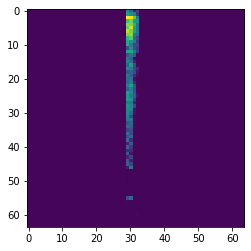

In [95]:
plt.imshow(act_res1)

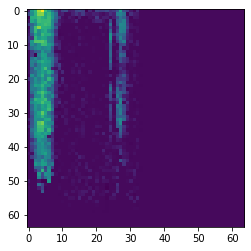

In [96]:
plt.imshow(act_res2)

In [ ]:
# batch code (if we need to make blocks)
batch_specs = []
out_specs = []

for i in batch_files:
    f = wavfile.read("outputs/combined/" + i)
    spec = []
    for j in range(f[1].shape[1]):
        wavf = (f[1].T[:, :2**18]/32768.0)[j]
        X = librosa.stft(wavf)
        Xdb = librosa.amplitude_to_db(abs(X))
        res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        spec.append(res/np.max(res))

    spec = (np.array(spec))
    batch_specs.append(spec)

    name_list = i.split(" ")
    f1 = name_list[0]
    f2 = name_list[1]
    x1, y1 = name_list[2][1:-1], name_list[3][:-1]
    z1 = name_list[4].split("]")[0]
    x2 = name_list[4].split("[")[1][:-1]
    y2 = name_list[5][:-1]
    z2 = name_list[6][:-5]

    loc1 = np.array([float(x1), float(y1), float(z1)])
    loc2 = np.array([float(x2), float(y2), float(z2)])
    fs, f1_wav = wavfile.read("inputs/ESC-50-master/audio/" + f1)
    fs, f2_wav = wavfile.read("inputs/ESC-50-master/audio/" + f2)

    out_spec = []

    f1f = (f1_wav[:2**18])/32768.0
    X = librosa.stft(f1f)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    out_spec.append(res/np.max(res))

    f2f = (f2_wav[:2**18])/32768.0
    X = librosa.stft(f2f)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    out_spec.append(res/np.max(res))

    out_spec = np.array(out_spec)
    out_specs.append(out_spec)

batch_specs = np.array(batch_specs)
batch_in = torch.from_numpy(batch_specs).float()

out_specs = np.array(out_specs)
batch_out = torch.from_numpy(out_specs).float()

In [ ]:
files = os.listdir("outputs/combined")
inputs = []
outputs = []
for i in files[:10]:
    inputs.append(wavfile.read("outputs/combined/" + i))
    
    name_list = i.split(" ")
    f1 = name_list[0]
    f2 = name_list[1]
    x1, y1 = name_list[2][1:-1], name_list[3][:-1]
    z1 = name_list[4].split("]")[0]
    x2 = name_list[4].split("[")[1][:-1]
    y2 = name_list[5][:-1]
    z2 = name_list[6][:-5]
    
    loc1 = np.array([float(x1), float(y1), float(z1)])
    loc2 = np.array([float(x2), float(y2), float(z2)])
    fs, f1_wav = wavfile.read("inputs/ESC-50-master/audio/" + f1)
    fs, f2_wav = wavfile.read("inputs/ESC-50-master/audio/" + f2)
    outputs.append([f1_wav, f2_wav, loc1, loc2])

In [ ]:
# print(model.blocks)

In [ ]:
inputs = []
outputs = []

batch_idx = (np.random.choice(list(range(31000)), 5, replace = False))
batch_files = ([files[x] for x in batch_idx])

batch_specs = []
out_specs = []

for i in batch_files:
    inputs.append(wavfile.read("outputs/combined/" + i))
    
    f = wavfile.read("outputs/combined/" + i)
    spec = []
    for j in range(f[1].shape[1]):
        wavf = (f[1].T[:, :2**18]/32768.0)[j]
        X = librosa.stft(wavf)
        Xdb = librosa.amplitude_to_db(abs(X))
        res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        spec.append(res)
    
    spec = (np.array(spec))
    batch_specs.append(spec)
    
    name_list = i.split(" ")
    f1 = name_list[0]
    f2 = name_list[1]
    x1, y1 = name_list[2][1:-1], name_list[3][:-1]
    z1 = name_list[4].split("]")[0]
    x2 = name_list[4].split("[")[1][:-1]
    y2 = name_list[5][:-1]
    z2 = name_list[6][:-5]

    loc1 = np.array([float(x1), float(y1), float(z1)])
    loc2 = np.array([float(x2), float(y2), float(z2)])
    fs, f1_wav = wavfile.read("inputs/ESC-50-master/audio/" + f1)
    fs, f2_wav = wavfile.read("inputs/ESC-50-master/audio/" + f2)
    
    out_spec = []
    
    f1f = (f1_wav[:2**18])/32768.0
    X = librosa.stft(f1f)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    out_spec.append(res)
    
    f2f = (f2_wav[:2**18])/32768.0
    X = librosa.stft(f2f)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    out_spec.append(res)
    
    out_spec = np.array(out_spec)
    out_specs.append(out_spec)
    
    #f1_wav[:, :2**18]/32768.0 
    #outputs.append([f1_wav, f2_wav, loc1, loc2])

    
    
    
    
    
batch_specs = np.array(batch_specs)
batch_in = torch.from_numpy(batch_specs).float()
print(batch_in.shape)

out_specs = np.array(out_specs)
batch_out = torch.from_numpy(out_specs).float()
print(batch_out.shape)


In [ ]:


spec = []
for i in range(inputs[0][1].shape[1]):
    wavf = (inputs[0][1].T[:, :2**18]/32768.0)[i]
    X = librosa.stft(wavf)
    Xdb = librosa.amplitude_to_db(abs(X))
    res = cv2.resize(Xdb, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    spec.append(res)
    print(res.shape)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(res, sr = fs, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()

spec = np.array(spec)
print(wavf.shape)
frequencies, times, spectrogram = signal.spectrogram(wavf, fs)
print(spectrogram.shape)

# plt.pcolormesh(times, frequencies, spectrogram)
# print(spectrogram[0].shape)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

spec = np.expand_dims(spec, axis=0)
tens = torch.from_numpy(spec).float()
print(spec.shape)

In [ ]:
result = model.forward(tens)

In [ ]:
print(result.shape)

In [ ]:
def build_cnn_model_separate():
    cnn_model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())